## GPS Spoofing Detection

### 1. load data and preprocess

In [1]:
# Load Data
import DataLoader
import os
import numpy as np
import config

A, B = DataLoader.load_image_pairs(path=config.SWISS_RESIZED)
assert A.shape[0]==B.shape[0]
n = A.shape[0]
print(A.shape, B.shape)

# Some configuration
feature_map_file_name = './mid_product/features_swiss_res34_noeval.h5'#'features_suzhou_res50.h5'
#feature_map_file_name = config.FULL_RESIZED_FEATURE
dst_file_name = './mid_product/dst_swiss_res34_noeval.npy'# 'dst_suzhou_res50.npy' 
# feature_shape = (512, 18, 26) # SWISS, resnet-18/34
feature_shape = (512, 17, 34) # SUZHOU, 1280x720, resnet-18/34
# feature_shape = (2048, 17, 34) # SUZHOU, resnet-50

(313, 720, 1280, 3) (313, 720, 1280, 3)


In [2]:
# Preprocess data by doing transformation
import torch

A = A.astype(np.float)/255.0
B = B.astype(np.float)/255.0 #.transpose(0,3,1,2)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
x_a = torch.from_numpy((A-mean)/std).permute(0,3,1,2).float()
x_b = torch.from_numpy((B-mean)/std).permute(0,3,1,2).float()
print(x_a.size(), x_b.size())

torch.Size([313, 3, 720, 1280]) torch.Size([313, 3, 720, 1280])


### 2. get feature maps

In [3]:
import torchvision.models as models
from torch import nn

pretrained_model = models.resnet34(pretrained=True)
feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])
#feature_extractor.eval()
for param in feature_extractor.parameters():
    param.requires_grad = False

In [4]:
# Generate feature map and save
import h5py

def h5_save(fname, f_a, f_b):
    '''save f_a and f_b as fname'''
    with h5py.File(fname,'w') as f:
        f.create_dataset('f_a', data=f_a)
        f.create_dataset('f_b', data=f_b)
    
def h5_read(fname):
    '''read fname and return f_a and f_b'''
    with h5py.File(fname,'r') as f:
        return f['f_a'][:], f['f_b'][:]

if not os.path.exists(feature_map_file_name):
    f_a = np.zeros((n,)+feature_shape)
    f_b = np.zeros((n,)+feature_shape)
    for i in range(n):
        print( "Generating feature maps of %d / %d th pair."%(i+1, n), end='\r')
        a = feature_extractor(x_a[i:i+1,:,:,:])
        b = feature_extractor(x_b[i:i+1,:,:,:])
        f_a[i] = a.detach().numpy()
        f_b[i] = b.detach().numpy()
    h5_save(feature_map_file_name, f_a, f_b)
else:
    print("Feature maps file already exists, we just read it.")
    f_a, f_b = h5_read(feature_map_file_name)

In [5]:
# compute distance between unpaird and paired images
print("A domain feature maps size:", f_a.shape)
dst=np.zeros((n,n))
for shift in range(n):
    for idx in range(n):
        a = f_a[idx:idx+1]
        b = f_b[(idx+shift)%n:(idx+shift)%n+1]
        dst[idx,shift] = np.linalg.norm(a - b)
        print('dst(idx,shift)(%d,%d)=%f' % (idx,shift,dst[idx,shift]))
np.save(dst_file_name, dst)

A domain feature maps size: (313, 512, 17, 34)
dst(idx,shift)(0,0)=459.777105
dst(idx,shift)(1,0)=442.930831
dst(idx,shift)(2,0)=435.574020
dst(idx,shift)(3,0)=456.446720
dst(idx,shift)(4,0)=450.063477
dst(idx,shift)(5,0)=460.906633
dst(idx,shift)(6,0)=439.929551
dst(idx,shift)(7,0)=448.616636
dst(idx,shift)(8,0)=433.594291
dst(idx,shift)(9,0)=410.865783
dst(idx,shift)(10,0)=403.669497
dst(idx,shift)(11,0)=388.417824
dst(idx,shift)(12,0)=447.143568
dst(idx,shift)(13,0)=479.470449
dst(idx,shift)(14,0)=482.199569
dst(idx,shift)(15,0)=457.835707
dst(idx,shift)(16,0)=436.625166
dst(idx,shift)(17,0)=400.506325
dst(idx,shift)(18,0)=402.376621
dst(idx,shift)(19,0)=395.072903
dst(idx,shift)(20,0)=442.717506
dst(idx,shift)(21,0)=447.479346
dst(idx,shift)(22,0)=453.572799
dst(idx,shift)(23,0)=436.782978
dst(idx,shift)(24,0)=416.235233
dst(idx,shift)(25,0)=407.371460
dst(idx,shift)(26,0)=398.387384
dst(idx,shift)(27,0)=405.311361
dst(idx,shift)(28,0)=412.586547
dst(idx,shift)(29,0)=411.705312
dst

dst(idx,shift)(57,1)=469.465949
dst(idx,shift)(58,1)=479.707102
dst(idx,shift)(59,1)=493.429546
dst(idx,shift)(60,1)=467.002869
dst(idx,shift)(61,1)=489.315728
dst(idx,shift)(62,1)=486.170992
dst(idx,shift)(63,1)=458.312525
dst(idx,shift)(64,1)=467.194461
dst(idx,shift)(65,1)=455.715713
dst(idx,shift)(66,1)=468.561361
dst(idx,shift)(67,1)=476.942528
dst(idx,shift)(68,1)=483.572411
dst(idx,shift)(69,1)=540.943006
dst(idx,shift)(70,1)=493.472743
dst(idx,shift)(71,1)=492.925045
dst(idx,shift)(72,1)=468.416731
dst(idx,shift)(73,1)=484.031118
dst(idx,shift)(74,1)=489.045819
dst(idx,shift)(75,1)=494.540616
dst(idx,shift)(76,1)=495.970716
dst(idx,shift)(77,1)=474.088106
dst(idx,shift)(78,1)=503.582848
dst(idx,shift)(79,1)=482.245473
dst(idx,shift)(80,1)=467.116557
dst(idx,shift)(81,1)=473.674358
dst(idx,shift)(82,1)=486.123256
dst(idx,shift)(83,1)=473.377188
dst(idx,shift)(84,1)=467.559566
dst(idx,shift)(85,1)=502.933001
dst(idx,shift)(86,1)=504.007241
dst(idx,shift)(87,1)=497.456280
dst(idx,

dst(idx,shift)(21,2)=517.476549
dst(idx,shift)(22,2)=510.856519
dst(idx,shift)(23,2)=506.515428
dst(idx,shift)(24,2)=506.584530
dst(idx,shift)(25,2)=498.364201
dst(idx,shift)(26,2)=499.945678
dst(idx,shift)(27,2)=497.911879
dst(idx,shift)(28,2)=494.033444
dst(idx,shift)(29,2)=492.795530
dst(idx,shift)(30,2)=479.945736
dst(idx,shift)(31,2)=483.041660
dst(idx,shift)(32,2)=486.382332
dst(idx,shift)(33,2)=500.142356
dst(idx,shift)(34,2)=505.693370
dst(idx,shift)(35,2)=499.981560
dst(idx,shift)(36,2)=519.609957
dst(idx,shift)(37,2)=501.963634
dst(idx,shift)(38,2)=492.759864
dst(idx,shift)(39,2)=506.784119
dst(idx,shift)(40,2)=473.798481
dst(idx,shift)(41,2)=493.016695
dst(idx,shift)(42,2)=497.356096
dst(idx,shift)(43,2)=486.975673
dst(idx,shift)(44,2)=513.156088
dst(idx,shift)(45,2)=490.047618
dst(idx,shift)(46,2)=485.562744
dst(idx,shift)(47,2)=464.183045
dst(idx,shift)(48,2)=477.735293
dst(idx,shift)(49,2)=485.792674
dst(idx,shift)(50,2)=504.944496
dst(idx,shift)(51,2)=522.740173
dst(idx,

dst(idx,shift)(93,3)=488.976178
dst(idx,shift)(94,3)=472.196099
dst(idx,shift)(95,3)=515.620435
dst(idx,shift)(96,3)=520.695056
dst(idx,shift)(97,3)=497.520220
dst(idx,shift)(98,3)=497.914079
dst(idx,shift)(99,3)=523.438459
dst(idx,shift)(100,3)=533.836044
dst(idx,shift)(101,3)=509.519342
dst(idx,shift)(102,3)=473.179450
dst(idx,shift)(103,3)=508.819940
dst(idx,shift)(104,3)=495.307551
dst(idx,shift)(105,3)=467.706888
dst(idx,shift)(106,3)=477.361660
dst(idx,shift)(107,3)=477.938202
dst(idx,shift)(108,3)=493.191547
dst(idx,shift)(109,3)=484.045251
dst(idx,shift)(110,3)=480.318655
dst(idx,shift)(111,3)=506.693746
dst(idx,shift)(112,3)=520.805253
dst(idx,shift)(113,3)=484.368832
dst(idx,shift)(114,3)=498.317763
dst(idx,shift)(115,3)=551.369953
dst(idx,shift)(116,3)=560.184060
dst(idx,shift)(117,3)=500.588383
dst(idx,shift)(118,3)=490.068867
dst(idx,shift)(119,3)=524.145858
dst(idx,shift)(120,3)=513.547007
dst(idx,shift)(121,3)=510.046086
dst(idx,shift)(122,3)=529.149454
dst(idx,shift)(12

dst(idx,shift)(50,5)=498.259482
dst(idx,shift)(51,5)=485.940399
dst(idx,shift)(52,5)=487.135612
dst(idx,shift)(53,5)=501.644118
dst(idx,shift)(54,5)=518.534223
dst(idx,shift)(55,5)=508.587945
dst(idx,shift)(56,5)=474.871533
dst(idx,shift)(57,5)=484.339731
dst(idx,shift)(58,5)=481.776069
dst(idx,shift)(59,5)=497.766231
dst(idx,shift)(60,5)=477.373617
dst(idx,shift)(61,5)=477.646314
dst(idx,shift)(62,5)=511.320193
dst(idx,shift)(63,5)=507.507032
dst(idx,shift)(64,5)=497.359103
dst(idx,shift)(65,5)=482.165555
dst(idx,shift)(66,5)=514.596155
dst(idx,shift)(67,5)=497.119027
dst(idx,shift)(68,5)=490.197917
dst(idx,shift)(69,5)=499.334408
dst(idx,shift)(70,5)=513.356485
dst(idx,shift)(71,5)=523.178591
dst(idx,shift)(72,5)=485.202645
dst(idx,shift)(73,5)=499.081451
dst(idx,shift)(74,5)=493.826073
dst(idx,shift)(75,5)=486.566938
dst(idx,shift)(76,5)=483.755002
dst(idx,shift)(77,5)=503.269605
dst(idx,shift)(78,5)=536.311732
dst(idx,shift)(79,5)=503.806433
dst(idx,shift)(80,5)=481.183689
dst(idx,

dst(idx,shift)(157,6)=514.539389
dst(idx,shift)(158,6)=510.657243
dst(idx,shift)(159,6)=516.093159
dst(idx,shift)(160,6)=497.684747
dst(idx,shift)(161,6)=496.846583
dst(idx,shift)(162,6)=507.844932
dst(idx,shift)(163,6)=507.255804
dst(idx,shift)(164,6)=518.505856
dst(idx,shift)(165,6)=502.442327
dst(idx,shift)(166,6)=486.082172
dst(idx,shift)(167,6)=524.306839
dst(idx,shift)(168,6)=521.930796
dst(idx,shift)(169,6)=533.129161
dst(idx,shift)(170,6)=535.602452
dst(idx,shift)(171,6)=522.265963
dst(idx,shift)(172,6)=498.486506
dst(idx,shift)(173,6)=526.191256
dst(idx,shift)(174,6)=513.977357
dst(idx,shift)(175,6)=496.404682
dst(idx,shift)(176,6)=495.809341
dst(idx,shift)(177,6)=495.873000
dst(idx,shift)(178,6)=499.615099
dst(idx,shift)(179,6)=529.243122
dst(idx,shift)(180,6)=513.704999
dst(idx,shift)(181,6)=511.253476
dst(idx,shift)(182,6)=535.384123
dst(idx,shift)(183,6)=527.257467
dst(idx,shift)(184,6)=518.446269
dst(idx,shift)(185,6)=532.189513
dst(idx,shift)(186,6)=514.157388
dst(idx,sh

dst(idx,shift)(283,7)=559.797195
dst(idx,shift)(284,7)=536.082130
dst(idx,shift)(285,7)=517.028962
dst(idx,shift)(286,7)=526.534807
dst(idx,shift)(287,7)=551.975943
dst(idx,shift)(288,7)=533.434209
dst(idx,shift)(289,7)=516.705422
dst(idx,shift)(290,7)=531.926749
dst(idx,shift)(291,7)=536.739860
dst(idx,shift)(292,7)=525.966873
dst(idx,shift)(293,7)=508.378651
dst(idx,shift)(294,7)=532.442738
dst(idx,shift)(295,7)=531.273382
dst(idx,shift)(296,7)=500.213655
dst(idx,shift)(297,7)=512.316550
dst(idx,shift)(298,7)=510.147976
dst(idx,shift)(299,7)=518.446903
dst(idx,shift)(300,7)=507.196609
dst(idx,shift)(301,7)=512.082754
dst(idx,shift)(302,7)=494.667489
dst(idx,shift)(303,7)=474.819695
dst(idx,shift)(304,7)=505.994560
dst(idx,shift)(305,7)=511.227670
dst(idx,shift)(306,7)=502.978058
dst(idx,shift)(307,7)=510.357080
dst(idx,shift)(308,7)=506.901924
dst(idx,shift)(309,7)=503.175858
dst(idx,shift)(310,7)=470.709978
dst(idx,shift)(311,7)=478.227042
dst(idx,shift)(312,7)=506.040399
dst(idx,sh

dst(idx,shift)(95,9)=494.452722
dst(idx,shift)(96,9)=477.665443
dst(idx,shift)(97,9)=476.250083
dst(idx,shift)(98,9)=483.368857
dst(idx,shift)(99,9)=502.446921
dst(idx,shift)(100,9)=490.740431
dst(idx,shift)(101,9)=497.738845
dst(idx,shift)(102,9)=499.659423
dst(idx,shift)(103,9)=510.967622
dst(idx,shift)(104,9)=471.934509
dst(idx,shift)(105,9)=475.498871
dst(idx,shift)(106,9)=497.713511
dst(idx,shift)(107,9)=504.253184
dst(idx,shift)(108,9)=501.164854
dst(idx,shift)(109,9)=508.930271
dst(idx,shift)(110,9)=531.161556
dst(idx,shift)(111,9)=507.354070
dst(idx,shift)(112,9)=488.275137
dst(idx,shift)(113,9)=458.951108
dst(idx,shift)(114,9)=492.357542
dst(idx,shift)(115,9)=545.230804
dst(idx,shift)(116,9)=520.191728
dst(idx,shift)(117,9)=492.913467
dst(idx,shift)(118,9)=492.368536
dst(idx,shift)(119,9)=556.891506
dst(idx,shift)(120,9)=525.519346
dst(idx,shift)(121,9)=492.803684
dst(idx,shift)(122,9)=529.137924
dst(idx,shift)(123,9)=521.902038
dst(idx,shift)(124,9)=492.974382
dst(idx,shift)(

dst(idx,shift)(198,10)=521.744969
dst(idx,shift)(199,10)=529.574834
dst(idx,shift)(200,10)=522.530986
dst(idx,shift)(201,10)=515.779585
dst(idx,shift)(202,10)=513.125681
dst(idx,shift)(203,10)=542.619411
dst(idx,shift)(204,10)=525.631195
dst(idx,shift)(205,10)=532.029273
dst(idx,shift)(206,10)=526.133214
dst(idx,shift)(207,10)=546.005561
dst(idx,shift)(208,10)=535.014010
dst(idx,shift)(209,10)=515.765680
dst(idx,shift)(210,10)=518.658967
dst(idx,shift)(211,10)=520.550164
dst(idx,shift)(212,10)=522.275978
dst(idx,shift)(213,10)=505.060470
dst(idx,shift)(214,10)=528.640416
dst(idx,shift)(215,10)=509.753653
dst(idx,shift)(216,10)=520.669171
dst(idx,shift)(217,10)=499.486298
dst(idx,shift)(218,10)=535.978527
dst(idx,shift)(219,10)=503.318553
dst(idx,shift)(220,10)=497.899744
dst(idx,shift)(221,10)=504.148808
dst(idx,shift)(222,10)=505.639217
dst(idx,shift)(223,10)=504.136903
dst(idx,shift)(224,10)=498.346284
dst(idx,shift)(225,10)=524.150724
dst(idx,shift)(226,10)=509.274938
dst(idx,shift)

dst(idx,shift)(303,11)=485.347158
dst(idx,shift)(304,11)=502.369183
dst(idx,shift)(305,11)=502.983110
dst(idx,shift)(306,11)=503.646011
dst(idx,shift)(307,11)=508.378206
dst(idx,shift)(308,11)=527.210847
dst(idx,shift)(309,11)=501.905619
dst(idx,shift)(310,11)=471.524509
dst(idx,shift)(311,11)=485.379654
dst(idx,shift)(312,11)=512.104078
dst(idx,shift)(0,12)=506.593410
dst(idx,shift)(1,12)=504.629471
dst(idx,shift)(2,12)=519.997969
dst(idx,shift)(3,12)=521.595849
dst(idx,shift)(4,12)=512.490676
dst(idx,shift)(5,12)=512.928357
dst(idx,shift)(6,12)=521.246130
dst(idx,shift)(7,12)=526.256381
dst(idx,shift)(8,12)=529.861238
dst(idx,shift)(9,12)=530.117098
dst(idx,shift)(10,12)=539.076703
dst(idx,shift)(11,12)=505.749042
dst(idx,shift)(12,12)=504.998945
dst(idx,shift)(13,12)=484.437730
dst(idx,shift)(14,12)=489.207967
dst(idx,shift)(15,12)=497.509446
dst(idx,shift)(16,12)=516.662195
dst(idx,shift)(17,12)=495.449766
dst(idx,shift)(18,12)=509.737205
dst(idx,shift)(19,12)=522.067241
dst(idx,sh

dst(idx,shift)(94,13)=506.864020
dst(idx,shift)(95,13)=518.578779
dst(idx,shift)(96,13)=492.192116
dst(idx,shift)(97,13)=484.392816
dst(idx,shift)(98,13)=519.354156
dst(idx,shift)(99,13)=522.690232
dst(idx,shift)(100,13)=485.067214
dst(idx,shift)(101,13)=500.590654
dst(idx,shift)(102,13)=526.647793
dst(idx,shift)(103,13)=536.514659
dst(idx,shift)(104,13)=503.438723
dst(idx,shift)(105,13)=496.816614
dst(idx,shift)(106,13)=507.476659
dst(idx,shift)(107,13)=499.597562
dst(idx,shift)(108,13)=488.673769
dst(idx,shift)(109,13)=491.717724
dst(idx,shift)(110,13)=494.712724
dst(idx,shift)(111,13)=479.165852
dst(idx,shift)(112,13)=490.865738
dst(idx,shift)(113,13)=469.300237
dst(idx,shift)(114,13)=470.152003
dst(idx,shift)(115,13)=512.147835
dst(idx,shift)(116,13)=509.680083
dst(idx,shift)(117,13)=469.553095
dst(idx,shift)(118,13)=520.832432
dst(idx,shift)(119,13)=496.769590
dst(idx,shift)(120,13)=486.844411
dst(idx,shift)(121,13)=482.238063
dst(idx,shift)(122,13)=495.931317
dst(idx,shift)(123,1

dst(idx,shift)(202,14)=520.354474
dst(idx,shift)(203,14)=531.760112
dst(idx,shift)(204,14)=528.770085
dst(idx,shift)(205,14)=521.602352
dst(idx,shift)(206,14)=535.297725
dst(idx,shift)(207,14)=523.976752
dst(idx,shift)(208,14)=511.280739
dst(idx,shift)(209,14)=506.812849
dst(idx,shift)(210,14)=524.894430
dst(idx,shift)(211,14)=505.752368
dst(idx,shift)(212,14)=508.923034
dst(idx,shift)(213,14)=501.637042
dst(idx,shift)(214,14)=519.059594
dst(idx,shift)(215,14)=500.638846
dst(idx,shift)(216,14)=504.782083
dst(idx,shift)(217,14)=509.735469
dst(idx,shift)(218,14)=507.532319
dst(idx,shift)(219,14)=499.602952
dst(idx,shift)(220,14)=493.875130
dst(idx,shift)(221,14)=486.741081
dst(idx,shift)(222,14)=508.771059
dst(idx,shift)(223,14)=504.141845
dst(idx,shift)(224,14)=512.039184
dst(idx,shift)(225,14)=521.317021
dst(idx,shift)(226,14)=525.263267
dst(idx,shift)(227,14)=526.876352
dst(idx,shift)(228,14)=515.126478
dst(idx,shift)(229,14)=499.335447
dst(idx,shift)(230,14)=517.133931
dst(idx,shift)

dst(idx,shift)(306,15)=500.003728
dst(idx,shift)(307,15)=504.198009
dst(idx,shift)(308,15)=518.000768
dst(idx,shift)(309,15)=488.631740
dst(idx,shift)(310,15)=495.039916
dst(idx,shift)(311,15)=503.611152
dst(idx,shift)(312,15)=496.913748
dst(idx,shift)(0,16)=505.192824
dst(idx,shift)(1,16)=496.026232
dst(idx,shift)(2,16)=517.644000
dst(idx,shift)(3,16)=515.849568
dst(idx,shift)(4,16)=519.306543
dst(idx,shift)(5,16)=512.337484
dst(idx,shift)(6,16)=522.748710
dst(idx,shift)(7,16)=529.910420
dst(idx,shift)(8,16)=508.521407
dst(idx,shift)(9,16)=477.646303
dst(idx,shift)(10,16)=501.071874
dst(idx,shift)(11,16)=497.942162
dst(idx,shift)(12,16)=491.964991
dst(idx,shift)(13,16)=489.179204
dst(idx,shift)(14,16)=490.793321
dst(idx,shift)(15,16)=492.482244
dst(idx,shift)(16,16)=509.607493
dst(idx,shift)(17,16)=491.949750
dst(idx,shift)(18,16)=487.110807
dst(idx,shift)(19,16)=492.436344
dst(idx,shift)(20,16)=527.592276
dst(idx,shift)(21,16)=530.332046
dst(idx,shift)(22,16)=523.846969
dst(idx,shift

dst(idx,shift)(105,17)=481.584812
dst(idx,shift)(106,17)=487.733684
dst(idx,shift)(107,17)=515.411228
dst(idx,shift)(108,17)=501.086127
dst(idx,shift)(109,17)=493.993649
dst(idx,shift)(110,17)=498.148873
dst(idx,shift)(111,17)=533.871070
dst(idx,shift)(112,17)=506.430685
dst(idx,shift)(113,17)=481.452415
dst(idx,shift)(114,17)=526.011984
dst(idx,shift)(115,17)=543.239966
dst(idx,shift)(116,17)=522.185582
dst(idx,shift)(117,17)=499.715938
dst(idx,shift)(118,17)=496.740486
dst(idx,shift)(119,17)=515.074155
dst(idx,shift)(120,17)=489.190434
dst(idx,shift)(121,17)=503.102922
dst(idx,shift)(122,17)=503.462256
dst(idx,shift)(123,17)=503.860312
dst(idx,shift)(124,17)=521.434943
dst(idx,shift)(125,17)=507.094539
dst(idx,shift)(126,17)=497.470166
dst(idx,shift)(127,17)=515.859687
dst(idx,shift)(128,17)=521.181947
dst(idx,shift)(129,17)=506.049850
dst(idx,shift)(130,17)=512.058222
dst(idx,shift)(131,17)=511.689216
dst(idx,shift)(132,17)=537.507660
dst(idx,shift)(133,17)=513.727540
dst(idx,shift)

dst(idx,shift)(160,18)=503.041194
dst(idx,shift)(161,18)=516.273399
dst(idx,shift)(162,18)=510.581797
dst(idx,shift)(163,18)=510.237032
dst(idx,shift)(164,18)=509.632210
dst(idx,shift)(165,18)=504.951018
dst(idx,shift)(166,18)=509.389688
dst(idx,shift)(167,18)=515.784941
dst(idx,shift)(168,18)=498.847420
dst(idx,shift)(169,18)=519.195069
dst(idx,shift)(170,18)=526.021163
dst(idx,shift)(171,18)=518.898109
dst(idx,shift)(172,18)=511.956849
dst(idx,shift)(173,18)=520.429519
dst(idx,shift)(174,18)=510.847048
dst(idx,shift)(175,18)=512.907428
dst(idx,shift)(176,18)=519.990353
dst(idx,shift)(177,18)=512.877859
dst(idx,shift)(178,18)=511.313453
dst(idx,shift)(179,18)=507.212177
dst(idx,shift)(180,18)=520.638316
dst(idx,shift)(181,18)=539.330581
dst(idx,shift)(182,18)=539.379612
dst(idx,shift)(183,18)=518.355319
dst(idx,shift)(184,18)=520.846660
dst(idx,shift)(185,18)=521.954327
dst(idx,shift)(186,18)=512.810236
dst(idx,shift)(187,18)=543.481470
dst(idx,shift)(188,18)=510.244607
dst(idx,shift)

dst(idx,shift)(290,19)=527.710056
dst(idx,shift)(291,19)=517.637247
dst(idx,shift)(292,19)=529.194005
dst(idx,shift)(293,19)=504.825848
dst(idx,shift)(294,19)=512.494378
dst(idx,shift)(295,19)=521.217164
dst(idx,shift)(296,19)=493.209051
dst(idx,shift)(297,19)=503.957922
dst(idx,shift)(298,19)=513.440586
dst(idx,shift)(299,19)=515.700773
dst(idx,shift)(300,19)=493.155862
dst(idx,shift)(301,19)=508.162841
dst(idx,shift)(302,19)=491.987637
dst(idx,shift)(303,19)=494.844433
dst(idx,shift)(304,19)=513.117397
dst(idx,shift)(305,19)=508.410549
dst(idx,shift)(306,19)=507.952910
dst(idx,shift)(307,19)=517.618324
dst(idx,shift)(308,19)=532.467462
dst(idx,shift)(309,19)=511.780891
dst(idx,shift)(310,19)=497.551242
dst(idx,shift)(311,19)=503.768297
dst(idx,shift)(312,19)=517.720004
dst(idx,shift)(0,20)=501.616033
dst(idx,shift)(1,20)=502.140237
dst(idx,shift)(2,20)=520.592905
dst(idx,shift)(3,20)=530.842013
dst(idx,shift)(4,20)=519.369948
dst(idx,shift)(5,20)=510.579553
dst(idx,shift)(6,20)=521.2

dst(idx,shift)(83,21)=518.837418
dst(idx,shift)(84,21)=490.279107
dst(idx,shift)(85,21)=499.081918
dst(idx,shift)(86,21)=498.540124
dst(idx,shift)(87,21)=503.252233
dst(idx,shift)(88,21)=505.823000
dst(idx,shift)(89,21)=474.584968
dst(idx,shift)(90,21)=506.924729
dst(idx,shift)(91,21)=511.013305
dst(idx,shift)(92,21)=485.384000
dst(idx,shift)(93,21)=497.515896
dst(idx,shift)(94,21)=532.589734
dst(idx,shift)(95,21)=524.713983
dst(idx,shift)(96,21)=485.631928
dst(idx,shift)(97,21)=506.219402
dst(idx,shift)(98,21)=537.711963
dst(idx,shift)(99,21)=535.402779
dst(idx,shift)(100,21)=503.162197
dst(idx,shift)(101,21)=490.592563
dst(idx,shift)(102,21)=512.432551
dst(idx,shift)(103,21)=495.654174
dst(idx,shift)(104,21)=478.893781
dst(idx,shift)(105,21)=476.744215
dst(idx,shift)(106,21)=458.976793
dst(idx,shift)(107,21)=492.541599
dst(idx,shift)(108,21)=513.291413
dst(idx,shift)(109,21)=498.415907
dst(idx,shift)(110,21)=530.209531
dst(idx,shift)(111,21)=486.018985
dst(idx,shift)(112,21)=484.6052

dst(idx,shift)(180,22)=536.657257
dst(idx,shift)(181,22)=536.723886
dst(idx,shift)(182,22)=530.206416
dst(idx,shift)(183,22)=565.081158
dst(idx,shift)(184,22)=519.729572
dst(idx,shift)(185,22)=532.509426
dst(idx,shift)(186,22)=510.128804
dst(idx,shift)(187,22)=506.869249
dst(idx,shift)(188,22)=507.083014
dst(idx,shift)(189,22)=513.212789
dst(idx,shift)(190,22)=508.594189
dst(idx,shift)(191,22)=519.314584
dst(idx,shift)(192,22)=492.061414
dst(idx,shift)(193,22)=504.741672
dst(idx,shift)(194,22)=485.797701
dst(idx,shift)(195,22)=504.076306
dst(idx,shift)(196,22)=523.461712
dst(idx,shift)(197,22)=492.534731
dst(idx,shift)(198,22)=509.164599
dst(idx,shift)(199,22)=524.853990
dst(idx,shift)(200,22)=525.158497
dst(idx,shift)(201,22)=531.072702
dst(idx,shift)(202,22)=535.333523
dst(idx,shift)(203,22)=524.749357
dst(idx,shift)(204,22)=544.021437
dst(idx,shift)(205,22)=526.459668
dst(idx,shift)(206,22)=539.737593
dst(idx,shift)(207,22)=544.344512
dst(idx,shift)(208,22)=518.682576
dst(idx,shift)

dst(idx,shift)(286,23)=505.237502
dst(idx,shift)(287,23)=501.592663
dst(idx,shift)(288,23)=508.766551
dst(idx,shift)(289,23)=533.882742
dst(idx,shift)(290,23)=502.957571
dst(idx,shift)(291,23)=506.644825
dst(idx,shift)(292,23)=493.387085
dst(idx,shift)(293,23)=490.323771
dst(idx,shift)(294,23)=524.843540
dst(idx,shift)(295,23)=528.473038
dst(idx,shift)(296,23)=514.881298
dst(idx,shift)(297,23)=514.583153
dst(idx,shift)(298,23)=500.591306
dst(idx,shift)(299,23)=526.155921
dst(idx,shift)(300,23)=516.485509
dst(idx,shift)(301,23)=500.588329
dst(idx,shift)(302,23)=496.663552
dst(idx,shift)(303,23)=486.254728
dst(idx,shift)(304,23)=505.298514
dst(idx,shift)(305,23)=518.798378
dst(idx,shift)(306,23)=513.839950
dst(idx,shift)(307,23)=505.676867
dst(idx,shift)(308,23)=517.722823
dst(idx,shift)(309,23)=509.866361
dst(idx,shift)(310,23)=511.658998
dst(idx,shift)(311,23)=505.385702
dst(idx,shift)(312,23)=501.277543
dst(idx,shift)(0,24)=509.340094
dst(idx,shift)(1,24)=497.908541
dst(idx,shift)(2,2

dst(idx,shift)(78,25)=528.544713
dst(idx,shift)(79,25)=494.870364
dst(idx,shift)(80,25)=465.296335
dst(idx,shift)(81,25)=477.102077
dst(idx,shift)(82,25)=483.420430
dst(idx,shift)(83,25)=501.020145
dst(idx,shift)(84,25)=509.169880
dst(idx,shift)(85,25)=497.324134
dst(idx,shift)(86,25)=487.597506
dst(idx,shift)(87,25)=487.580071
dst(idx,shift)(88,25)=461.621473
dst(idx,shift)(89,25)=466.651733
dst(idx,shift)(90,25)=510.960396
dst(idx,shift)(91,25)=518.617470
dst(idx,shift)(92,25)=511.045011
dst(idx,shift)(93,25)=505.016269
dst(idx,shift)(94,25)=490.823926
dst(idx,shift)(95,25)=509.167296
dst(idx,shift)(96,25)=485.109571
dst(idx,shift)(97,25)=478.528913
dst(idx,shift)(98,25)=507.971438
dst(idx,shift)(99,25)=527.654915
dst(idx,shift)(100,25)=511.253228
dst(idx,shift)(101,25)=494.374323
dst(idx,shift)(102,25)=507.796617
dst(idx,shift)(103,25)=541.670414
dst(idx,shift)(104,25)=501.480518
dst(idx,shift)(105,25)=480.067589
dst(idx,shift)(106,25)=518.009458
dst(idx,shift)(107,25)=517.725364
ds

dst(idx,shift)(174,26)=527.754921
dst(idx,shift)(175,26)=529.482846
dst(idx,shift)(176,26)=519.282016
dst(idx,shift)(177,26)=516.464228
dst(idx,shift)(178,26)=523.851426
dst(idx,shift)(179,26)=576.704089
dst(idx,shift)(180,26)=528.977685
dst(idx,shift)(181,26)=543.958830
dst(idx,shift)(182,26)=502.841765
dst(idx,shift)(183,26)=484.278620
dst(idx,shift)(184,26)=481.921194
dst(idx,shift)(185,26)=520.714321
dst(idx,shift)(186,26)=507.110348
dst(idx,shift)(187,26)=499.302495
dst(idx,shift)(188,26)=525.263554
dst(idx,shift)(189,26)=499.222754
dst(idx,shift)(190,26)=502.763025
dst(idx,shift)(191,26)=527.845538
dst(idx,shift)(192,26)=487.665690
dst(idx,shift)(193,26)=518.919948
dst(idx,shift)(194,26)=515.708373
dst(idx,shift)(195,26)=489.245993
dst(idx,shift)(196,26)=505.512167
dst(idx,shift)(197,26)=487.460170
dst(idx,shift)(198,26)=525.335471
dst(idx,shift)(199,26)=521.918866
dst(idx,shift)(200,26)=545.892400
dst(idx,shift)(201,26)=506.477408
dst(idx,shift)(202,26)=548.510506
dst(idx,shift)

dst(idx,shift)(284,27)=504.839109
dst(idx,shift)(285,27)=508.171247
dst(idx,shift)(286,27)=505.779306
dst(idx,shift)(287,27)=497.797885
dst(idx,shift)(288,27)=507.211309
dst(idx,shift)(289,27)=523.183986
dst(idx,shift)(290,27)=511.378013
dst(idx,shift)(291,27)=518.270745
dst(idx,shift)(292,27)=516.899210
dst(idx,shift)(293,27)=501.987726
dst(idx,shift)(294,27)=537.909125
dst(idx,shift)(295,27)=549.093320
dst(idx,shift)(296,27)=531.715503
dst(idx,shift)(297,27)=508.042984
dst(idx,shift)(298,27)=521.592609
dst(idx,shift)(299,27)=508.482202
dst(idx,shift)(300,27)=488.503661
dst(idx,shift)(301,27)=502.959346
dst(idx,shift)(302,27)=501.381209
dst(idx,shift)(303,27)=481.837655
dst(idx,shift)(304,27)=517.481464
dst(idx,shift)(305,27)=502.161197
dst(idx,shift)(306,27)=516.553820
dst(idx,shift)(307,27)=521.054666
dst(idx,shift)(308,27)=521.602238
dst(idx,shift)(309,27)=506.160921
dst(idx,shift)(310,27)=489.765413
dst(idx,shift)(311,27)=474.653980
dst(idx,shift)(312,27)=510.937633
dst(idx,shift)

dst(idx,shift)(94,29)=510.540954
dst(idx,shift)(95,29)=507.621209
dst(idx,shift)(96,29)=477.778742
dst(idx,shift)(97,29)=480.261424
dst(idx,shift)(98,29)=480.675127
dst(idx,shift)(99,29)=497.464535
dst(idx,shift)(100,29)=501.842389
dst(idx,shift)(101,29)=480.572316
dst(idx,shift)(102,29)=514.540280
dst(idx,shift)(103,29)=490.561119
dst(idx,shift)(104,29)=479.731264
dst(idx,shift)(105,29)=481.039039
dst(idx,shift)(106,29)=475.056981
dst(idx,shift)(107,29)=483.480137
dst(idx,shift)(108,29)=492.959600
dst(idx,shift)(109,29)=501.997071
dst(idx,shift)(110,29)=515.400466
dst(idx,shift)(111,29)=534.173625
dst(idx,shift)(112,29)=518.161277
dst(idx,shift)(113,29)=478.413328
dst(idx,shift)(114,29)=513.890869
dst(idx,shift)(115,29)=558.024283
dst(idx,shift)(116,29)=538.918304
dst(idx,shift)(117,29)=501.247321
dst(idx,shift)(118,29)=511.586466
dst(idx,shift)(119,29)=522.076276
dst(idx,shift)(120,29)=513.692005
dst(idx,shift)(121,29)=504.821864
dst(idx,shift)(122,29)=518.228549
dst(idx,shift)(123,2

dst(idx,shift)(217,30)=493.474905
dst(idx,shift)(218,30)=510.862109
dst(idx,shift)(219,30)=500.166391
dst(idx,shift)(220,30)=522.382869
dst(idx,shift)(221,30)=486.725175
dst(idx,shift)(222,30)=493.789814
dst(idx,shift)(223,30)=504.028336
dst(idx,shift)(224,30)=504.776048
dst(idx,shift)(225,30)=519.702768
dst(idx,shift)(226,30)=522.217913
dst(idx,shift)(227,30)=519.903588
dst(idx,shift)(228,30)=527.399438
dst(idx,shift)(229,30)=502.325497
dst(idx,shift)(230,30)=519.361700
dst(idx,shift)(231,30)=525.109583
dst(idx,shift)(232,30)=481.294414
dst(idx,shift)(233,30)=505.479289
dst(idx,shift)(234,30)=511.831465
dst(idx,shift)(235,30)=491.896234
dst(idx,shift)(236,30)=515.792052
dst(idx,shift)(237,30)=499.790248
dst(idx,shift)(238,30)=500.050394
dst(idx,shift)(239,30)=511.302616
dst(idx,shift)(240,30)=512.474977
dst(idx,shift)(241,30)=521.564832
dst(idx,shift)(242,30)=511.701332
dst(idx,shift)(243,30)=528.571128
dst(idx,shift)(244,30)=501.721581
dst(idx,shift)(245,30)=494.709063
dst(idx,shift)

dst(idx,shift)(10,32)=496.383252
dst(idx,shift)(11,32)=478.663962
dst(idx,shift)(12,32)=481.060600
dst(idx,shift)(13,32)=483.389749
dst(idx,shift)(14,32)=498.198613
dst(idx,shift)(15,32)=498.787994
dst(idx,shift)(16,32)=512.264205
dst(idx,shift)(17,32)=479.558603
dst(idx,shift)(18,32)=485.604835
dst(idx,shift)(19,32)=509.265982
dst(idx,shift)(20,32)=510.999943
dst(idx,shift)(21,32)=518.176462
dst(idx,shift)(22,32)=536.296273
dst(idx,shift)(23,32)=501.563909
dst(idx,shift)(24,32)=482.795854
dst(idx,shift)(25,32)=483.179866
dst(idx,shift)(26,32)=487.442067
dst(idx,shift)(27,32)=482.308255
dst(idx,shift)(28,32)=476.345374
dst(idx,shift)(29,32)=451.760125
dst(idx,shift)(30,32)=477.606977
dst(idx,shift)(31,32)=483.563446
dst(idx,shift)(32,32)=487.240449
dst(idx,shift)(33,32)=474.944715
dst(idx,shift)(34,32)=488.902756
dst(idx,shift)(35,32)=496.134862
dst(idx,shift)(36,32)=501.685051
dst(idx,shift)(37,32)=474.657449
dst(idx,shift)(38,32)=489.551064
dst(idx,shift)(39,32)=516.516278
dst(idx,sh

dst(idx,shift)(116,33)=500.175705
dst(idx,shift)(117,33)=500.349595
dst(idx,shift)(118,33)=500.821815
dst(idx,shift)(119,33)=527.802051
dst(idx,shift)(120,33)=517.264914
dst(idx,shift)(121,33)=503.076255
dst(idx,shift)(122,33)=502.501644
dst(idx,shift)(123,33)=511.290529
dst(idx,shift)(124,33)=517.227834
dst(idx,shift)(125,33)=509.839064
dst(idx,shift)(126,33)=505.036350
dst(idx,shift)(127,33)=527.042625
dst(idx,shift)(128,33)=535.310546
dst(idx,shift)(129,33)=531.310865
dst(idx,shift)(130,33)=507.924433
dst(idx,shift)(131,33)=526.980253
dst(idx,shift)(132,33)=542.073484
dst(idx,shift)(133,33)=510.222299
dst(idx,shift)(134,33)=527.728932
dst(idx,shift)(135,33)=506.877004
dst(idx,shift)(136,33)=504.928226
dst(idx,shift)(137,33)=500.463933
dst(idx,shift)(138,33)=514.853243
dst(idx,shift)(139,33)=501.290241
dst(idx,shift)(140,33)=512.569978
dst(idx,shift)(141,33)=523.499068
dst(idx,shift)(142,33)=517.556343
dst(idx,shift)(143,33)=517.499621
dst(idx,shift)(144,33)=528.276939
dst(idx,shift)

dst(idx,shift)(237,34)=487.258402
dst(idx,shift)(238,34)=499.333480
dst(idx,shift)(239,34)=511.764608
dst(idx,shift)(240,34)=480.205558
dst(idx,shift)(241,34)=502.621301
dst(idx,shift)(242,34)=496.904444
dst(idx,shift)(243,34)=527.313845
dst(idx,shift)(244,34)=541.107749
dst(idx,shift)(245,34)=533.274153
dst(idx,shift)(246,34)=521.383085
dst(idx,shift)(247,34)=514.757351
dst(idx,shift)(248,34)=514.728642
dst(idx,shift)(249,34)=533.445553
dst(idx,shift)(250,34)=515.958287
dst(idx,shift)(251,34)=507.289093
dst(idx,shift)(252,34)=518.427052
dst(idx,shift)(253,34)=519.691938
dst(idx,shift)(254,34)=506.698332
dst(idx,shift)(255,34)=524.967505
dst(idx,shift)(256,34)=542.467801
dst(idx,shift)(257,34)=536.039854
dst(idx,shift)(258,34)=539.255338
dst(idx,shift)(259,34)=539.253603
dst(idx,shift)(260,34)=546.458330
dst(idx,shift)(261,34)=525.826673
dst(idx,shift)(262,34)=492.427804
dst(idx,shift)(263,34)=511.020956
dst(idx,shift)(264,34)=518.592609
dst(idx,shift)(265,34)=517.428880
dst(idx,shift)

dst(idx,shift)(58,36)=482.903994
dst(idx,shift)(59,36)=508.672608
dst(idx,shift)(60,36)=485.493901
dst(idx,shift)(61,36)=468.468707
dst(idx,shift)(62,36)=507.308844
dst(idx,shift)(63,36)=528.559775
dst(idx,shift)(64,36)=501.589804
dst(idx,shift)(65,36)=484.813444
dst(idx,shift)(66,36)=487.060335
dst(idx,shift)(67,36)=532.741673
dst(idx,shift)(68,36)=514.583993
dst(idx,shift)(69,36)=498.921179
dst(idx,shift)(70,36)=506.634265
dst(idx,shift)(71,36)=522.505386
dst(idx,shift)(72,36)=502.047521
dst(idx,shift)(73,36)=498.582357
dst(idx,shift)(74,36)=481.701090
dst(idx,shift)(75,36)=493.387011
dst(idx,shift)(76,36)=497.986021
dst(idx,shift)(77,36)=483.910877
dst(idx,shift)(78,36)=512.791412
dst(idx,shift)(79,36)=521.698287
dst(idx,shift)(80,36)=502.222356
dst(idx,shift)(81,36)=490.799953
dst(idx,shift)(82,36)=515.035413
dst(idx,shift)(83,36)=542.430340
dst(idx,shift)(84,36)=520.516452
dst(idx,shift)(85,36)=495.605974
dst(idx,shift)(86,36)=502.663615
dst(idx,shift)(87,36)=532.788182
dst(idx,sh

dst(idx,shift)(164,37)=532.645513
dst(idx,shift)(165,37)=514.987115
dst(idx,shift)(166,37)=532.115346
dst(idx,shift)(167,37)=525.463738
dst(idx,shift)(168,37)=546.930212
dst(idx,shift)(169,37)=512.546344
dst(idx,shift)(170,37)=532.194204
dst(idx,shift)(171,37)=519.723617
dst(idx,shift)(172,37)=501.304848
dst(idx,shift)(173,37)=504.820513
dst(idx,shift)(174,37)=525.692187
dst(idx,shift)(175,37)=519.585163
dst(idx,shift)(176,37)=504.692188
dst(idx,shift)(177,37)=523.872803
dst(idx,shift)(178,37)=499.539256
dst(idx,shift)(179,37)=495.972818
dst(idx,shift)(180,37)=527.445676
dst(idx,shift)(181,37)=523.884259
dst(idx,shift)(182,37)=522.608645
dst(idx,shift)(183,37)=507.952828
dst(idx,shift)(184,37)=510.379657
dst(idx,shift)(185,37)=509.218274
dst(idx,shift)(186,37)=510.211421
dst(idx,shift)(187,37)=507.065348
dst(idx,shift)(188,37)=501.569699
dst(idx,shift)(189,37)=518.112950
dst(idx,shift)(190,37)=507.590091
dst(idx,shift)(191,37)=511.874923
dst(idx,shift)(192,37)=490.768354
dst(idx,shift)

dst(idx,shift)(258,38)=534.767330
dst(idx,shift)(259,38)=516.232146
dst(idx,shift)(260,38)=518.561946
dst(idx,shift)(261,38)=532.319937
dst(idx,shift)(262,38)=494.005950
dst(idx,shift)(263,38)=508.879807
dst(idx,shift)(264,38)=507.732659
dst(idx,shift)(265,38)=485.805920
dst(idx,shift)(266,38)=500.910473
dst(idx,shift)(267,38)=517.507505
dst(idx,shift)(268,38)=478.576231
dst(idx,shift)(269,38)=482.209564
dst(idx,shift)(270,38)=506.394387
dst(idx,shift)(271,38)=516.285566
dst(idx,shift)(272,38)=475.531089
dst(idx,shift)(273,38)=501.586671
dst(idx,shift)(274,38)=487.745969
dst(idx,shift)(275,38)=456.884115
dst(idx,shift)(276,38)=496.116296
dst(idx,shift)(277,38)=491.377985
dst(idx,shift)(278,38)=494.935503
dst(idx,shift)(279,38)=499.803162
dst(idx,shift)(280,38)=527.698853
dst(idx,shift)(281,38)=508.138934
dst(idx,shift)(282,38)=531.504502
dst(idx,shift)(283,38)=522.763966
dst(idx,shift)(284,38)=519.474514
dst(idx,shift)(285,38)=508.518943
dst(idx,shift)(286,38)=513.135957
dst(idx,shift)

dst(idx,shift)(56,40)=461.373163
dst(idx,shift)(57,40)=466.577485
dst(idx,shift)(58,40)=486.993299
dst(idx,shift)(59,40)=524.843716
dst(idx,shift)(60,40)=491.513570
dst(idx,shift)(61,40)=488.743262
dst(idx,shift)(62,40)=481.806583
dst(idx,shift)(63,40)=520.168933
dst(idx,shift)(64,40)=507.009128
dst(idx,shift)(65,40)=475.358407
dst(idx,shift)(66,40)=481.982026
dst(idx,shift)(67,40)=494.692141
dst(idx,shift)(68,40)=507.821034
dst(idx,shift)(69,40)=502.665174
dst(idx,shift)(70,40)=497.470704
dst(idx,shift)(71,40)=488.750441
dst(idx,shift)(72,40)=480.888404
dst(idx,shift)(73,40)=459.498942
dst(idx,shift)(74,40)=487.096380
dst(idx,shift)(75,40)=513.920254
dst(idx,shift)(76,40)=497.198691
dst(idx,shift)(77,40)=504.043241
dst(idx,shift)(78,40)=517.633335
dst(idx,shift)(79,40)=521.725505
dst(idx,shift)(80,40)=483.994127
dst(idx,shift)(81,40)=468.806313
dst(idx,shift)(82,40)=494.512674
dst(idx,shift)(83,40)=511.338705
dst(idx,shift)(84,40)=519.878289
dst(idx,shift)(85,40)=505.919725
dst(idx,sh

dst(idx,shift)(166,41)=544.588301
dst(idx,shift)(167,41)=503.734396
dst(idx,shift)(168,41)=496.968750
dst(idx,shift)(169,41)=508.004277
dst(idx,shift)(170,41)=539.208121
dst(idx,shift)(171,41)=513.928625
dst(idx,shift)(172,41)=513.438901
dst(idx,shift)(173,41)=505.779261
dst(idx,shift)(174,41)=492.102015
dst(idx,shift)(175,41)=487.519163
dst(idx,shift)(176,41)=507.882528
dst(idx,shift)(177,41)=506.067329
dst(idx,shift)(178,41)=519.062827
dst(idx,shift)(179,41)=532.280935
dst(idx,shift)(180,41)=507.724942
dst(idx,shift)(181,41)=516.395302
dst(idx,shift)(182,41)=519.764889
dst(idx,shift)(183,41)=523.263987
dst(idx,shift)(184,41)=517.984617
dst(idx,shift)(185,41)=520.726898
dst(idx,shift)(186,41)=501.025680
dst(idx,shift)(187,41)=515.478825
dst(idx,shift)(188,41)=498.808373
dst(idx,shift)(189,41)=516.601710
dst(idx,shift)(190,41)=521.802916
dst(idx,shift)(191,41)=500.744718
dst(idx,shift)(192,41)=485.633526
dst(idx,shift)(193,41)=508.427284
dst(idx,shift)(194,41)=507.364307
dst(idx,shift)

dst(idx,shift)(277,42)=488.225447
dst(idx,shift)(278,42)=507.447367
dst(idx,shift)(279,42)=520.628341
dst(idx,shift)(280,42)=516.369378
dst(idx,shift)(281,42)=498.650944
dst(idx,shift)(282,42)=518.936321
dst(idx,shift)(283,42)=523.182289
dst(idx,shift)(284,42)=504.522698
dst(idx,shift)(285,42)=493.271751
dst(idx,shift)(286,42)=502.263148
dst(idx,shift)(287,42)=503.624434
dst(idx,shift)(288,42)=502.509945
dst(idx,shift)(289,42)=519.865336
dst(idx,shift)(290,42)=511.576400
dst(idx,shift)(291,42)=511.453107
dst(idx,shift)(292,42)=501.489588
dst(idx,shift)(293,42)=496.499334
dst(idx,shift)(294,42)=532.162771
dst(idx,shift)(295,42)=524.868563
dst(idx,shift)(296,42)=512.875002
dst(idx,shift)(297,42)=507.760457
dst(idx,shift)(298,42)=518.097904
dst(idx,shift)(299,42)=488.516089
dst(idx,shift)(300,42)=475.568969
dst(idx,shift)(301,42)=481.168377
dst(idx,shift)(302,42)=488.620964
dst(idx,shift)(303,42)=474.898997
dst(idx,shift)(304,42)=500.782846
dst(idx,shift)(305,42)=514.308608
dst(idx,shift)

dst(idx,shift)(52,44)=508.439719
dst(idx,shift)(53,44)=503.781623
dst(idx,shift)(54,44)=507.810084
dst(idx,shift)(55,44)=530.950029
dst(idx,shift)(56,44)=487.889625
dst(idx,shift)(57,44)=481.553401
dst(idx,shift)(58,44)=483.345585
dst(idx,shift)(59,44)=531.344316
dst(idx,shift)(60,44)=503.078549
dst(idx,shift)(61,44)=466.585740
dst(idx,shift)(62,44)=503.770828
dst(idx,shift)(63,44)=492.669448
dst(idx,shift)(64,44)=475.431809
dst(idx,shift)(65,44)=467.597730
dst(idx,shift)(66,44)=490.076670
dst(idx,shift)(67,44)=512.564916
dst(idx,shift)(68,44)=509.607879
dst(idx,shift)(69,44)=491.409024
dst(idx,shift)(70,44)=507.939634
dst(idx,shift)(71,44)=557.413612
dst(idx,shift)(72,44)=518.238189
dst(idx,shift)(73,44)=501.163175
dst(idx,shift)(74,44)=501.077912
dst(idx,shift)(75,44)=517.004559
dst(idx,shift)(76,44)=503.858285
dst(idx,shift)(77,44)=497.215833
dst(idx,shift)(78,44)=512.403646
dst(idx,shift)(79,44)=503.881850
dst(idx,shift)(80,44)=493.426188
dst(idx,shift)(81,44)=490.795111
dst(idx,sh

dst(idx,shift)(191,45)=507.332683
dst(idx,shift)(192,45)=485.040308
dst(idx,shift)(193,45)=497.665855
dst(idx,shift)(194,45)=493.172663
dst(idx,shift)(195,45)=506.616633
dst(idx,shift)(196,45)=510.368119
dst(idx,shift)(197,45)=500.328219
dst(idx,shift)(198,45)=513.248293
dst(idx,shift)(199,45)=531.293738
dst(idx,shift)(200,45)=521.112062
dst(idx,shift)(201,45)=529.104301
dst(idx,shift)(202,45)=512.643665
dst(idx,shift)(203,45)=512.636278
dst(idx,shift)(204,45)=503.081093
dst(idx,shift)(205,45)=560.923997
dst(idx,shift)(206,45)=533.828899
dst(idx,shift)(207,45)=518.049722
dst(idx,shift)(208,45)=517.435474
dst(idx,shift)(209,45)=494.917589
dst(idx,shift)(210,45)=521.248092
dst(idx,shift)(211,45)=524.854898
dst(idx,shift)(212,45)=499.960095
dst(idx,shift)(213,45)=502.679270
dst(idx,shift)(214,45)=523.212514
dst(idx,shift)(215,45)=505.946957
dst(idx,shift)(216,45)=515.227061
dst(idx,shift)(217,45)=521.255432
dst(idx,shift)(218,45)=520.917287
dst(idx,shift)(219,45)=510.845055
dst(idx,shift)

dst(idx,shift)(295,46)=506.975356
dst(idx,shift)(296,46)=481.237059
dst(idx,shift)(297,46)=491.740544
dst(idx,shift)(298,46)=496.546348
dst(idx,shift)(299,46)=509.151263
dst(idx,shift)(300,46)=478.604351
dst(idx,shift)(301,46)=486.465405
dst(idx,shift)(302,46)=475.249584
dst(idx,shift)(303,46)=490.710604
dst(idx,shift)(304,46)=509.680483
dst(idx,shift)(305,46)=532.543235
dst(idx,shift)(306,46)=514.886810
dst(idx,shift)(307,46)=488.130764
dst(idx,shift)(308,46)=504.022687
dst(idx,shift)(309,46)=490.061310
dst(idx,shift)(310,46)=490.927007
dst(idx,shift)(311,46)=491.990721
dst(idx,shift)(312,46)=480.443478
dst(idx,shift)(0,47)=499.248785
dst(idx,shift)(1,47)=498.797476
dst(idx,shift)(2,47)=495.731745
dst(idx,shift)(3,47)=506.155424
dst(idx,shift)(4,47)=529.498576
dst(idx,shift)(5,47)=514.837194
dst(idx,shift)(6,47)=524.269189
dst(idx,shift)(7,47)=530.410033
dst(idx,shift)(8,47)=515.670114
dst(idx,shift)(9,47)=504.100308
dst(idx,shift)(10,47)=508.018438
dst(idx,shift)(11,47)=500.778730
ds

dst(idx,shift)(86,48)=513.499567
dst(idx,shift)(87,48)=522.427912
dst(idx,shift)(88,48)=494.589527
dst(idx,shift)(89,48)=480.029275
dst(idx,shift)(90,48)=509.527062
dst(idx,shift)(91,48)=507.686819
dst(idx,shift)(92,48)=497.147973
dst(idx,shift)(93,48)=507.931808
dst(idx,shift)(94,48)=499.854483
dst(idx,shift)(95,48)=519.550071
dst(idx,shift)(96,48)=499.448169
dst(idx,shift)(97,48)=497.785848
dst(idx,shift)(98,48)=505.664668
dst(idx,shift)(99,48)=535.407425
dst(idx,shift)(100,48)=526.722426
dst(idx,shift)(101,48)=501.866667
dst(idx,shift)(102,48)=502.337920
dst(idx,shift)(103,48)=524.755036
dst(idx,shift)(104,48)=509.442004
dst(idx,shift)(105,48)=496.176447
dst(idx,shift)(106,48)=487.008232
dst(idx,shift)(107,48)=508.491186
dst(idx,shift)(108,48)=521.903286
dst(idx,shift)(109,48)=511.882580
dst(idx,shift)(110,48)=488.564740
dst(idx,shift)(111,48)=505.902312
dst(idx,shift)(112,48)=501.865068
dst(idx,shift)(113,48)=487.311451
dst(idx,shift)(114,48)=506.190145
dst(idx,shift)(115,48)=538.0

dst(idx,shift)(189,49)=494.449198
dst(idx,shift)(190,49)=516.515130
dst(idx,shift)(191,49)=523.213446
dst(idx,shift)(192,49)=500.556279
dst(idx,shift)(193,49)=518.610288
dst(idx,shift)(194,49)=524.635394
dst(idx,shift)(195,49)=525.429555
dst(idx,shift)(196,49)=543.661680
dst(idx,shift)(197,49)=494.338943
dst(idx,shift)(198,49)=490.389396
dst(idx,shift)(199,49)=518.878173
dst(idx,shift)(200,49)=511.219700
dst(idx,shift)(201,49)=542.350955
dst(idx,shift)(202,49)=517.131110
dst(idx,shift)(203,49)=516.125463
dst(idx,shift)(204,49)=514.667046
dst(idx,shift)(205,49)=520.263814
dst(idx,shift)(206,49)=542.165491
dst(idx,shift)(207,49)=534.770259
dst(idx,shift)(208,49)=514.620839
dst(idx,shift)(209,49)=495.852780
dst(idx,shift)(210,49)=507.836566
dst(idx,shift)(211,49)=535.470433
dst(idx,shift)(212,49)=528.123869
dst(idx,shift)(213,49)=494.890992
dst(idx,shift)(214,49)=501.146687
dst(idx,shift)(215,49)=513.120269
dst(idx,shift)(216,49)=503.181159
dst(idx,shift)(217,49)=503.252035
dst(idx,shift)

dst(idx,shift)(149,51)=549.089708
dst(idx,shift)(150,51)=532.341962
dst(idx,shift)(151,51)=526.903156
dst(idx,shift)(152,51)=523.449052
dst(idx,shift)(153,51)=536.862311
dst(idx,shift)(154,51)=583.417975
dst(idx,shift)(155,51)=542.251441
dst(idx,shift)(156,51)=552.196885
dst(idx,shift)(157,51)=514.045298
dst(idx,shift)(158,51)=516.601225
dst(idx,shift)(159,51)=498.380620
dst(idx,shift)(160,51)=516.860405
dst(idx,shift)(161,51)=507.202801
dst(idx,shift)(162,51)=505.236617
dst(idx,shift)(163,51)=524.320651
dst(idx,shift)(164,51)=514.375010
dst(idx,shift)(165,51)=492.283673
dst(idx,shift)(166,51)=524.512828
dst(idx,shift)(167,51)=537.976696
dst(idx,shift)(168,51)=516.477751
dst(idx,shift)(169,51)=525.361265
dst(idx,shift)(170,51)=517.520060
dst(idx,shift)(171,51)=508.361328
dst(idx,shift)(172,51)=518.336882
dst(idx,shift)(173,51)=516.616904
dst(idx,shift)(174,51)=528.995282
dst(idx,shift)(175,51)=513.969274
dst(idx,shift)(176,51)=496.523815
dst(idx,shift)(177,51)=512.732426
dst(idx,shift)

dst(idx,shift)(252,52)=513.837142
dst(idx,shift)(253,52)=504.448418
dst(idx,shift)(254,52)=488.248613
dst(idx,shift)(255,52)=530.375327
dst(idx,shift)(256,52)=520.046848
dst(idx,shift)(257,52)=516.206872
dst(idx,shift)(258,52)=485.781066
dst(idx,shift)(259,52)=488.982284
dst(idx,shift)(260,52)=507.985790
dst(idx,shift)(261,52)=499.564153
dst(idx,shift)(262,52)=496.327510
dst(idx,shift)(263,52)=500.140401
dst(idx,shift)(264,52)=503.445025
dst(idx,shift)(265,52)=505.561935
dst(idx,shift)(266,52)=501.670325
dst(idx,shift)(267,52)=514.895088
dst(idx,shift)(268,52)=483.044269
dst(idx,shift)(269,52)=480.778705
dst(idx,shift)(270,52)=496.553321
dst(idx,shift)(271,52)=520.138802
dst(idx,shift)(272,52)=489.192593
dst(idx,shift)(273,52)=519.484042
dst(idx,shift)(274,52)=491.796157
dst(idx,shift)(275,52)=497.351471
dst(idx,shift)(276,52)=485.281745
dst(idx,shift)(277,52)=492.707077
dst(idx,shift)(278,52)=492.873016
dst(idx,shift)(279,52)=520.035655
dst(idx,shift)(280,52)=520.292959
dst(idx,shift)

dst(idx,shift)(43,54)=479.740583
dst(idx,shift)(44,54)=489.084256
dst(idx,shift)(45,54)=499.165524
dst(idx,shift)(46,54)=497.593652
dst(idx,shift)(47,54)=486.412346
dst(idx,shift)(48,54)=482.861940
dst(idx,shift)(49,54)=508.843503
dst(idx,shift)(50,54)=499.016126
dst(idx,shift)(51,54)=483.865512
dst(idx,shift)(52,54)=495.884381
dst(idx,shift)(53,54)=491.988521
dst(idx,shift)(54,54)=484.693385
dst(idx,shift)(55,54)=503.837077
dst(idx,shift)(56,54)=477.476320
dst(idx,shift)(57,54)=492.153409
dst(idx,shift)(58,54)=476.007798
dst(idx,shift)(59,54)=479.342846
dst(idx,shift)(60,54)=482.133991
dst(idx,shift)(61,54)=512.758644
dst(idx,shift)(62,54)=518.869205
dst(idx,shift)(63,54)=505.133629
dst(idx,shift)(64,54)=506.195860
dst(idx,shift)(65,54)=500.782259
dst(idx,shift)(66,54)=494.187954
dst(idx,shift)(67,54)=496.178271
dst(idx,shift)(68,54)=499.600257
dst(idx,shift)(69,54)=514.962459
dst(idx,shift)(70,54)=496.987164
dst(idx,shift)(71,54)=510.137387
dst(idx,shift)(72,54)=491.033596
dst(idx,sh

dst(idx,shift)(179,55)=503.441283
dst(idx,shift)(180,55)=512.663812
dst(idx,shift)(181,55)=510.279028
dst(idx,shift)(182,55)=509.598351
dst(idx,shift)(183,55)=508.132969
dst(idx,shift)(184,55)=527.761946
dst(idx,shift)(185,55)=515.675787
dst(idx,shift)(186,55)=519.401806
dst(idx,shift)(187,55)=498.004967
dst(idx,shift)(188,55)=508.001861
dst(idx,shift)(189,55)=522.968362
dst(idx,shift)(190,55)=524.386773
dst(idx,shift)(191,55)=525.630988
dst(idx,shift)(192,55)=469.640969
dst(idx,shift)(193,55)=497.662378
dst(idx,shift)(194,55)=501.916408
dst(idx,shift)(195,55)=512.892173
dst(idx,shift)(196,55)=499.809007
dst(idx,shift)(197,55)=483.526828
dst(idx,shift)(198,55)=504.872755
dst(idx,shift)(199,55)=497.604477
dst(idx,shift)(200,55)=529.321928
dst(idx,shift)(201,55)=512.332712
dst(idx,shift)(202,55)=534.842857
dst(idx,shift)(203,55)=515.890338
dst(idx,shift)(204,55)=515.313955
dst(idx,shift)(205,55)=543.419075
dst(idx,shift)(206,55)=552.067124
dst(idx,shift)(207,55)=536.023175
dst(idx,shift)

dst(idx,shift)(280,56)=518.857831
dst(idx,shift)(281,56)=497.848700
dst(idx,shift)(282,56)=507.199878
dst(idx,shift)(283,56)=516.710486
dst(idx,shift)(284,56)=497.917368
dst(idx,shift)(285,56)=495.291411
dst(idx,shift)(286,56)=498.376046
dst(idx,shift)(287,56)=504.994704
dst(idx,shift)(288,56)=512.172509
dst(idx,shift)(289,56)=507.179998
dst(idx,shift)(290,56)=525.065593
dst(idx,shift)(291,56)=503.992045
dst(idx,shift)(292,56)=499.656232
dst(idx,shift)(293,56)=495.265150
dst(idx,shift)(294,56)=524.389893
dst(idx,shift)(295,56)=518.014432
dst(idx,shift)(296,56)=516.508024
dst(idx,shift)(297,56)=484.121520
dst(idx,shift)(298,56)=507.347146
dst(idx,shift)(299,56)=505.668719
dst(idx,shift)(300,56)=487.145950
dst(idx,shift)(301,56)=486.047833
dst(idx,shift)(302,56)=477.290291
dst(idx,shift)(303,56)=489.282459
dst(idx,shift)(304,56)=505.709341
dst(idx,shift)(305,56)=504.711344
dst(idx,shift)(306,56)=485.492414
dst(idx,shift)(307,56)=492.364983
dst(idx,shift)(308,56)=517.258309
dst(idx,shift)

dst(idx,shift)(71,58)=538.015464
dst(idx,shift)(72,58)=495.366922
dst(idx,shift)(73,58)=519.665403
dst(idx,shift)(74,58)=487.963702
dst(idx,shift)(75,58)=484.900923
dst(idx,shift)(76,58)=494.919479
dst(idx,shift)(77,58)=493.092024
dst(idx,shift)(78,58)=499.250555
dst(idx,shift)(79,58)=486.651438
dst(idx,shift)(80,58)=477.074748
dst(idx,shift)(81,58)=479.734971
dst(idx,shift)(82,58)=469.550817
dst(idx,shift)(83,58)=481.538660
dst(idx,shift)(84,58)=494.061630
dst(idx,shift)(85,58)=530.553053
dst(idx,shift)(86,58)=509.771512
dst(idx,shift)(87,58)=513.151852
dst(idx,shift)(88,58)=515.657847
dst(idx,shift)(89,58)=498.129965
dst(idx,shift)(90,58)=506.257163
dst(idx,shift)(91,58)=497.574597
dst(idx,shift)(92,58)=509.734068
dst(idx,shift)(93,58)=504.210891
dst(idx,shift)(94,58)=510.738539
dst(idx,shift)(95,58)=503.256257
dst(idx,shift)(96,58)=488.587434
dst(idx,shift)(97,58)=496.735435
dst(idx,shift)(98,58)=530.581362
dst(idx,shift)(99,58)=533.756713
dst(idx,shift)(100,58)=501.364992
dst(idx,s

dst(idx,shift)(92,59)=515.323466
dst(idx,shift)(93,59)=497.931649
dst(idx,shift)(94,59)=496.540311
dst(idx,shift)(95,59)=525.102869
dst(idx,shift)(96,59)=489.580590
dst(idx,shift)(97,59)=509.763018
dst(idx,shift)(98,59)=514.178349
dst(idx,shift)(99,59)=509.927567
dst(idx,shift)(100,59)=530.592579
dst(idx,shift)(101,59)=527.758465
dst(idx,shift)(102,59)=515.851927
dst(idx,shift)(103,59)=523.700932
dst(idx,shift)(104,59)=496.266338
dst(idx,shift)(105,59)=491.851280
dst(idx,shift)(106,59)=494.186424
dst(idx,shift)(107,59)=508.105829
dst(idx,shift)(108,59)=495.741295
dst(idx,shift)(109,59)=495.551507
dst(idx,shift)(110,59)=509.872269
dst(idx,shift)(111,59)=482.801371
dst(idx,shift)(112,59)=502.950498
dst(idx,shift)(113,59)=474.459492
dst(idx,shift)(114,59)=487.926372
dst(idx,shift)(115,59)=523.847720
dst(idx,shift)(116,59)=527.930957
dst(idx,shift)(117,59)=506.879854
dst(idx,shift)(118,59)=514.998740
dst(idx,shift)(119,59)=531.313924
dst(idx,shift)(120,59)=515.456101
dst(idx,shift)(121,59)

dst(idx,shift)(272,60)=495.210371
dst(idx,shift)(273,60)=480.396202
dst(idx,shift)(274,60)=501.282856
dst(idx,shift)(275,60)=492.947270
dst(idx,shift)(276,60)=499.125021
dst(idx,shift)(277,60)=500.137060
dst(idx,shift)(278,60)=497.076236
dst(idx,shift)(279,60)=501.224828
dst(idx,shift)(280,60)=501.386471
dst(idx,shift)(281,60)=502.813463
dst(idx,shift)(282,60)=525.721474
dst(idx,shift)(283,60)=517.457212
dst(idx,shift)(284,60)=508.062539
dst(idx,shift)(285,60)=496.752338
dst(idx,shift)(286,60)=497.930492
dst(idx,shift)(287,60)=501.102361
dst(idx,shift)(288,60)=498.358967
dst(idx,shift)(289,60)=510.822598
dst(idx,shift)(290,60)=521.887571
dst(idx,shift)(291,60)=506.182120
dst(idx,shift)(292,60)=520.144604
dst(idx,shift)(293,60)=497.147900
dst(idx,shift)(294,60)=506.323392
dst(idx,shift)(295,60)=527.121704
dst(idx,shift)(296,60)=497.165507
dst(idx,shift)(297,60)=500.754218
dst(idx,shift)(298,60)=500.342287
dst(idx,shift)(299,60)=502.809680
dst(idx,shift)(300,60)=491.433029
dst(idx,shift)

dst(idx,shift)(33,62)=488.439587
dst(idx,shift)(34,62)=493.892496
dst(idx,shift)(35,62)=466.430663
dst(idx,shift)(36,62)=513.721079
dst(idx,shift)(37,62)=492.796652
dst(idx,shift)(38,62)=524.679765
dst(idx,shift)(39,62)=515.226402
dst(idx,shift)(40,62)=496.592066
dst(idx,shift)(41,62)=513.347236
dst(idx,shift)(42,62)=487.488584
dst(idx,shift)(43,62)=490.538009
dst(idx,shift)(44,62)=478.977162
dst(idx,shift)(45,62)=479.942455
dst(idx,shift)(46,62)=484.379486
dst(idx,shift)(47,62)=486.989679
dst(idx,shift)(48,62)=479.912581
dst(idx,shift)(49,62)=468.981008
dst(idx,shift)(50,62)=487.623900
dst(idx,shift)(51,62)=487.684595
dst(idx,shift)(52,62)=496.446219
dst(idx,shift)(53,62)=518.846330
dst(idx,shift)(54,62)=530.349375
dst(idx,shift)(55,62)=502.407124
dst(idx,shift)(56,62)=501.347803
dst(idx,shift)(57,62)=511.353839
dst(idx,shift)(58,62)=482.453424
dst(idx,shift)(59,62)=475.845301
dst(idx,shift)(60,62)=475.960779
dst(idx,shift)(61,62)=487.301631
dst(idx,shift)(62,62)=468.588292
dst(idx,sh

dst(idx,shift)(101,63)=500.464535
dst(idx,shift)(102,63)=508.279803
dst(idx,shift)(103,63)=520.911714
dst(idx,shift)(104,63)=503.867640
dst(idx,shift)(105,63)=487.005334
dst(idx,shift)(106,63)=502.820753
dst(idx,shift)(107,63)=520.677182
dst(idx,shift)(108,63)=520.230797
dst(idx,shift)(109,63)=496.810458
dst(idx,shift)(110,63)=503.272080
dst(idx,shift)(111,63)=531.664425
dst(idx,shift)(112,63)=524.369303
dst(idx,shift)(113,63)=487.918619
dst(idx,shift)(114,63)=514.870579
dst(idx,shift)(115,63)=519.828870
dst(idx,shift)(116,63)=533.098533
dst(idx,shift)(117,63)=498.563039
dst(idx,shift)(118,63)=499.887977
dst(idx,shift)(119,63)=519.325081
dst(idx,shift)(120,63)=508.818957
dst(idx,shift)(121,63)=500.214463
dst(idx,shift)(122,63)=517.149465
dst(idx,shift)(123,63)=518.689274
dst(idx,shift)(124,63)=518.135543
dst(idx,shift)(125,63)=521.738644
dst(idx,shift)(126,63)=508.738130
dst(idx,shift)(127,63)=512.006285
dst(idx,shift)(128,63)=536.179822
dst(idx,shift)(129,63)=510.278443
dst(idx,shift)

dst(idx,shift)(172,64)=500.164039
dst(idx,shift)(173,64)=506.039616
dst(idx,shift)(174,64)=512.865742
dst(idx,shift)(175,64)=520.896777
dst(idx,shift)(176,64)=511.364572
dst(idx,shift)(177,64)=516.920528
dst(idx,shift)(178,64)=514.520761
dst(idx,shift)(179,64)=547.678531
dst(idx,shift)(180,64)=533.273177
dst(idx,shift)(181,64)=516.898896
dst(idx,shift)(182,64)=518.347072
dst(idx,shift)(183,64)=491.885271
dst(idx,shift)(184,64)=502.808098
dst(idx,shift)(185,64)=501.671122
dst(idx,shift)(186,64)=520.854640
dst(idx,shift)(187,64)=485.102919
dst(idx,shift)(188,64)=488.911758
dst(idx,shift)(189,64)=499.395826
dst(idx,shift)(190,64)=492.002559
dst(idx,shift)(191,64)=521.044884
dst(idx,shift)(192,64)=497.546642
dst(idx,shift)(193,64)=522.948696
dst(idx,shift)(194,64)=508.672936
dst(idx,shift)(195,64)=493.228235
dst(idx,shift)(196,64)=524.348463
dst(idx,shift)(197,64)=511.911210
dst(idx,shift)(198,64)=501.805829
dst(idx,shift)(199,64)=514.722705
dst(idx,shift)(200,64)=523.187090
dst(idx,shift)

dst(idx,shift)(239,65)=503.268115
dst(idx,shift)(240,65)=501.217206
dst(idx,shift)(241,65)=522.104208
dst(idx,shift)(242,65)=493.890015
dst(idx,shift)(243,65)=518.580069
dst(idx,shift)(244,65)=519.600002
dst(idx,shift)(245,65)=509.207713
dst(idx,shift)(246,65)=507.103157
dst(idx,shift)(247,65)=498.338701
dst(idx,shift)(248,65)=463.273369
dst(idx,shift)(249,65)=492.660798
dst(idx,shift)(250,65)=503.483288
dst(idx,shift)(251,65)=487.884324
dst(idx,shift)(252,65)=474.431631
dst(idx,shift)(253,65)=498.708221
dst(idx,shift)(254,65)=508.346085
dst(idx,shift)(255,65)=530.006195
dst(idx,shift)(256,65)=521.619643
dst(idx,shift)(257,65)=528.823181
dst(idx,shift)(258,65)=525.901765
dst(idx,shift)(259,65)=496.389857
dst(idx,shift)(260,65)=512.339362
dst(idx,shift)(261,65)=513.845634
dst(idx,shift)(262,65)=499.270828
dst(idx,shift)(263,65)=510.995249
dst(idx,shift)(264,65)=504.497709
dst(idx,shift)(265,65)=513.038208
dst(idx,shift)(266,65)=503.721538
dst(idx,shift)(267,65)=493.346089
dst(idx,shift)

dst(idx,shift)(311,66)=481.468247
dst(idx,shift)(312,66)=490.213843
dst(idx,shift)(0,67)=500.579445
dst(idx,shift)(1,67)=520.643619
dst(idx,shift)(2,67)=529.441770
dst(idx,shift)(3,67)=518.469029
dst(idx,shift)(4,67)=523.383609
dst(idx,shift)(5,67)=502.132096
dst(idx,shift)(6,67)=495.313909
dst(idx,shift)(7,67)=511.600014
dst(idx,shift)(8,67)=506.250970
dst(idx,shift)(9,67)=518.585943
dst(idx,shift)(10,67)=511.263346
dst(idx,shift)(11,67)=521.119447
dst(idx,shift)(12,67)=519.521325
dst(idx,shift)(13,67)=488.466917
dst(idx,shift)(14,67)=492.916063
dst(idx,shift)(15,67)=513.602466
dst(idx,shift)(16,67)=537.497329
dst(idx,shift)(17,67)=519.635018
dst(idx,shift)(18,67)=513.397814
dst(idx,shift)(19,67)=500.388326
dst(idx,shift)(20,67)=514.015664
dst(idx,shift)(21,67)=510.537004
dst(idx,shift)(22,67)=491.290115
dst(idx,shift)(23,67)=494.034320
dst(idx,shift)(24,67)=518.116097
dst(idx,shift)(25,67)=516.197607
dst(idx,shift)(26,67)=514.614275
dst(idx,shift)(27,67)=510.496480
dst(idx,shift)(28,

dst(idx,shift)(86,68)=509.541740
dst(idx,shift)(87,68)=511.495121
dst(idx,shift)(88,68)=500.095710
dst(idx,shift)(89,68)=478.502363
dst(idx,shift)(90,68)=490.383542
dst(idx,shift)(91,68)=501.148872
dst(idx,shift)(92,68)=523.224243
dst(idx,shift)(93,68)=513.706636
dst(idx,shift)(94,68)=507.596634
dst(idx,shift)(95,68)=518.487405
dst(idx,shift)(96,68)=499.568780
dst(idx,shift)(97,68)=499.073077
dst(idx,shift)(98,68)=509.915929
dst(idx,shift)(99,68)=523.023433
dst(idx,shift)(100,68)=513.454440
dst(idx,shift)(101,68)=506.287040
dst(idx,shift)(102,68)=509.965950
dst(idx,shift)(103,68)=531.071463
dst(idx,shift)(104,68)=490.542725
dst(idx,shift)(105,68)=477.562262
dst(idx,shift)(106,68)=499.336125
dst(idx,shift)(107,68)=520.025656
dst(idx,shift)(108,68)=511.028417
dst(idx,shift)(109,68)=510.575427
dst(idx,shift)(110,68)=498.821372
dst(idx,shift)(111,68)=510.713184
dst(idx,shift)(112,68)=504.203143
dst(idx,shift)(113,68)=467.829975
dst(idx,shift)(114,68)=486.836287
dst(idx,shift)(115,68)=518.7

dst(idx,shift)(182,69)=516.985213
dst(idx,shift)(183,69)=490.393386
dst(idx,shift)(184,69)=487.455514
dst(idx,shift)(185,69)=489.416174
dst(idx,shift)(186,69)=507.786582
dst(idx,shift)(187,69)=506.618354
dst(idx,shift)(188,69)=510.937122
dst(idx,shift)(189,69)=500.702531
dst(idx,shift)(190,69)=509.104002
dst(idx,shift)(191,69)=528.396964
dst(idx,shift)(192,69)=505.150168
dst(idx,shift)(193,69)=509.999987
dst(idx,shift)(194,69)=507.829687
dst(idx,shift)(195,69)=524.526660
dst(idx,shift)(196,69)=512.665230
dst(idx,shift)(197,69)=491.823527
dst(idx,shift)(198,69)=503.966245
dst(idx,shift)(199,69)=513.947513
dst(idx,shift)(200,69)=511.184693
dst(idx,shift)(201,69)=533.447038
dst(idx,shift)(202,69)=531.094945
dst(idx,shift)(203,69)=531.701485
dst(idx,shift)(204,69)=528.036054
dst(idx,shift)(205,69)=521.399122
dst(idx,shift)(206,69)=514.392334
dst(idx,shift)(207,69)=530.237866
dst(idx,shift)(208,69)=496.695169
dst(idx,shift)(209,69)=523.279903
dst(idx,shift)(210,69)=522.622584
dst(idx,shift)

dst(idx,shift)(251,70)=490.561501
dst(idx,shift)(252,70)=509.400316
dst(idx,shift)(253,70)=510.834360
dst(idx,shift)(254,70)=485.287953
dst(idx,shift)(255,70)=530.290654
dst(idx,shift)(256,70)=519.276240
dst(idx,shift)(257,70)=516.058660
dst(idx,shift)(258,70)=504.455162
dst(idx,shift)(259,70)=520.544182
dst(idx,shift)(260,70)=510.018414
dst(idx,shift)(261,70)=515.022033
dst(idx,shift)(262,70)=482.352977
dst(idx,shift)(263,70)=502.514739
dst(idx,shift)(264,70)=505.307120
dst(idx,shift)(265,70)=510.232647
dst(idx,shift)(266,70)=498.198078
dst(idx,shift)(267,70)=512.132420
dst(idx,shift)(268,70)=482.451542
dst(idx,shift)(269,70)=495.705291
dst(idx,shift)(270,70)=491.807986
dst(idx,shift)(271,70)=497.172591
dst(idx,shift)(272,70)=472.495453
dst(idx,shift)(273,70)=489.395814
dst(idx,shift)(274,70)=490.998543
dst(idx,shift)(275,70)=476.395584
dst(idx,shift)(276,70)=491.880639
dst(idx,shift)(277,70)=489.458542
dst(idx,shift)(278,70)=486.039005
dst(idx,shift)(279,70)=503.433951
dst(idx,shift)

dst(idx,shift)(33,72)=480.260122
dst(idx,shift)(34,72)=480.079109
dst(idx,shift)(35,72)=480.017949
dst(idx,shift)(36,72)=485.353306
dst(idx,shift)(37,72)=483.289935
dst(idx,shift)(38,72)=501.871844
dst(idx,shift)(39,72)=500.354701
dst(idx,shift)(40,72)=467.260459
dst(idx,shift)(41,72)=466.358318
dst(idx,shift)(42,72)=487.642698
dst(idx,shift)(43,72)=506.740767
dst(idx,shift)(44,72)=497.384768
dst(idx,shift)(45,72)=479.915281
dst(idx,shift)(46,72)=498.503507
dst(idx,shift)(47,72)=502.933207
dst(idx,shift)(48,72)=484.684514
dst(idx,shift)(49,72)=461.324261
dst(idx,shift)(50,72)=493.005112
dst(idx,shift)(51,72)=512.040037
dst(idx,shift)(52,72)=517.610612
dst(idx,shift)(53,72)=530.008239
dst(idx,shift)(54,72)=507.773768
dst(idx,shift)(55,72)=502.153443
dst(idx,shift)(56,72)=500.831175
dst(idx,shift)(57,72)=499.776784
dst(idx,shift)(58,72)=496.196220
dst(idx,shift)(59,72)=527.936564
dst(idx,shift)(60,72)=508.205714
dst(idx,shift)(61,72)=495.774804
dst(idx,shift)(62,72)=513.895153
dst(idx,sh

dst(idx,shift)(188,73)=522.394879
dst(idx,shift)(189,73)=508.028582
dst(idx,shift)(190,73)=508.908709
dst(idx,shift)(191,73)=524.240389
dst(idx,shift)(192,73)=493.850997
dst(idx,shift)(193,73)=503.984876
dst(idx,shift)(194,73)=519.895598
dst(idx,shift)(195,73)=501.659605
dst(idx,shift)(196,73)=511.049546
dst(idx,shift)(197,73)=493.628833
dst(idx,shift)(198,73)=504.196943
dst(idx,shift)(199,73)=523.171441
dst(idx,shift)(200,73)=541.286982
dst(idx,shift)(201,73)=519.777193
dst(idx,shift)(202,73)=512.235082
dst(idx,shift)(203,73)=508.760371
dst(idx,shift)(204,73)=513.178110
dst(idx,shift)(205,73)=563.876271
dst(idx,shift)(206,73)=557.285366
dst(idx,shift)(207,73)=537.147730
dst(idx,shift)(208,73)=522.216698
dst(idx,shift)(209,73)=533.865631
dst(idx,shift)(210,73)=541.737589
dst(idx,shift)(211,73)=537.075542
dst(idx,shift)(212,73)=509.090446
dst(idx,shift)(213,73)=519.095697
dst(idx,shift)(214,73)=537.876429
dst(idx,shift)(215,73)=502.252075
dst(idx,shift)(216,73)=520.572348
dst(idx,shift)

dst(idx,shift)(42,75)=513.145692
dst(idx,shift)(43,75)=528.892025
dst(idx,shift)(44,75)=530.621109
dst(idx,shift)(45,75)=489.525385
dst(idx,shift)(46,75)=490.572559
dst(idx,shift)(47,75)=487.128156
dst(idx,shift)(48,75)=494.250415
dst(idx,shift)(49,75)=487.129309
dst(idx,shift)(50,75)=497.893384
dst(idx,shift)(51,75)=504.739819
dst(idx,shift)(52,75)=492.311173
dst(idx,shift)(53,75)=520.217777
dst(idx,shift)(54,75)=528.213986
dst(idx,shift)(55,75)=492.917010
dst(idx,shift)(56,75)=520.567293
dst(idx,shift)(57,75)=501.230078
dst(idx,shift)(58,75)=489.017535
dst(idx,shift)(59,75)=502.204309
dst(idx,shift)(60,75)=483.926578
dst(idx,shift)(61,75)=462.423718
dst(idx,shift)(62,75)=468.439458
dst(idx,shift)(63,75)=498.594749
dst(idx,shift)(64,75)=500.775817
dst(idx,shift)(65,75)=498.660821
dst(idx,shift)(66,75)=504.681810
dst(idx,shift)(67,75)=505.736267
dst(idx,shift)(68,75)=543.365056
dst(idx,shift)(69,75)=544.885022
dst(idx,shift)(70,75)=511.371771
dst(idx,shift)(71,75)=530.836248
dst(idx,sh

dst(idx,shift)(260,76)=503.014258
dst(idx,shift)(261,76)=514.078523
dst(idx,shift)(262,76)=484.533209
dst(idx,shift)(263,76)=500.950662
dst(idx,shift)(264,76)=505.632685
dst(idx,shift)(265,76)=487.954269
dst(idx,shift)(266,76)=475.637774
dst(idx,shift)(267,76)=512.969921
dst(idx,shift)(268,76)=488.042513
dst(idx,shift)(269,76)=482.239643
dst(idx,shift)(270,76)=481.135222
dst(idx,shift)(271,76)=499.975503
dst(idx,shift)(272,76)=469.796193
dst(idx,shift)(273,76)=505.259157
dst(idx,shift)(274,76)=483.368709
dst(idx,shift)(275,76)=484.426028
dst(idx,shift)(276,76)=494.261204
dst(idx,shift)(277,76)=470.629464
dst(idx,shift)(278,76)=489.042805
dst(idx,shift)(279,76)=503.102957
dst(idx,shift)(280,76)=520.174969
dst(idx,shift)(281,76)=519.077059
dst(idx,shift)(282,76)=509.932574
dst(idx,shift)(283,76)=533.411903
dst(idx,shift)(284,76)=491.515782
dst(idx,shift)(285,76)=493.789467
dst(idx,shift)(286,76)=486.808537
dst(idx,shift)(287,76)=501.050730
dst(idx,shift)(288,76)=521.180952
dst(idx,shift)

dst(idx,shift)(154,78)=499.843761
dst(idx,shift)(155,78)=510.764681
dst(idx,shift)(156,78)=505.392816
dst(idx,shift)(157,78)=519.362014
dst(idx,shift)(158,78)=502.296322
dst(idx,shift)(159,78)=512.500141
dst(idx,shift)(160,78)=492.899309
dst(idx,shift)(161,78)=497.083115
dst(idx,shift)(162,78)=519.697764
dst(idx,shift)(163,78)=534.811229
dst(idx,shift)(164,78)=525.806621
dst(idx,shift)(165,78)=526.615488
dst(idx,shift)(166,78)=533.811444
dst(idx,shift)(167,78)=541.245497
dst(idx,shift)(168,78)=514.595933
dst(idx,shift)(169,78)=503.643113
dst(idx,shift)(170,78)=518.607456
dst(idx,shift)(171,78)=522.993328
dst(idx,shift)(172,78)=526.107611
dst(idx,shift)(173,78)=507.374296
dst(idx,shift)(174,78)=488.153767
dst(idx,shift)(175,78)=506.462089
dst(idx,shift)(176,78)=499.488560
dst(idx,shift)(177,78)=500.143656
dst(idx,shift)(178,78)=514.136147
dst(idx,shift)(179,78)=525.787637
dst(idx,shift)(180,78)=536.036607
dst(idx,shift)(181,78)=514.787889
dst(idx,shift)(182,78)=535.079017
dst(idx,shift)

dst(idx,shift)(58,80)=486.827084
dst(idx,shift)(59,80)=491.126994
dst(idx,shift)(60,80)=484.892784
dst(idx,shift)(61,80)=494.053797
dst(idx,shift)(62,80)=506.976226
dst(idx,shift)(63,80)=507.112062
dst(idx,shift)(64,80)=507.087201
dst(idx,shift)(65,80)=489.524002
dst(idx,shift)(66,80)=496.510757
dst(idx,shift)(67,80)=525.462005
dst(idx,shift)(68,80)=531.827041
dst(idx,shift)(69,80)=515.301040
dst(idx,shift)(70,80)=502.716279
dst(idx,shift)(71,80)=519.044015
dst(idx,shift)(72,80)=505.084208
dst(idx,shift)(73,80)=502.678919
dst(idx,shift)(74,80)=497.848414
dst(idx,shift)(75,80)=510.553930
dst(idx,shift)(76,80)=507.413785
dst(idx,shift)(77,80)=494.718711
dst(idx,shift)(78,80)=507.850647
dst(idx,shift)(79,80)=501.795682
dst(idx,shift)(80,80)=518.988635
dst(idx,shift)(81,80)=489.281192
dst(idx,shift)(82,80)=505.485883
dst(idx,shift)(83,80)=521.977265
dst(idx,shift)(84,80)=525.072681
dst(idx,shift)(85,80)=528.551971
dst(idx,shift)(86,80)=513.831496
dst(idx,shift)(87,80)=522.170678
dst(idx,sh

dst(idx,shift)(265,81)=495.331962
dst(idx,shift)(266,81)=483.724356
dst(idx,shift)(267,81)=489.636680
dst(idx,shift)(268,81)=494.707374
dst(idx,shift)(269,81)=479.263624
dst(idx,shift)(270,81)=488.040296
dst(idx,shift)(271,81)=508.632732
dst(idx,shift)(272,81)=476.763597
dst(idx,shift)(273,81)=490.980172
dst(idx,shift)(274,81)=489.325203
dst(idx,shift)(275,81)=493.960254
dst(idx,shift)(276,81)=514.100927
dst(idx,shift)(277,81)=484.142165
dst(idx,shift)(278,81)=499.742484
dst(idx,shift)(279,81)=503.713606
dst(idx,shift)(280,81)=512.458433
dst(idx,shift)(281,81)=493.995922
dst(idx,shift)(282,81)=515.762717
dst(idx,shift)(283,81)=525.381164
dst(idx,shift)(284,81)=500.843770
dst(idx,shift)(285,81)=516.876901
dst(idx,shift)(286,81)=518.754019
dst(idx,shift)(287,81)=507.506494
dst(idx,shift)(288,81)=498.904961
dst(idx,shift)(289,81)=503.512612
dst(idx,shift)(290,81)=499.719358
dst(idx,shift)(291,81)=503.982138
dst(idx,shift)(292,81)=501.065495
dst(idx,shift)(293,81)=486.969901
dst(idx,shift)

dst(idx,shift)(87,83)=510.965435
dst(idx,shift)(88,83)=516.554221
dst(idx,shift)(89,83)=487.225104
dst(idx,shift)(90,83)=493.485319
dst(idx,shift)(91,83)=517.615386
dst(idx,shift)(92,83)=519.425003
dst(idx,shift)(93,83)=509.087137
dst(idx,shift)(94,83)=511.920181
dst(idx,shift)(95,83)=515.049017
dst(idx,shift)(96,83)=513.101015
dst(idx,shift)(97,83)=502.904757
dst(idx,shift)(98,83)=513.976026
dst(idx,shift)(99,83)=514.997355
dst(idx,shift)(100,83)=514.783849
dst(idx,shift)(101,83)=513.500268
dst(idx,shift)(102,83)=503.067807
dst(idx,shift)(103,83)=525.155586
dst(idx,shift)(104,83)=501.988474
dst(idx,shift)(105,83)=496.131690
dst(idx,shift)(106,83)=496.379756
dst(idx,shift)(107,83)=500.484118
dst(idx,shift)(108,83)=501.273372
dst(idx,shift)(109,83)=497.220089
dst(idx,shift)(110,83)=496.991268
dst(idx,shift)(111,83)=510.012064
dst(idx,shift)(112,83)=505.873245
dst(idx,shift)(113,83)=482.321731
dst(idx,shift)(114,83)=501.284263
dst(idx,shift)(115,83)=534.588423
dst(idx,shift)(116,83)=544.

dst(idx,shift)(193,84)=499.066268
dst(idx,shift)(194,84)=498.288464
dst(idx,shift)(195,84)=513.162843
dst(idx,shift)(196,84)=504.411366
dst(idx,shift)(197,84)=511.795996
dst(idx,shift)(198,84)=519.222109
dst(idx,shift)(199,84)=519.116586
dst(idx,shift)(200,84)=540.767252
dst(idx,shift)(201,84)=544.710154
dst(idx,shift)(202,84)=544.231818
dst(idx,shift)(203,84)=537.168970
dst(idx,shift)(204,84)=513.926741
dst(idx,shift)(205,84)=531.316296
dst(idx,shift)(206,84)=547.168250
dst(idx,shift)(207,84)=572.520933
dst(idx,shift)(208,84)=515.821101
dst(idx,shift)(209,84)=531.234733
dst(idx,shift)(210,84)=553.085169
dst(idx,shift)(211,84)=544.125920
dst(idx,shift)(212,84)=517.346987
dst(idx,shift)(213,84)=513.369907
dst(idx,shift)(214,84)=510.119448
dst(idx,shift)(215,84)=517.002971
dst(idx,shift)(216,84)=502.394358
dst(idx,shift)(217,84)=521.889518
dst(idx,shift)(218,84)=534.277380
dst(idx,shift)(219,84)=485.000749
dst(idx,shift)(220,84)=511.297657
dst(idx,shift)(221,84)=507.959054
dst(idx,shift)

dst(idx,shift)(297,85)=511.797687
dst(idx,shift)(298,85)=520.415582
dst(idx,shift)(299,85)=517.806317
dst(idx,shift)(300,85)=478.354784
dst(idx,shift)(301,85)=477.690986
dst(idx,shift)(302,85)=481.950984
dst(idx,shift)(303,85)=487.816199
dst(idx,shift)(304,85)=504.115630
dst(idx,shift)(305,85)=502.654020
dst(idx,shift)(306,85)=507.486782
dst(idx,shift)(307,85)=507.241280
dst(idx,shift)(308,85)=499.769981
dst(idx,shift)(309,85)=497.335451
dst(idx,shift)(310,85)=490.496179
dst(idx,shift)(311,85)=511.625672
dst(idx,shift)(312,85)=505.666249
dst(idx,shift)(0,86)=495.347119
dst(idx,shift)(1,86)=504.603066
dst(idx,shift)(2,86)=505.092743
dst(idx,shift)(3,86)=500.645884
dst(idx,shift)(4,86)=509.385622
dst(idx,shift)(5,86)=523.373151
dst(idx,shift)(6,86)=538.462991
dst(idx,shift)(7,86)=512.220726
dst(idx,shift)(8,86)=503.181865
dst(idx,shift)(9,86)=498.978248
dst(idx,shift)(10,86)=511.953976
dst(idx,shift)(11,86)=484.894687
dst(idx,shift)(12,86)=499.062014
dst(idx,shift)(13,86)=517.118249
dst(

dst(idx,shift)(89,87)=500.754038
dst(idx,shift)(90,87)=507.783188
dst(idx,shift)(91,87)=507.945372
dst(idx,shift)(92,87)=524.346736
dst(idx,shift)(93,87)=516.747245
dst(idx,shift)(94,87)=507.865920
dst(idx,shift)(95,87)=515.444688
dst(idx,shift)(96,87)=494.685193
dst(idx,shift)(97,87)=492.538117
dst(idx,shift)(98,87)=505.959105
dst(idx,shift)(99,87)=523.428361
dst(idx,shift)(100,87)=505.579390
dst(idx,shift)(101,87)=492.064033
dst(idx,shift)(102,87)=491.602111
dst(idx,shift)(103,87)=516.702580
dst(idx,shift)(104,87)=490.897579
dst(idx,shift)(105,87)=476.375630
dst(idx,shift)(106,87)=499.188463
dst(idx,shift)(107,87)=524.728414
dst(idx,shift)(108,87)=515.218083
dst(idx,shift)(109,87)=506.958038
dst(idx,shift)(110,87)=504.277466
dst(idx,shift)(111,87)=518.775613
dst(idx,shift)(112,87)=523.079605
dst(idx,shift)(113,87)=503.036736
dst(idx,shift)(114,87)=516.923029
dst(idx,shift)(115,87)=532.817392
dst(idx,shift)(116,87)=525.716129
dst(idx,shift)(117,87)=514.805631
dst(idx,shift)(118,87)=54

dst(idx,shift)(194,88)=537.370149
dst(idx,shift)(195,88)=525.994911
dst(idx,shift)(196,88)=519.050355
dst(idx,shift)(197,88)=505.722668
dst(idx,shift)(198,88)=520.027291
dst(idx,shift)(199,88)=542.595968
dst(idx,shift)(200,88)=513.416157
dst(idx,shift)(201,88)=528.494223
dst(idx,shift)(202,88)=564.731795
dst(idx,shift)(203,88)=560.518419
dst(idx,shift)(204,88)=536.019529
dst(idx,shift)(205,88)=564.081949
dst(idx,shift)(206,88)=540.096447
dst(idx,shift)(207,88)=546.618868
dst(idx,shift)(208,88)=514.541621
dst(idx,shift)(209,88)=528.813142
dst(idx,shift)(210,88)=523.625981
dst(idx,shift)(211,88)=536.870061
dst(idx,shift)(212,88)=524.861470
dst(idx,shift)(213,88)=504.326932
dst(idx,shift)(214,88)=535.623947
dst(idx,shift)(215,88)=477.381866
dst(idx,shift)(216,88)=527.941172
dst(idx,shift)(217,88)=511.031556
dst(idx,shift)(218,88)=512.117820
dst(idx,shift)(219,88)=511.889986
dst(idx,shift)(220,88)=502.727035
dst(idx,shift)(221,88)=512.820080
dst(idx,shift)(222,88)=501.480165
dst(idx,shift)

dst(idx,shift)(14,90)=517.422559
dst(idx,shift)(15,90)=489.506876
dst(idx,shift)(16,90)=507.819568
dst(idx,shift)(17,90)=501.844235
dst(idx,shift)(18,90)=505.894134
dst(idx,shift)(19,90)=512.351548
dst(idx,shift)(20,90)=510.220222
dst(idx,shift)(21,90)=512.781468
dst(idx,shift)(22,90)=516.620708
dst(idx,shift)(23,90)=499.854792
dst(idx,shift)(24,90)=489.651539
dst(idx,shift)(25,90)=512.414906
dst(idx,shift)(26,90)=519.922937
dst(idx,shift)(27,90)=514.351578
dst(idx,shift)(28,90)=520.713591
dst(idx,shift)(29,90)=519.846932
dst(idx,shift)(30,90)=494.386453
dst(idx,shift)(31,90)=487.142620
dst(idx,shift)(32,90)=484.034621
dst(idx,shift)(33,90)=510.016274
dst(idx,shift)(34,90)=523.313867
dst(idx,shift)(35,90)=507.329717
dst(idx,shift)(36,90)=506.389615
dst(idx,shift)(37,90)=486.816463
dst(idx,shift)(38,90)=536.888634
dst(idx,shift)(39,90)=525.884641
dst(idx,shift)(40,90)=486.800570
dst(idx,shift)(41,90)=514.458388
dst(idx,shift)(42,90)=496.203880
dst(idx,shift)(43,90)=503.017112
dst(idx,sh

dst(idx,shift)(78,91)=496.723452
dst(idx,shift)(79,91)=485.277044
dst(idx,shift)(80,91)=495.858774
dst(idx,shift)(81,91)=485.375287
dst(idx,shift)(82,91)=487.595049
dst(idx,shift)(83,91)=513.915618
dst(idx,shift)(84,91)=533.864524
dst(idx,shift)(85,91)=516.485187
dst(idx,shift)(86,91)=522.922258
dst(idx,shift)(87,91)=509.934510
dst(idx,shift)(88,91)=515.412397
dst(idx,shift)(89,91)=492.337327
dst(idx,shift)(90,91)=507.045193
dst(idx,shift)(91,91)=513.814297
dst(idx,shift)(92,91)=497.346387
dst(idx,shift)(93,91)=503.628979
dst(idx,shift)(94,91)=503.283140
dst(idx,shift)(95,91)=519.441953
dst(idx,shift)(96,91)=496.378634
dst(idx,shift)(97,91)=492.871548
dst(idx,shift)(98,91)=505.441520
dst(idx,shift)(99,91)=514.744498
dst(idx,shift)(100,91)=519.247733
dst(idx,shift)(101,91)=483.210207
dst(idx,shift)(102,91)=485.164818
dst(idx,shift)(103,91)=524.397107
dst(idx,shift)(104,91)=510.266439
dst(idx,shift)(105,91)=508.145871
dst(idx,shift)(106,91)=488.126174
dst(idx,shift)(107,91)=504.911167
ds

dst(idx,shift)(159,92)=508.256171
dst(idx,shift)(160,92)=497.963431
dst(idx,shift)(161,92)=515.623504
dst(idx,shift)(162,92)=490.602002
dst(idx,shift)(163,92)=508.061095
dst(idx,shift)(164,92)=533.768782
dst(idx,shift)(165,92)=515.276214
dst(idx,shift)(166,92)=533.488104
dst(idx,shift)(167,92)=502.694197
dst(idx,shift)(168,92)=518.669311
dst(idx,shift)(169,92)=524.860247
dst(idx,shift)(170,92)=514.243258
dst(idx,shift)(171,92)=505.173671
dst(idx,shift)(172,92)=516.091627
dst(idx,shift)(173,92)=522.865769
dst(idx,shift)(174,92)=506.872972
dst(idx,shift)(175,92)=510.364220
dst(idx,shift)(176,92)=496.311500
dst(idx,shift)(177,92)=507.186539
dst(idx,shift)(178,92)=511.194546
dst(idx,shift)(179,92)=520.056745
dst(idx,shift)(180,92)=506.752351
dst(idx,shift)(181,92)=512.549133
dst(idx,shift)(182,92)=487.462029
dst(idx,shift)(183,92)=485.391647
dst(idx,shift)(184,92)=484.923361
dst(idx,shift)(185,92)=484.048651
dst(idx,shift)(186,92)=493.665829
dst(idx,shift)(187,92)=508.024388
dst(idx,shift)

dst(idx,shift)(261,93)=499.330968
dst(idx,shift)(262,93)=483.813218
dst(idx,shift)(263,93)=490.118250
dst(idx,shift)(264,93)=500.439463
dst(idx,shift)(265,93)=488.322443
dst(idx,shift)(266,93)=498.751000
dst(idx,shift)(267,93)=516.586331
dst(idx,shift)(268,93)=477.574139
dst(idx,shift)(269,93)=469.486470
dst(idx,shift)(270,93)=478.159632
dst(idx,shift)(271,93)=505.685442
dst(idx,shift)(272,93)=496.905975
dst(idx,shift)(273,93)=511.629276
dst(idx,shift)(274,93)=481.725225
dst(idx,shift)(275,93)=481.705665
dst(idx,shift)(276,93)=498.351692
dst(idx,shift)(277,93)=480.209846
dst(idx,shift)(278,93)=487.303995
dst(idx,shift)(279,93)=502.875713
dst(idx,shift)(280,93)=516.505670
dst(idx,shift)(281,93)=485.482116
dst(idx,shift)(282,93)=525.313507
dst(idx,shift)(283,93)=507.194468
dst(idx,shift)(284,93)=495.674163
dst(idx,shift)(285,93)=479.260784
dst(idx,shift)(286,93)=488.553216
dst(idx,shift)(287,93)=512.308894
dst(idx,shift)(288,93)=505.510633
dst(idx,shift)(289,93)=538.105878
dst(idx,shift)

dst(idx,shift)(53,95)=529.967495
dst(idx,shift)(54,95)=522.091203
dst(idx,shift)(55,95)=502.903427
dst(idx,shift)(56,95)=487.916045
dst(idx,shift)(57,95)=494.927041
dst(idx,shift)(58,95)=505.377441
dst(idx,shift)(59,95)=500.597864
dst(idx,shift)(60,95)=498.775456
dst(idx,shift)(61,95)=510.727232
dst(idx,shift)(62,95)=501.239275
dst(idx,shift)(63,95)=494.160792
dst(idx,shift)(64,95)=504.187049
dst(idx,shift)(65,95)=503.048219
dst(idx,shift)(66,95)=505.148809
dst(idx,shift)(67,95)=519.574140
dst(idx,shift)(68,95)=526.044133
dst(idx,shift)(69,95)=508.451592
dst(idx,shift)(70,95)=526.131712
dst(idx,shift)(71,95)=526.162659
dst(idx,shift)(72,95)=503.147799
dst(idx,shift)(73,95)=489.445272
dst(idx,shift)(74,95)=502.557078
dst(idx,shift)(75,95)=501.269534
dst(idx,shift)(76,95)=490.841646
dst(idx,shift)(77,95)=496.302251
dst(idx,shift)(78,95)=520.308001
dst(idx,shift)(79,95)=508.324242
dst(idx,shift)(80,95)=495.028832
dst(idx,shift)(81,95)=497.843228
dst(idx,shift)(82,95)=516.175362
dst(idx,sh

dst(idx,shift)(158,96)=491.176949
dst(idx,shift)(159,96)=506.753577
dst(idx,shift)(160,96)=504.128871
dst(idx,shift)(161,96)=514.835249
dst(idx,shift)(162,96)=528.493127
dst(idx,shift)(163,96)=506.390992
dst(idx,shift)(164,96)=527.619361
dst(idx,shift)(165,96)=523.588108
dst(idx,shift)(166,96)=506.158071
dst(idx,shift)(167,96)=513.015696
dst(idx,shift)(168,96)=506.430334
dst(idx,shift)(169,96)=516.561860
dst(idx,shift)(170,96)=529.849679
dst(idx,shift)(171,96)=502.134686
dst(idx,shift)(172,96)=502.942576
dst(idx,shift)(173,96)=499.967994
dst(idx,shift)(174,96)=507.638936
dst(idx,shift)(175,96)=508.329068
dst(idx,shift)(176,96)=505.186681
dst(idx,shift)(177,96)=502.194078
dst(idx,shift)(178,96)=491.653278
dst(idx,shift)(179,96)=503.060806
dst(idx,shift)(180,96)=501.058787
dst(idx,shift)(181,96)=512.867588
dst(idx,shift)(182,96)=505.716717
dst(idx,shift)(183,96)=515.283755
dst(idx,shift)(184,96)=518.763849
dst(idx,shift)(185,96)=514.678348
dst(idx,shift)(186,96)=535.295232
dst(idx,shift)

dst(idx,shift)(263,97)=497.119586
dst(idx,shift)(264,97)=491.985082
dst(idx,shift)(265,97)=484.377224
dst(idx,shift)(266,97)=489.124975
dst(idx,shift)(267,97)=516.590441
dst(idx,shift)(268,97)=492.897125
dst(idx,shift)(269,97)=485.776161
dst(idx,shift)(270,97)=485.076483
dst(idx,shift)(271,97)=505.510112
dst(idx,shift)(272,97)=474.511005
dst(idx,shift)(273,97)=480.463948
dst(idx,shift)(274,97)=472.525043
dst(idx,shift)(275,97)=485.296854
dst(idx,shift)(276,97)=507.869453
dst(idx,shift)(277,97)=486.114216
dst(idx,shift)(278,97)=497.289345
dst(idx,shift)(279,97)=500.768721
dst(idx,shift)(280,97)=506.819765
dst(idx,shift)(281,97)=483.986061
dst(idx,shift)(282,97)=499.638529
dst(idx,shift)(283,97)=530.242476
dst(idx,shift)(284,97)=507.898862
dst(idx,shift)(285,97)=504.052364
dst(idx,shift)(286,97)=515.898683
dst(idx,shift)(287,97)=527.479833
dst(idx,shift)(288,97)=494.096494
dst(idx,shift)(289,97)=487.606117
dst(idx,shift)(290,97)=486.473545
dst(idx,shift)(291,97)=511.598634
dst(idx,shift)

dst(idx,shift)(55,99)=505.754790
dst(idx,shift)(56,99)=495.240481
dst(idx,shift)(57,99)=494.523495
dst(idx,shift)(58,99)=495.994958
dst(idx,shift)(59,99)=494.143443
dst(idx,shift)(60,99)=495.657847
dst(idx,shift)(61,99)=503.072940
dst(idx,shift)(62,99)=506.164201
dst(idx,shift)(63,99)=518.792223
dst(idx,shift)(64,99)=505.671714
dst(idx,shift)(65,99)=499.192576
dst(idx,shift)(66,99)=506.736166
dst(idx,shift)(67,99)=511.790426
dst(idx,shift)(68,99)=526.273191
dst(idx,shift)(69,99)=516.966446
dst(idx,shift)(70,99)=501.891913
dst(idx,shift)(71,99)=518.280692
dst(idx,shift)(72,99)=501.184099
dst(idx,shift)(73,99)=485.834664
dst(idx,shift)(74,99)=486.316787
dst(idx,shift)(75,99)=503.133971
dst(idx,shift)(76,99)=512.986486
dst(idx,shift)(77,99)=506.132452
dst(idx,shift)(78,99)=512.544239
dst(idx,shift)(79,99)=502.626310
dst(idx,shift)(80,99)=502.234396
dst(idx,shift)(81,99)=487.506691
dst(idx,shift)(82,99)=497.270153
dst(idx,shift)(83,99)=507.660692
dst(idx,shift)(84,99)=516.226293
dst(idx,sh

dst(idx,shift)(189,100)=506.169091
dst(idx,shift)(190,100)=538.100430
dst(idx,shift)(191,100)=537.269705
dst(idx,shift)(192,100)=507.613671
dst(idx,shift)(193,100)=520.832509
dst(idx,shift)(194,100)=537.423723
dst(idx,shift)(195,100)=517.012579
dst(idx,shift)(196,100)=501.744405
dst(idx,shift)(197,100)=511.463820
dst(idx,shift)(198,100)=508.413267
dst(idx,shift)(199,100)=507.998677
dst(idx,shift)(200,100)=520.234302
dst(idx,shift)(201,100)=518.280078
dst(idx,shift)(202,100)=536.839042
dst(idx,shift)(203,100)=507.356103
dst(idx,shift)(204,100)=515.952077
dst(idx,shift)(205,100)=519.442490
dst(idx,shift)(206,100)=512.358222
dst(idx,shift)(207,100)=527.432177
dst(idx,shift)(208,100)=508.180514
dst(idx,shift)(209,100)=522.134800
dst(idx,shift)(210,100)=519.417086
dst(idx,shift)(211,100)=499.282135
dst(idx,shift)(212,100)=518.439758
dst(idx,shift)(213,100)=490.473876
dst(idx,shift)(214,100)=523.826608
dst(idx,shift)(215,100)=489.323794
dst(idx,shift)(216,100)=498.316613
dst(idx,shift)(217,1

dst(idx,shift)(17,102)=520.525322
dst(idx,shift)(18,102)=515.180490
dst(idx,shift)(19,102)=495.568293
dst(idx,shift)(20,102)=503.334819
dst(idx,shift)(21,102)=518.467747
dst(idx,shift)(22,102)=512.937481
dst(idx,shift)(23,102)=506.693090
dst(idx,shift)(24,102)=505.718624
dst(idx,shift)(25,102)=504.498747
dst(idx,shift)(26,102)=524.582865
dst(idx,shift)(27,102)=520.445055
dst(idx,shift)(28,102)=512.524194
dst(idx,shift)(29,102)=527.173397
dst(idx,shift)(30,102)=482.078584
dst(idx,shift)(31,102)=483.164474
dst(idx,shift)(32,102)=490.338774
dst(idx,shift)(33,102)=497.710192
dst(idx,shift)(34,102)=482.402276
dst(idx,shift)(35,102)=496.989212
dst(idx,shift)(36,102)=512.910820
dst(idx,shift)(37,102)=509.364341
dst(idx,shift)(38,102)=527.339776
dst(idx,shift)(39,102)=529.003410
dst(idx,shift)(40,102)=500.708485
dst(idx,shift)(41,102)=498.468384
dst(idx,shift)(42,102)=502.303606
dst(idx,shift)(43,102)=502.529702
dst(idx,shift)(44,102)=493.231974
dst(idx,shift)(45,102)=506.388475
dst(idx,shift)

dst(idx,shift)(124,103)=508.122318
dst(idx,shift)(125,103)=522.159943
dst(idx,shift)(126,103)=504.885229
dst(idx,shift)(127,103)=515.388640
dst(idx,shift)(128,103)=532.280987
dst(idx,shift)(129,103)=502.680485
dst(idx,shift)(130,103)=494.275819
dst(idx,shift)(131,103)=494.809502
dst(idx,shift)(132,103)=517.593580
dst(idx,shift)(133,103)=502.599107
dst(idx,shift)(134,103)=514.349807
dst(idx,shift)(135,103)=495.202804
dst(idx,shift)(136,103)=502.159765
dst(idx,shift)(137,103)=501.826957
dst(idx,shift)(138,103)=515.440897
dst(idx,shift)(139,103)=504.232687
dst(idx,shift)(140,103)=525.855175
dst(idx,shift)(141,103)=543.059602
dst(idx,shift)(142,103)=522.815211
dst(idx,shift)(143,103)=503.290072
dst(idx,shift)(144,103)=502.952814
dst(idx,shift)(145,103)=509.978555
dst(idx,shift)(146,103)=513.543606
dst(idx,shift)(147,103)=522.890560
dst(idx,shift)(148,103)=522.964634
dst(idx,shift)(149,103)=508.206719
dst(idx,shift)(150,103)=497.994149
dst(idx,shift)(151,103)=497.934327
dst(idx,shift)(152,1

dst(idx,shift)(230,104)=529.475967
dst(idx,shift)(231,104)=517.644085
dst(idx,shift)(232,104)=490.354434
dst(idx,shift)(233,104)=503.905021
dst(idx,shift)(234,104)=465.527980
dst(idx,shift)(235,104)=494.176282
dst(idx,shift)(236,104)=504.063805
dst(idx,shift)(237,104)=483.695746
dst(idx,shift)(238,104)=488.899317
dst(idx,shift)(239,104)=506.728679
dst(idx,shift)(240,104)=477.176167
dst(idx,shift)(241,104)=486.615837
dst(idx,shift)(242,104)=486.223553
dst(idx,shift)(243,104)=506.638291
dst(idx,shift)(244,104)=503.688889
dst(idx,shift)(245,104)=517.244630
dst(idx,shift)(246,104)=517.326981
dst(idx,shift)(247,104)=490.567762
dst(idx,shift)(248,104)=482.622230
dst(idx,shift)(249,104)=483.353812
dst(idx,shift)(250,104)=501.040677
dst(idx,shift)(251,104)=486.197897
dst(idx,shift)(252,104)=499.710702
dst(idx,shift)(253,104)=482.515173
dst(idx,shift)(254,104)=485.840129
dst(idx,shift)(255,104)=522.052828
dst(idx,shift)(256,104)=503.533101
dst(idx,shift)(257,104)=511.537915
dst(idx,shift)(258,1

dst(idx,shift)(9,106)=532.686038
dst(idx,shift)(10,106)=523.494248
dst(idx,shift)(11,106)=507.078030
dst(idx,shift)(12,106)=521.875557
dst(idx,shift)(13,106)=530.369625
dst(idx,shift)(14,106)=516.361137
dst(idx,shift)(15,106)=497.858351
dst(idx,shift)(16,106)=501.072750
dst(idx,shift)(17,106)=506.456476
dst(idx,shift)(18,106)=533.252229
dst(idx,shift)(19,106)=529.719492
dst(idx,shift)(20,106)=524.476735
dst(idx,shift)(21,106)=518.324849
dst(idx,shift)(22,106)=515.317135
dst(idx,shift)(23,106)=540.537380
dst(idx,shift)(24,106)=502.493316
dst(idx,shift)(25,106)=510.377483
dst(idx,shift)(26,106)=499.148665
dst(idx,shift)(27,106)=495.671933
dst(idx,shift)(28,106)=497.576588
dst(idx,shift)(29,106)=479.706230
dst(idx,shift)(30,106)=458.531936
dst(idx,shift)(31,106)=465.476204
dst(idx,shift)(32,106)=486.160983
dst(idx,shift)(33,106)=492.425147
dst(idx,shift)(34,106)=490.036527
dst(idx,shift)(35,106)=498.849557
dst(idx,shift)(36,106)=508.198067
dst(idx,shift)(37,106)=512.595950
dst(idx,shift)(

dst(idx,shift)(139,107)=504.484643
dst(idx,shift)(140,107)=502.517004
dst(idx,shift)(141,107)=523.071304
dst(idx,shift)(142,107)=488.927095
dst(idx,shift)(143,107)=527.689561
dst(idx,shift)(144,107)=526.304713
dst(idx,shift)(145,107)=503.955844
dst(idx,shift)(146,107)=505.745892
dst(idx,shift)(147,107)=501.469012
dst(idx,shift)(148,107)=521.168177
dst(idx,shift)(149,107)=522.897760
dst(idx,shift)(150,107)=512.758880
dst(idx,shift)(151,107)=529.510842
dst(idx,shift)(152,107)=518.514875
dst(idx,shift)(153,107)=520.584422
dst(idx,shift)(154,107)=522.614089
dst(idx,shift)(155,107)=493.908834
dst(idx,shift)(156,107)=505.396627
dst(idx,shift)(157,107)=519.965022
dst(idx,shift)(158,107)=522.280638
dst(idx,shift)(159,107)=500.188948
dst(idx,shift)(160,107)=501.822685
dst(idx,shift)(161,107)=504.154143
dst(idx,shift)(162,107)=512.302068
dst(idx,shift)(163,107)=526.642335
dst(idx,shift)(164,107)=514.925710
dst(idx,shift)(165,107)=502.463406
dst(idx,shift)(166,107)=508.781033
dst(idx,shift)(167,1

dst(idx,shift)(277,108)=486.900273
dst(idx,shift)(278,108)=459.327533
dst(idx,shift)(279,108)=492.400304
dst(idx,shift)(280,108)=522.740383
dst(idx,shift)(281,108)=514.206098
dst(idx,shift)(282,108)=509.992771
dst(idx,shift)(283,108)=522.440065
dst(idx,shift)(284,108)=496.307052
dst(idx,shift)(285,108)=496.415280
dst(idx,shift)(286,108)=494.226728
dst(idx,shift)(287,108)=506.446472
dst(idx,shift)(288,108)=516.617375
dst(idx,shift)(289,108)=515.277181
dst(idx,shift)(290,108)=511.002316
dst(idx,shift)(291,108)=520.697045
dst(idx,shift)(292,108)=528.239115
dst(idx,shift)(293,108)=518.636643
dst(idx,shift)(294,108)=509.530805
dst(idx,shift)(295,108)=504.772474
dst(idx,shift)(296,108)=510.080564
dst(idx,shift)(297,108)=514.604023
dst(idx,shift)(298,108)=524.887414
dst(idx,shift)(299,108)=512.711901
dst(idx,shift)(300,108)=496.298294
dst(idx,shift)(301,108)=482.501794
dst(idx,shift)(302,108)=469.612445
dst(idx,shift)(303,108)=486.268200
dst(idx,shift)(304,108)=528.506386
dst(idx,shift)(305,1

dst(idx,shift)(86,110)=516.623505
dst(idx,shift)(87,110)=506.437885
dst(idx,shift)(88,110)=506.028955
dst(idx,shift)(89,110)=499.075093
dst(idx,shift)(90,110)=535.076975
dst(idx,shift)(91,110)=533.050599
dst(idx,shift)(92,110)=526.423990
dst(idx,shift)(93,110)=503.633377
dst(idx,shift)(94,110)=509.401132
dst(idx,shift)(95,110)=557.520486
dst(idx,shift)(96,110)=518.842176
dst(idx,shift)(97,110)=517.841162
dst(idx,shift)(98,110)=518.645787
dst(idx,shift)(99,110)=528.274513
dst(idx,shift)(100,110)=516.302685
dst(idx,shift)(101,110)=513.573202
dst(idx,shift)(102,110)=496.410874
dst(idx,shift)(103,110)=526.629675
dst(idx,shift)(104,110)=506.844831
dst(idx,shift)(105,110)=483.789513
dst(idx,shift)(106,110)=470.805498
dst(idx,shift)(107,110)=527.382485
dst(idx,shift)(108,110)=509.732266
dst(idx,shift)(109,110)=501.527441
dst(idx,shift)(110,110)=511.017279
dst(idx,shift)(111,110)=495.341335
dst(idx,shift)(112,110)=491.158948
dst(idx,shift)(113,110)=483.968160
dst(idx,shift)(114,110)=513.254845

dst(idx,shift)(182,111)=522.802970
dst(idx,shift)(183,111)=529.082781
dst(idx,shift)(184,111)=507.083014
dst(idx,shift)(185,111)=497.875366
dst(idx,shift)(186,111)=521.642337
dst(idx,shift)(187,111)=511.058110
dst(idx,shift)(188,111)=506.922044
dst(idx,shift)(189,111)=514.879083
dst(idx,shift)(190,111)=516.699367
dst(idx,shift)(191,111)=511.422293
dst(idx,shift)(192,111)=459.056884
dst(idx,shift)(193,111)=523.510686
dst(idx,shift)(194,111)=512.713691
dst(idx,shift)(195,111)=493.194038
dst(idx,shift)(196,111)=509.518221
dst(idx,shift)(197,111)=488.649510
dst(idx,shift)(198,111)=497.469495
dst(idx,shift)(199,111)=508.267841
dst(idx,shift)(200,111)=504.195014
dst(idx,shift)(201,111)=512.718334
dst(idx,shift)(202,111)=528.295175
dst(idx,shift)(203,111)=528.979061
dst(idx,shift)(204,111)=520.238614
dst(idx,shift)(205,111)=523.844310
dst(idx,shift)(206,111)=515.602565
dst(idx,shift)(207,111)=540.902393
dst(idx,shift)(208,111)=502.015072
dst(idx,shift)(209,111)=514.893051
dst(idx,shift)(210,1

dst(idx,shift)(286,112)=504.510266
dst(idx,shift)(287,112)=498.128530
dst(idx,shift)(288,112)=519.104892
dst(idx,shift)(289,112)=516.590876
dst(idx,shift)(290,112)=502.663604
dst(idx,shift)(291,112)=506.822799
dst(idx,shift)(292,112)=517.990677
dst(idx,shift)(293,112)=496.385077
dst(idx,shift)(294,112)=503.446387
dst(idx,shift)(295,112)=531.784273
dst(idx,shift)(296,112)=514.183906
dst(idx,shift)(297,112)=498.184966
dst(idx,shift)(298,112)=489.835974
dst(idx,shift)(299,112)=504.422369
dst(idx,shift)(300,112)=524.900662
dst(idx,shift)(301,112)=508.870393
dst(idx,shift)(302,112)=498.035918
dst(idx,shift)(303,112)=474.738752
dst(idx,shift)(304,112)=523.763407
dst(idx,shift)(305,112)=526.879699
dst(idx,shift)(306,112)=489.095521
dst(idx,shift)(307,112)=505.511676
dst(idx,shift)(308,112)=516.795926
dst(idx,shift)(309,112)=480.611832
dst(idx,shift)(310,112)=462.976016
dst(idx,shift)(311,112)=495.052312
dst(idx,shift)(312,112)=493.987714
dst(idx,shift)(0,113)=471.920550
dst(idx,shift)(1,113)=

dst(idx,shift)(78,114)=495.073699
dst(idx,shift)(79,114)=496.508847
dst(idx,shift)(80,114)=501.043824
dst(idx,shift)(81,114)=488.392694
dst(idx,shift)(82,114)=508.378900
dst(idx,shift)(83,114)=519.894420
dst(idx,shift)(84,114)=517.799824
dst(idx,shift)(85,114)=526.586011
dst(idx,shift)(86,114)=533.507816
dst(idx,shift)(87,114)=531.863345
dst(idx,shift)(88,114)=513.235721
dst(idx,shift)(89,114)=491.949440
dst(idx,shift)(90,114)=510.975669
dst(idx,shift)(91,114)=561.375855
dst(idx,shift)(92,114)=519.795677
dst(idx,shift)(93,114)=523.335784
dst(idx,shift)(94,114)=513.752542
dst(idx,shift)(95,114)=513.316796
dst(idx,shift)(96,114)=487.417617
dst(idx,shift)(97,114)=509.950687
dst(idx,shift)(98,114)=502.566962
dst(idx,shift)(99,114)=521.601482
dst(idx,shift)(100,114)=526.648881
dst(idx,shift)(101,114)=495.251644
dst(idx,shift)(102,114)=484.745920
dst(idx,shift)(103,114)=536.273726
dst(idx,shift)(104,114)=498.220750
dst(idx,shift)(105,114)=480.986169
dst(idx,shift)(106,114)=493.319266
dst(idx

dst(idx,shift)(184,115)=517.668574
dst(idx,shift)(185,115)=511.353415
dst(idx,shift)(186,115)=512.620755
dst(idx,shift)(187,115)=518.908749
dst(idx,shift)(188,115)=482.875174
dst(idx,shift)(189,115)=511.270797
dst(idx,shift)(190,115)=511.105828
dst(idx,shift)(191,115)=501.038279
dst(idx,shift)(192,115)=483.609498
dst(idx,shift)(193,115)=515.323545
dst(idx,shift)(194,115)=516.413667
dst(idx,shift)(195,115)=498.972975
dst(idx,shift)(196,115)=519.349104
dst(idx,shift)(197,115)=495.200708
dst(idx,shift)(198,115)=505.465158
dst(idx,shift)(199,115)=515.696320
dst(idx,shift)(200,115)=520.427252
dst(idx,shift)(201,115)=517.169178
dst(idx,shift)(202,115)=513.760478
dst(idx,shift)(203,115)=531.201704
dst(idx,shift)(204,115)=520.768337
dst(idx,shift)(205,115)=516.812382
dst(idx,shift)(206,115)=517.017380
dst(idx,shift)(207,115)=527.108524
dst(idx,shift)(208,115)=533.297779
dst(idx,shift)(209,115)=501.192850
dst(idx,shift)(210,115)=528.569823
dst(idx,shift)(211,115)=508.831240
dst(idx,shift)(212,1

dst(idx,shift)(187,116)=466.434077
dst(idx,shift)(188,116)=505.352672
dst(idx,shift)(189,116)=496.974974
dst(idx,shift)(190,116)=497.836979
dst(idx,shift)(191,116)=519.425188
dst(idx,shift)(192,116)=490.417525
dst(idx,shift)(193,116)=520.721666
dst(idx,shift)(194,116)=494.974749
dst(idx,shift)(195,116)=488.392086
dst(idx,shift)(196,116)=512.813858
dst(idx,shift)(197,116)=470.496341
dst(idx,shift)(198,116)=513.285745
dst(idx,shift)(199,116)=520.785814
dst(idx,shift)(200,116)=504.838572
dst(idx,shift)(201,116)=514.185278
dst(idx,shift)(202,116)=540.229613
dst(idx,shift)(203,116)=528.658902
dst(idx,shift)(204,116)=524.982912
dst(idx,shift)(205,116)=522.458222
dst(idx,shift)(206,116)=522.962060
dst(idx,shift)(207,116)=527.501862
dst(idx,shift)(208,116)=501.741736
dst(idx,shift)(209,116)=526.796575
dst(idx,shift)(210,116)=527.379253
dst(idx,shift)(211,116)=518.628644
dst(idx,shift)(212,116)=508.118637
dst(idx,shift)(213,116)=491.077854
dst(idx,shift)(214,116)=505.891438
dst(idx,shift)(215,1

dst(idx,shift)(151,117)=505.362076
dst(idx,shift)(152,117)=517.227230
dst(idx,shift)(153,117)=511.896274
dst(idx,shift)(154,117)=512.456939
dst(idx,shift)(155,117)=517.989544
dst(idx,shift)(156,117)=499.798630
dst(idx,shift)(157,117)=496.936326
dst(idx,shift)(158,117)=484.599345
dst(idx,shift)(159,117)=491.907975
dst(idx,shift)(160,117)=497.045460
dst(idx,shift)(161,117)=492.698528
dst(idx,shift)(162,117)=517.473283
dst(idx,shift)(163,117)=516.398659
dst(idx,shift)(164,117)=522.767628
dst(idx,shift)(165,117)=529.408863
dst(idx,shift)(166,117)=541.457933
dst(idx,shift)(167,117)=543.130578
dst(idx,shift)(168,117)=516.525700
dst(idx,shift)(169,117)=521.270392
dst(idx,shift)(170,117)=549.476901
dst(idx,shift)(171,117)=515.526621
dst(idx,shift)(172,117)=516.638560
dst(idx,shift)(173,117)=535.152892
dst(idx,shift)(174,117)=540.262169
dst(idx,shift)(175,117)=523.667412
dst(idx,shift)(176,117)=510.715124
dst(idx,shift)(177,117)=525.325454
dst(idx,shift)(178,117)=520.857070
dst(idx,shift)(179,1

dst(idx,shift)(141,119)=543.507913
dst(idx,shift)(142,119)=530.180802
dst(idx,shift)(143,119)=507.439689
dst(idx,shift)(144,119)=521.153229
dst(idx,shift)(145,119)=529.198724
dst(idx,shift)(146,119)=518.948998
dst(idx,shift)(147,119)=504.960589
dst(idx,shift)(148,119)=513.615009
dst(idx,shift)(149,119)=510.222542
dst(idx,shift)(150,119)=498.234197
dst(idx,shift)(151,119)=514.610783
dst(idx,shift)(152,119)=514.595804
dst(idx,shift)(153,119)=505.982552
dst(idx,shift)(154,119)=487.256425
dst(idx,shift)(155,119)=486.632640
dst(idx,shift)(156,119)=492.753136
dst(idx,shift)(157,119)=508.039229
dst(idx,shift)(158,119)=509.653406
dst(idx,shift)(159,119)=501.652200
dst(idx,shift)(160,119)=522.491580
dst(idx,shift)(161,119)=519.315732
dst(idx,shift)(162,119)=526.338563
dst(idx,shift)(163,119)=533.165812
dst(idx,shift)(164,119)=532.595203
dst(idx,shift)(165,119)=518.874376
dst(idx,shift)(166,119)=532.058361
dst(idx,shift)(167,119)=529.179023
dst(idx,shift)(168,119)=530.828365
dst(idx,shift)(169,1

dst(idx,shift)(31,121)=496.805167
dst(idx,shift)(32,121)=496.648880
dst(idx,shift)(33,121)=509.016241
dst(idx,shift)(34,121)=492.899549
dst(idx,shift)(35,121)=503.160728
dst(idx,shift)(36,121)=506.548779
dst(idx,shift)(37,121)=493.627105
dst(idx,shift)(38,121)=513.102356
dst(idx,shift)(39,121)=531.037815
dst(idx,shift)(40,121)=498.895794
dst(idx,shift)(41,121)=511.202188
dst(idx,shift)(42,121)=501.137936
dst(idx,shift)(43,121)=502.628757
dst(idx,shift)(44,121)=502.656426
dst(idx,shift)(45,121)=479.558761
dst(idx,shift)(46,121)=495.896241
dst(idx,shift)(47,121)=498.267366
dst(idx,shift)(48,121)=498.786652
dst(idx,shift)(49,121)=482.392726
dst(idx,shift)(50,121)=502.494831
dst(idx,shift)(51,121)=492.572993
dst(idx,shift)(52,121)=499.689522
dst(idx,shift)(53,121)=511.422238
dst(idx,shift)(54,121)=530.302856
dst(idx,shift)(55,121)=500.606677
dst(idx,shift)(56,121)=502.721867
dst(idx,shift)(57,121)=488.242030
dst(idx,shift)(58,121)=511.945012
dst(idx,shift)(59,121)=504.667430
dst(idx,shift)

dst(idx,shift)(235,122)=488.912280
dst(idx,shift)(236,122)=487.409180
dst(idx,shift)(237,122)=493.750693
dst(idx,shift)(238,122)=509.212241
dst(idx,shift)(239,122)=488.548939
dst(idx,shift)(240,122)=477.452505
dst(idx,shift)(241,122)=493.617624
dst(idx,shift)(242,122)=499.753130
dst(idx,shift)(243,122)=515.131407
dst(idx,shift)(244,122)=509.162435
dst(idx,shift)(245,122)=523.884338
dst(idx,shift)(246,122)=509.472865
dst(idx,shift)(247,122)=482.904773
dst(idx,shift)(248,122)=474.626349
dst(idx,shift)(249,122)=488.065996
dst(idx,shift)(250,122)=517.085748
dst(idx,shift)(251,122)=478.913396
dst(idx,shift)(252,122)=473.076113
dst(idx,shift)(253,122)=493.632262
dst(idx,shift)(254,122)=490.593495
dst(idx,shift)(255,122)=511.073510
dst(idx,shift)(256,122)=493.169431
dst(idx,shift)(257,122)=507.903021
dst(idx,shift)(258,122)=491.700022
dst(idx,shift)(259,122)=504.634336
dst(idx,shift)(260,122)=498.911605
dst(idx,shift)(261,122)=511.876986
dst(idx,shift)(262,122)=507.626597
dst(idx,shift)(263,1

dst(idx,shift)(126,124)=510.806981
dst(idx,shift)(127,124)=503.862045
dst(idx,shift)(128,124)=516.187826
dst(idx,shift)(129,124)=516.702717
dst(idx,shift)(130,124)=489.625179
dst(idx,shift)(131,124)=510.178654
dst(idx,shift)(132,124)=519.564454
dst(idx,shift)(133,124)=499.111670
dst(idx,shift)(134,124)=517.145384
dst(idx,shift)(135,124)=518.368325
dst(idx,shift)(136,124)=518.717162
dst(idx,shift)(137,124)=519.281807
dst(idx,shift)(138,124)=493.825970
dst(idx,shift)(139,124)=496.664639
dst(idx,shift)(140,124)=521.966249
dst(idx,shift)(141,124)=516.239721
dst(idx,shift)(142,124)=500.098880
dst(idx,shift)(143,124)=509.410338
dst(idx,shift)(144,124)=517.636039
dst(idx,shift)(145,124)=517.183345
dst(idx,shift)(146,124)=523.063982
dst(idx,shift)(147,124)=506.205974
dst(idx,shift)(148,124)=513.908191
dst(idx,shift)(149,124)=488.392391
dst(idx,shift)(150,124)=484.699464
dst(idx,shift)(151,124)=487.285895
dst(idx,shift)(152,124)=509.921565
dst(idx,shift)(153,124)=505.228775
dst(idx,shift)(154,1

dst(idx,shift)(16,126)=519.269682
dst(idx,shift)(17,126)=508.032626
dst(idx,shift)(18,126)=524.736139
dst(idx,shift)(19,126)=514.843125
dst(idx,shift)(20,126)=511.677086
dst(idx,shift)(21,126)=518.492208
dst(idx,shift)(22,126)=542.489921
dst(idx,shift)(23,126)=525.340803
dst(idx,shift)(24,126)=512.861953
dst(idx,shift)(25,126)=505.556616
dst(idx,shift)(26,126)=507.954043
dst(idx,shift)(27,126)=519.717381
dst(idx,shift)(28,126)=510.510649
dst(idx,shift)(29,126)=492.087810
dst(idx,shift)(30,126)=496.343337
dst(idx,shift)(31,126)=511.883048
dst(idx,shift)(32,126)=469.563590
dst(idx,shift)(33,126)=503.990300
dst(idx,shift)(34,126)=522.597019
dst(idx,shift)(35,126)=501.839050
dst(idx,shift)(36,126)=526.453495
dst(idx,shift)(37,126)=504.672373
dst(idx,shift)(38,126)=525.776307
dst(idx,shift)(39,126)=536.797177
dst(idx,shift)(40,126)=499.040238
dst(idx,shift)(41,126)=495.957704
dst(idx,shift)(42,126)=496.737273
dst(idx,shift)(43,126)=515.183332
dst(idx,shift)(44,126)=496.601696
dst(idx,shift)

dst(idx,shift)(235,127)=474.216730
dst(idx,shift)(236,127)=506.146306
dst(idx,shift)(237,127)=491.446692
dst(idx,shift)(238,127)=497.420083
dst(idx,shift)(239,127)=518.595006
dst(idx,shift)(240,127)=491.020924
dst(idx,shift)(241,127)=508.460693
dst(idx,shift)(242,127)=488.229733
dst(idx,shift)(243,127)=492.300878
dst(idx,shift)(244,127)=510.731138
dst(idx,shift)(245,127)=498.482735
dst(idx,shift)(246,127)=510.605257
dst(idx,shift)(247,127)=475.724417
dst(idx,shift)(248,127)=470.087038
dst(idx,shift)(249,127)=490.343545
dst(idx,shift)(250,127)=493.350813
dst(idx,shift)(251,127)=473.344105
dst(idx,shift)(252,127)=481.988866
dst(idx,shift)(253,127)=504.816482
dst(idx,shift)(254,127)=492.718008
dst(idx,shift)(255,127)=516.467830
dst(idx,shift)(256,127)=519.776435
dst(idx,shift)(257,127)=518.118932
dst(idx,shift)(258,127)=494.161317
dst(idx,shift)(259,127)=487.653770
dst(idx,shift)(260,127)=493.550960
dst(idx,shift)(261,127)=501.176287
dst(idx,shift)(262,127)=485.462466
dst(idx,shift)(263,1

dst(idx,shift)(125,129)=496.479731
dst(idx,shift)(126,129)=503.228671
dst(idx,shift)(127,129)=516.438944
dst(idx,shift)(128,129)=524.625744
dst(idx,shift)(129,129)=515.400175
dst(idx,shift)(130,129)=494.464287
dst(idx,shift)(131,129)=533.527603
dst(idx,shift)(132,129)=524.525842
dst(idx,shift)(133,129)=497.834004
dst(idx,shift)(134,129)=511.841994
dst(idx,shift)(135,129)=517.448954
dst(idx,shift)(136,129)=498.873811
dst(idx,shift)(137,129)=512.252379
dst(idx,shift)(138,129)=525.276213
dst(idx,shift)(139,129)=500.097228
dst(idx,shift)(140,129)=511.743915
dst(idx,shift)(141,129)=519.822249
dst(idx,shift)(142,129)=520.982411
dst(idx,shift)(143,129)=509.365527
dst(idx,shift)(144,129)=515.968666
dst(idx,shift)(145,129)=504.483856
dst(idx,shift)(146,129)=496.133119
dst(idx,shift)(147,129)=489.254012
dst(idx,shift)(148,129)=517.201829
dst(idx,shift)(149,129)=507.708726
dst(idx,shift)(150,129)=507.927387
dst(idx,shift)(151,129)=521.863046
dst(idx,shift)(152,129)=526.715393
dst(idx,shift)(153,1

dst(idx,shift)(14,131)=520.107601
dst(idx,shift)(15,131)=508.773722
dst(idx,shift)(16,131)=515.200518
dst(idx,shift)(17,131)=504.343399
dst(idx,shift)(18,131)=512.703180
dst(idx,shift)(19,131)=506.519647
dst(idx,shift)(20,131)=509.063731
dst(idx,shift)(21,131)=512.786888
dst(idx,shift)(22,131)=525.701172
dst(idx,shift)(23,131)=539.728154
dst(idx,shift)(24,131)=520.915208
dst(idx,shift)(25,131)=528.478029
dst(idx,shift)(26,131)=516.515431
dst(idx,shift)(27,131)=502.542376
dst(idx,shift)(28,131)=508.891871
dst(idx,shift)(29,131)=504.679162
dst(idx,shift)(30,131)=489.951271
dst(idx,shift)(31,131)=500.097753
dst(idx,shift)(32,131)=510.520633
dst(idx,shift)(33,131)=496.953482
dst(idx,shift)(34,131)=517.731970
dst(idx,shift)(35,131)=503.893125
dst(idx,shift)(36,131)=526.333712
dst(idx,shift)(37,131)=501.288632
dst(idx,shift)(38,131)=492.122505
dst(idx,shift)(39,131)=495.640750
dst(idx,shift)(40,131)=490.092829
dst(idx,shift)(41,131)=492.405924
dst(idx,shift)(42,131)=489.622459
dst(idx,shift)

dst(idx,shift)(215,132)=488.408399
dst(idx,shift)(216,132)=499.259453
dst(idx,shift)(217,132)=520.628721
dst(idx,shift)(218,132)=527.971100
dst(idx,shift)(219,132)=509.393252
dst(idx,shift)(220,132)=501.538878
dst(idx,shift)(221,132)=481.872675
dst(idx,shift)(222,132)=493.853780
dst(idx,shift)(223,132)=497.866596
dst(idx,shift)(224,132)=508.931022
dst(idx,shift)(225,132)=509.791900
dst(idx,shift)(226,132)=483.605424
dst(idx,shift)(227,132)=514.074583
dst(idx,shift)(228,132)=498.031846
dst(idx,shift)(229,132)=489.477644
dst(idx,shift)(230,132)=508.984410
dst(idx,shift)(231,132)=497.042630
dst(idx,shift)(232,132)=484.705218
dst(idx,shift)(233,132)=515.027634
dst(idx,shift)(234,132)=490.620699
dst(idx,shift)(235,132)=510.259524
dst(idx,shift)(236,132)=508.956289
dst(idx,shift)(237,132)=466.836315
dst(idx,shift)(238,132)=479.676030
dst(idx,shift)(239,132)=495.761930
dst(idx,shift)(240,132)=505.682618
dst(idx,shift)(241,132)=516.482317
dst(idx,shift)(242,132)=474.220532
dst(idx,shift)(243,1

dst(idx,shift)(124,134)=522.425916
dst(idx,shift)(125,134)=499.642618
dst(idx,shift)(126,134)=501.366002
dst(idx,shift)(127,134)=515.591880
dst(idx,shift)(128,134)=521.762760
dst(idx,shift)(129,134)=502.640254
dst(idx,shift)(130,134)=510.194620
dst(idx,shift)(131,134)=516.638472
dst(idx,shift)(132,134)=516.677383
dst(idx,shift)(133,134)=505.260276
dst(idx,shift)(134,134)=506.869938
dst(idx,shift)(135,134)=498.684517
dst(idx,shift)(136,134)=500.495753
dst(idx,shift)(137,134)=506.934904
dst(idx,shift)(138,134)=504.917308
dst(idx,shift)(139,134)=506.926598
dst(idx,shift)(140,134)=503.185113
dst(idx,shift)(141,134)=499.657014
dst(idx,shift)(142,134)=500.921864
dst(idx,shift)(143,134)=508.393640
dst(idx,shift)(144,134)=537.309112
dst(idx,shift)(145,134)=532.389859
dst(idx,shift)(146,134)=515.584746
dst(idx,shift)(147,134)=538.125082
dst(idx,shift)(148,134)=554.942219
dst(idx,shift)(149,134)=548.434499
dst(idx,shift)(150,134)=513.300807
dst(idx,shift)(151,134)=515.258461
dst(idx,shift)(152,1

dst(idx,shift)(30,136)=484.151234
dst(idx,shift)(31,136)=496.498164
dst(idx,shift)(32,136)=501.467101
dst(idx,shift)(33,136)=511.388832
dst(idx,shift)(34,136)=508.739784
dst(idx,shift)(35,136)=497.586149
dst(idx,shift)(36,136)=495.254857
dst(idx,shift)(37,136)=491.575258
dst(idx,shift)(38,136)=524.863606
dst(idx,shift)(39,136)=525.068967
dst(idx,shift)(40,136)=501.064813
dst(idx,shift)(41,136)=509.846103
dst(idx,shift)(42,136)=500.678299
dst(idx,shift)(43,136)=521.607548
dst(idx,shift)(44,136)=490.535844
dst(idx,shift)(45,136)=476.696490
dst(idx,shift)(46,136)=489.569455
dst(idx,shift)(47,136)=481.085529
dst(idx,shift)(48,136)=499.629976
dst(idx,shift)(49,136)=494.325027
dst(idx,shift)(50,136)=506.590002
dst(idx,shift)(51,136)=521.844182
dst(idx,shift)(52,136)=513.951695
dst(idx,shift)(53,136)=509.069020
dst(idx,shift)(54,136)=521.596303
dst(idx,shift)(55,136)=496.977546
dst(idx,shift)(56,136)=483.522520
dst(idx,shift)(57,136)=488.352442
dst(idx,shift)(58,136)=500.376035
dst(idx,shift)

dst(idx,shift)(232,137)=468.650086
dst(idx,shift)(233,137)=489.497225
dst(idx,shift)(234,137)=478.517760
dst(idx,shift)(235,137)=479.044053
dst(idx,shift)(236,137)=494.324972
dst(idx,shift)(237,137)=463.010951
dst(idx,shift)(238,137)=493.460675
dst(idx,shift)(239,137)=489.921608
dst(idx,shift)(240,137)=485.150914
dst(idx,shift)(241,137)=499.914709
dst(idx,shift)(242,137)=480.551091
dst(idx,shift)(243,137)=508.307346
dst(idx,shift)(244,137)=516.194821
dst(idx,shift)(245,137)=514.635518
dst(idx,shift)(246,137)=505.768585
dst(idx,shift)(247,137)=502.023346
dst(idx,shift)(248,137)=480.426883
dst(idx,shift)(249,137)=472.609155
dst(idx,shift)(250,137)=503.262261
dst(idx,shift)(251,137)=480.912308
dst(idx,shift)(252,137)=483.893208
dst(idx,shift)(253,137)=474.596982
dst(idx,shift)(254,137)=500.196101
dst(idx,shift)(255,137)=521.752671
dst(idx,shift)(256,137)=494.361195
dst(idx,shift)(257,137)=515.993566
dst(idx,shift)(258,137)=496.751964
dst(idx,shift)(259,137)=512.639279
dst(idx,shift)(260,1

dst(idx,shift)(30,139)=482.190348
dst(idx,shift)(31,139)=485.458708
dst(idx,shift)(32,139)=500.524945
dst(idx,shift)(33,139)=505.025064
dst(idx,shift)(34,139)=482.299624
dst(idx,shift)(35,139)=514.708751
dst(idx,shift)(36,139)=545.492068
dst(idx,shift)(37,139)=508.728439
dst(idx,shift)(38,139)=519.560551
dst(idx,shift)(39,139)=513.198672
dst(idx,shift)(40,139)=519.656429
dst(idx,shift)(41,139)=495.433853
dst(idx,shift)(42,139)=508.492216
dst(idx,shift)(43,139)=496.791618
dst(idx,shift)(44,139)=498.012806
dst(idx,shift)(45,139)=487.515104
dst(idx,shift)(46,139)=505.190434
dst(idx,shift)(47,139)=488.678608
dst(idx,shift)(48,139)=512.808914
dst(idx,shift)(49,139)=498.640940
dst(idx,shift)(50,139)=516.870646
dst(idx,shift)(51,139)=520.000061
dst(idx,shift)(52,139)=518.520839
dst(idx,shift)(53,139)=504.991827
dst(idx,shift)(54,139)=516.574712
dst(idx,shift)(55,139)=517.278903
dst(idx,shift)(56,139)=504.048292
dst(idx,shift)(57,139)=495.046750
dst(idx,shift)(58,139)=481.697087
dst(idx,shift)

dst(idx,shift)(180,140)=514.802559
dst(idx,shift)(181,140)=525.389383
dst(idx,shift)(182,140)=529.805135
dst(idx,shift)(183,140)=516.864155
dst(idx,shift)(184,140)=507.864165
dst(idx,shift)(185,140)=529.367932
dst(idx,shift)(186,140)=513.419307
dst(idx,shift)(187,140)=503.068049
dst(idx,shift)(188,140)=482.743343
dst(idx,shift)(189,140)=506.922718
dst(idx,shift)(190,140)=519.688855
dst(idx,shift)(191,140)=528.980125
dst(idx,shift)(192,140)=494.159950
dst(idx,shift)(193,140)=509.556245
dst(idx,shift)(194,140)=522.207877
dst(idx,shift)(195,140)=510.048058
dst(idx,shift)(196,140)=500.456344
dst(idx,shift)(197,140)=505.579203
dst(idx,shift)(198,140)=477.677672
dst(idx,shift)(199,140)=508.445149
dst(idx,shift)(200,140)=519.491618
dst(idx,shift)(201,140)=517.355530
dst(idx,shift)(202,140)=510.696071
dst(idx,shift)(203,140)=514.296603
dst(idx,shift)(204,140)=514.465755
dst(idx,shift)(205,140)=525.265255
dst(idx,shift)(206,140)=515.472853
dst(idx,shift)(207,140)=528.219722
dst(idx,shift)(208,1

dst(idx,shift)(5,142)=530.310570
dst(idx,shift)(6,142)=525.651052
dst(idx,shift)(7,142)=514.937012
dst(idx,shift)(8,142)=531.016579
dst(idx,shift)(9,142)=516.828587
dst(idx,shift)(10,142)=534.185402
dst(idx,shift)(11,142)=506.676407
dst(idx,shift)(12,142)=511.895320
dst(idx,shift)(13,142)=521.309475
dst(idx,shift)(14,142)=527.217822
dst(idx,shift)(15,142)=494.386226
dst(idx,shift)(16,142)=499.355459
dst(idx,shift)(17,142)=493.396278
dst(idx,shift)(18,142)=537.465491
dst(idx,shift)(19,142)=522.919005
dst(idx,shift)(20,142)=525.169596
dst(idx,shift)(21,142)=518.732944
dst(idx,shift)(22,142)=523.410384
dst(idx,shift)(23,142)=522.909517
dst(idx,shift)(24,142)=502.902329
dst(idx,shift)(25,142)=499.896391
dst(idx,shift)(26,142)=509.408991
dst(idx,shift)(27,142)=513.813090
dst(idx,shift)(28,142)=502.876129
dst(idx,shift)(29,142)=487.859681
dst(idx,shift)(30,142)=477.529429
dst(idx,shift)(31,142)=499.324927
dst(idx,shift)(32,142)=501.182729
dst(idx,shift)(33,142)=514.885624
dst(idx,shift)(34,1

dst(idx,shift)(159,143)=518.674475
dst(idx,shift)(160,143)=486.613659
dst(idx,shift)(161,143)=521.417180
dst(idx,shift)(162,143)=516.808394
dst(idx,shift)(163,143)=518.462283
dst(idx,shift)(164,143)=520.221259
dst(idx,shift)(165,143)=508.827412
dst(idx,shift)(166,143)=519.907226
dst(idx,shift)(167,143)=516.097920
dst(idx,shift)(168,143)=492.773461
dst(idx,shift)(169,143)=486.689676
dst(idx,shift)(170,143)=509.928637
dst(idx,shift)(171,143)=514.131679
dst(idx,shift)(172,143)=476.359091
dst(idx,shift)(173,143)=502.774900
dst(idx,shift)(174,143)=493.187537
dst(idx,shift)(175,143)=506.032619
dst(idx,shift)(176,143)=506.904911
dst(idx,shift)(177,143)=506.974111
dst(idx,shift)(178,143)=508.119097
dst(idx,shift)(179,143)=522.991251
dst(idx,shift)(180,143)=523.852195
dst(idx,shift)(181,143)=516.741295
dst(idx,shift)(182,143)=531.486052
dst(idx,shift)(183,143)=521.253841
dst(idx,shift)(184,143)=511.459502
dst(idx,shift)(185,143)=518.870535
dst(idx,shift)(186,143)=504.816418
dst(idx,shift)(187,1

dst(idx,shift)(53,145)=517.537388
dst(idx,shift)(54,145)=522.604893
dst(idx,shift)(55,145)=522.492904
dst(idx,shift)(56,145)=512.220389
dst(idx,shift)(57,145)=504.716369
dst(idx,shift)(58,145)=505.442183
dst(idx,shift)(59,145)=517.493315
dst(idx,shift)(60,145)=540.155710
dst(idx,shift)(61,145)=516.133638
dst(idx,shift)(62,145)=522.844186
dst(idx,shift)(63,145)=518.794261
dst(idx,shift)(64,145)=503.341841
dst(idx,shift)(65,145)=483.558221
dst(idx,shift)(66,145)=512.065245
dst(idx,shift)(67,145)=512.632859
dst(idx,shift)(68,145)=530.485727
dst(idx,shift)(69,145)=516.561022
dst(idx,shift)(70,145)=502.842526
dst(idx,shift)(71,145)=512.538899
dst(idx,shift)(72,145)=517.583587
dst(idx,shift)(73,145)=508.179995
dst(idx,shift)(74,145)=494.376539
dst(idx,shift)(75,145)=495.807641
dst(idx,shift)(76,145)=496.132553
dst(idx,shift)(77,145)=505.334708
dst(idx,shift)(78,145)=509.490576
dst(idx,shift)(79,145)=510.156939
dst(idx,shift)(80,145)=482.518867
dst(idx,shift)(81,145)=496.739212
dst(idx,shift)

dst(idx,shift)(3,147)=526.758457
dst(idx,shift)(4,147)=526.361796
dst(idx,shift)(5,147)=513.909101
dst(idx,shift)(6,147)=512.636469
dst(idx,shift)(7,147)=528.199665
dst(idx,shift)(8,147)=527.396888
dst(idx,shift)(9,147)=545.822141
dst(idx,shift)(10,147)=544.549727
dst(idx,shift)(11,147)=520.462956
dst(idx,shift)(12,147)=523.527185
dst(idx,shift)(13,147)=518.908524
dst(idx,shift)(14,147)=507.015695
dst(idx,shift)(15,147)=519.430916
dst(idx,shift)(16,147)=516.733501
dst(idx,shift)(17,147)=521.715312
dst(idx,shift)(18,147)=527.594449
dst(idx,shift)(19,147)=519.614384
dst(idx,shift)(20,147)=527.532873
dst(idx,shift)(21,147)=537.114548
dst(idx,shift)(22,147)=514.733375
dst(idx,shift)(23,147)=502.903422
dst(idx,shift)(24,147)=512.236053
dst(idx,shift)(25,147)=493.215045
dst(idx,shift)(26,147)=493.007230
dst(idx,shift)(27,147)=515.165763
dst(idx,shift)(28,147)=529.406640
dst(idx,shift)(29,147)=499.550876
dst(idx,shift)(30,147)=487.526738
dst(idx,shift)(31,147)=491.529655
dst(idx,shift)(32,147

dst(idx,shift)(92,148)=530.795671
dst(idx,shift)(93,148)=516.950838
dst(idx,shift)(94,148)=512.896478
dst(idx,shift)(95,148)=527.712796
dst(idx,shift)(96,148)=532.495557
dst(idx,shift)(97,148)=506.366253
dst(idx,shift)(98,148)=516.779344
dst(idx,shift)(99,148)=498.104630
dst(idx,shift)(100,148)=495.484508
dst(idx,shift)(101,148)=488.138511
dst(idx,shift)(102,148)=532.465615
dst(idx,shift)(103,148)=503.531220
dst(idx,shift)(104,148)=480.450527
dst(idx,shift)(105,148)=483.503113
dst(idx,shift)(106,148)=468.030046
dst(idx,shift)(107,148)=501.419120
dst(idx,shift)(108,148)=502.546580
dst(idx,shift)(109,148)=516.744806
dst(idx,shift)(110,148)=500.516320
dst(idx,shift)(111,148)=502.994160
dst(idx,shift)(112,148)=512.150807
dst(idx,shift)(113,148)=497.699174
dst(idx,shift)(114,148)=486.231677
dst(idx,shift)(115,148)=524.362926
dst(idx,shift)(116,148)=523.028309
dst(idx,shift)(117,148)=495.605460
dst(idx,shift)(118,148)=493.179148
dst(idx,shift)(119,148)=522.069921
dst(idx,shift)(120,148)=501.

dst(idx,shift)(198,149)=500.164074
dst(idx,shift)(199,149)=512.517644
dst(idx,shift)(200,149)=517.476464
dst(idx,shift)(201,149)=519.161584
dst(idx,shift)(202,149)=535.772200
dst(idx,shift)(203,149)=510.931682
dst(idx,shift)(204,149)=496.846298
dst(idx,shift)(205,149)=520.103555
dst(idx,shift)(206,149)=519.662136
dst(idx,shift)(207,149)=518.971955
dst(idx,shift)(208,149)=506.085973
dst(idx,shift)(209,149)=488.591826
dst(idx,shift)(210,149)=517.787893
dst(idx,shift)(211,149)=507.477712
dst(idx,shift)(212,149)=482.117119
dst(idx,shift)(213,149)=469.099943
dst(idx,shift)(214,149)=494.580122
dst(idx,shift)(215,149)=512.297906
dst(idx,shift)(216,149)=494.561262
dst(idx,shift)(217,149)=520.950477
dst(idx,shift)(218,149)=515.234797
dst(idx,shift)(219,149)=498.101566
dst(idx,shift)(220,149)=486.188306
dst(idx,shift)(221,149)=485.045653
dst(idx,shift)(222,149)=502.642479
dst(idx,shift)(223,149)=489.319988
dst(idx,shift)(224,149)=508.063036
dst(idx,shift)(225,149)=493.306808
dst(idx,shift)(226,1

dst(idx,shift)(304,150)=515.802304
dst(idx,shift)(305,150)=519.206575
dst(idx,shift)(306,150)=518.919502
dst(idx,shift)(307,150)=514.675762
dst(idx,shift)(308,150)=512.406863
dst(idx,shift)(309,150)=515.978154
dst(idx,shift)(310,150)=517.697265
dst(idx,shift)(311,150)=523.573026
dst(idx,shift)(312,150)=507.891431
dst(idx,shift)(0,151)=517.342911
dst(idx,shift)(1,151)=498.011689
dst(idx,shift)(2,151)=513.949679
dst(idx,shift)(3,151)=526.221525
dst(idx,shift)(4,151)=501.861753
dst(idx,shift)(5,151)=509.523501
dst(idx,shift)(6,151)=519.864071
dst(idx,shift)(7,151)=517.048452
dst(idx,shift)(8,151)=526.325151
dst(idx,shift)(9,151)=505.272903
dst(idx,shift)(10,151)=519.227477
dst(idx,shift)(11,151)=519.190723
dst(idx,shift)(12,151)=511.843416
dst(idx,shift)(13,151)=516.005811
dst(idx,shift)(14,151)=492.504873
dst(idx,shift)(15,151)=531.302193
dst(idx,shift)(16,151)=529.782750
dst(idx,shift)(17,151)=512.781698
dst(idx,shift)(18,151)=525.105925
dst(idx,shift)(19,151)=525.153444
dst(idx,shift)(

dst(idx,shift)(126,152)=494.207907
dst(idx,shift)(127,152)=520.577952
dst(idx,shift)(128,152)=539.221569
dst(idx,shift)(129,152)=526.990253
dst(idx,shift)(130,152)=521.695531
dst(idx,shift)(131,152)=534.242604
dst(idx,shift)(132,152)=532.261281
dst(idx,shift)(133,152)=509.763476
dst(idx,shift)(134,152)=525.499107
dst(idx,shift)(135,152)=522.634156
dst(idx,shift)(136,152)=483.792142
dst(idx,shift)(137,152)=513.141335
dst(idx,shift)(138,152)=532.004924
dst(idx,shift)(139,152)=533.846885
dst(idx,shift)(140,152)=518.635872
dst(idx,shift)(141,152)=541.305353
dst(idx,shift)(142,152)=541.051864
dst(idx,shift)(143,152)=523.434997
dst(idx,shift)(144,152)=524.812707
dst(idx,shift)(145,152)=527.230870
dst(idx,shift)(146,152)=516.899293
dst(idx,shift)(147,152)=528.249223
dst(idx,shift)(148,152)=517.919104
dst(idx,shift)(149,152)=524.918763
dst(idx,shift)(150,152)=505.145918
dst(idx,shift)(151,152)=492.979548
dst(idx,shift)(152,152)=532.167997
dst(idx,shift)(153,152)=509.178444
dst(idx,shift)(154,1

dst(idx,shift)(220,153)=492.982439
dst(idx,shift)(221,153)=476.792991
dst(idx,shift)(222,153)=510.139808
dst(idx,shift)(223,153)=489.082322
dst(idx,shift)(224,153)=504.747011
dst(idx,shift)(225,153)=493.139922
dst(idx,shift)(226,153)=497.433136
dst(idx,shift)(227,153)=500.537010
dst(idx,shift)(228,153)=512.066434
dst(idx,shift)(229,153)=517.981902
dst(idx,shift)(230,153)=521.707704
dst(idx,shift)(231,153)=524.184552
dst(idx,shift)(232,153)=473.225481
dst(idx,shift)(233,153)=493.630595
dst(idx,shift)(234,153)=479.199772
dst(idx,shift)(235,153)=496.488742
dst(idx,shift)(236,153)=496.605614
dst(idx,shift)(237,153)=472.860495
dst(idx,shift)(238,153)=507.809432
dst(idx,shift)(239,153)=506.878487
dst(idx,shift)(240,153)=505.107553
dst(idx,shift)(241,153)=501.916569
dst(idx,shift)(242,153)=491.862828
dst(idx,shift)(243,153)=517.091053
dst(idx,shift)(244,153)=510.664177
dst(idx,shift)(245,153)=498.507781
dst(idx,shift)(246,153)=493.770135
dst(idx,shift)(247,153)=493.831804
dst(idx,shift)(248,1

dst(idx,shift)(308,154)=519.017948
dst(idx,shift)(309,154)=532.147396
dst(idx,shift)(310,154)=509.098662
dst(idx,shift)(311,154)=495.999285
dst(idx,shift)(312,154)=515.881451
dst(idx,shift)(0,155)=493.753730
dst(idx,shift)(1,155)=485.301388
dst(idx,shift)(2,155)=510.358151
dst(idx,shift)(3,155)=518.975346
dst(idx,shift)(4,155)=521.660527
dst(idx,shift)(5,155)=521.197899
dst(idx,shift)(6,155)=525.978594
dst(idx,shift)(7,155)=532.266438
dst(idx,shift)(8,155)=497.957008
dst(idx,shift)(9,155)=519.567007
dst(idx,shift)(10,155)=522.387063
dst(idx,shift)(11,155)=503.832557
dst(idx,shift)(12,155)=514.043806
dst(idx,shift)(13,155)=507.166923
dst(idx,shift)(14,155)=501.483618
dst(idx,shift)(15,155)=508.177207
dst(idx,shift)(16,155)=521.985852
dst(idx,shift)(17,155)=509.103872
dst(idx,shift)(18,155)=492.140763
dst(idx,shift)(19,155)=519.326571
dst(idx,shift)(20,155)=530.554169
dst(idx,shift)(21,155)=539.977951
dst(idx,shift)(22,155)=541.818022
dst(idx,shift)(23,155)=520.021781
dst(idx,shift)(24,1

dst(idx,shift)(98,156)=479.512091
dst(idx,shift)(99,156)=521.572229
dst(idx,shift)(100,156)=526.266844
dst(idx,shift)(101,156)=507.657002
dst(idx,shift)(102,156)=496.747391
dst(idx,shift)(103,156)=518.353093
dst(idx,shift)(104,156)=512.554036
dst(idx,shift)(105,156)=498.622050
dst(idx,shift)(106,156)=485.728044
dst(idx,shift)(107,156)=497.402623
dst(idx,shift)(108,156)=506.070493
dst(idx,shift)(109,156)=487.958213
dst(idx,shift)(110,156)=498.113070
dst(idx,shift)(111,156)=513.243716
dst(idx,shift)(112,156)=491.878702
dst(idx,shift)(113,156)=470.027704
dst(idx,shift)(114,156)=494.641434
dst(idx,shift)(115,156)=531.422247
dst(idx,shift)(116,156)=511.651692
dst(idx,shift)(117,156)=472.466532
dst(idx,shift)(118,156)=476.146380
dst(idx,shift)(119,156)=503.909354
dst(idx,shift)(120,156)=503.855638
dst(idx,shift)(121,156)=507.429886
dst(idx,shift)(122,156)=511.933439
dst(idx,shift)(123,156)=509.622867
dst(idx,shift)(124,156)=515.336666
dst(idx,shift)(125,156)=505.993930
dst(idx,shift)(126,156

dst(idx,shift)(200,157)=509.970435
dst(idx,shift)(201,157)=504.753486
dst(idx,shift)(202,157)=519.776535
dst(idx,shift)(203,157)=513.715169
dst(idx,shift)(204,157)=505.602679
dst(idx,shift)(205,157)=504.741348
dst(idx,shift)(206,157)=496.141203
dst(idx,shift)(207,157)=523.000277
dst(idx,shift)(208,157)=511.878756
dst(idx,shift)(209,157)=513.845457
dst(idx,shift)(210,157)=524.815205
dst(idx,shift)(211,157)=513.168738
dst(idx,shift)(212,157)=490.467850
dst(idx,shift)(213,157)=480.266920
dst(idx,shift)(214,157)=517.529786
dst(idx,shift)(215,157)=495.056677
dst(idx,shift)(216,157)=497.567188
dst(idx,shift)(217,157)=492.322178
dst(idx,shift)(218,157)=497.546711
dst(idx,shift)(219,157)=487.835640
dst(idx,shift)(220,157)=483.779122
dst(idx,shift)(221,157)=479.656729
dst(idx,shift)(222,157)=489.200363
dst(idx,shift)(223,157)=500.774664
dst(idx,shift)(224,157)=517.514071
dst(idx,shift)(225,157)=520.609509
dst(idx,shift)(226,157)=518.926581
dst(idx,shift)(227,157)=535.610820
dst(idx,shift)(228,1

dst(idx,shift)(301,158)=509.100101
dst(idx,shift)(302,158)=502.585173
dst(idx,shift)(303,158)=498.475443
dst(idx,shift)(304,158)=517.864246
dst(idx,shift)(305,158)=536.922761
dst(idx,shift)(306,158)=518.899621
dst(idx,shift)(307,158)=517.526464
dst(idx,shift)(308,158)=511.538095
dst(idx,shift)(309,158)=533.689240
dst(idx,shift)(310,158)=506.457745
dst(idx,shift)(311,158)=520.508581
dst(idx,shift)(312,158)=515.666665
dst(idx,shift)(0,159)=501.320622
dst(idx,shift)(1,159)=508.309849
dst(idx,shift)(2,159)=520.584504
dst(idx,shift)(3,159)=540.894041
dst(idx,shift)(4,159)=531.781764
dst(idx,shift)(5,159)=522.212550
dst(idx,shift)(6,159)=536.401997
dst(idx,shift)(7,159)=534.324800
dst(idx,shift)(8,159)=527.412918
dst(idx,shift)(9,159)=498.878368
dst(idx,shift)(10,159)=495.240073
dst(idx,shift)(11,159)=508.059672
dst(idx,shift)(12,159)=516.381817
dst(idx,shift)(13,159)=500.432729
dst(idx,shift)(14,159)=490.725340
dst(idx,shift)(15,159)=531.888894
dst(idx,shift)(16,159)=546.989202
dst(idx,shif

dst(idx,shift)(89,160)=476.023321
dst(idx,shift)(90,160)=506.387356
dst(idx,shift)(91,160)=505.562926
dst(idx,shift)(92,160)=495.527618
dst(idx,shift)(93,160)=502.510095
dst(idx,shift)(94,160)=476.294962
dst(idx,shift)(95,160)=514.353503
dst(idx,shift)(96,160)=500.209394
dst(idx,shift)(97,160)=487.250662
dst(idx,shift)(98,160)=492.372407
dst(idx,shift)(99,160)=523.589663
dst(idx,shift)(100,160)=528.609309
dst(idx,shift)(101,160)=521.285838
dst(idx,shift)(102,160)=494.610628
dst(idx,shift)(103,160)=515.724491
dst(idx,shift)(104,160)=497.849415
dst(idx,shift)(105,160)=494.730914
dst(idx,shift)(106,160)=482.705841
dst(idx,shift)(107,160)=489.468677
dst(idx,shift)(108,160)=481.166731
dst(idx,shift)(109,160)=502.185982
dst(idx,shift)(110,160)=513.380873
dst(idx,shift)(111,160)=513.046490
dst(idx,shift)(112,160)=488.309344
dst(idx,shift)(113,160)=464.170329
dst(idx,shift)(114,160)=476.007591
dst(idx,shift)(115,160)=503.251121
dst(idx,shift)(116,160)=505.053851
dst(idx,shift)(117,160)=480.188

dst(idx,shift)(193,161)=497.078944
dst(idx,shift)(194,161)=504.980087
dst(idx,shift)(195,161)=513.359695
dst(idx,shift)(196,161)=521.989448
dst(idx,shift)(197,161)=471.373178
dst(idx,shift)(198,161)=519.046209
dst(idx,shift)(199,161)=521.017628
dst(idx,shift)(200,161)=508.735968
dst(idx,shift)(201,161)=500.970775
dst(idx,shift)(202,161)=508.919053
dst(idx,shift)(203,161)=517.884548
dst(idx,shift)(204,161)=513.028763
dst(idx,shift)(205,161)=540.324441
dst(idx,shift)(206,161)=525.675126
dst(idx,shift)(207,161)=527.355897
dst(idx,shift)(208,161)=492.387344
dst(idx,shift)(209,161)=488.819595
dst(idx,shift)(210,161)=498.576205
dst(idx,shift)(211,161)=514.898636
dst(idx,shift)(212,161)=499.983984
dst(idx,shift)(213,161)=480.774702
dst(idx,shift)(214,161)=526.085510
dst(idx,shift)(215,161)=493.370260
dst(idx,shift)(216,161)=501.361117
dst(idx,shift)(217,161)=493.829784
dst(idx,shift)(218,161)=501.233597
dst(idx,shift)(219,161)=495.298500
dst(idx,shift)(220,161)=495.871536
dst(idx,shift)(221,1

dst(idx,shift)(295,162)=535.400694
dst(idx,shift)(296,162)=517.905747
dst(idx,shift)(297,162)=505.871531
dst(idx,shift)(298,162)=534.843087
dst(idx,shift)(299,162)=514.797405
dst(idx,shift)(300,162)=487.471571
dst(idx,shift)(301,162)=505.805357
dst(idx,shift)(302,162)=492.978484
dst(idx,shift)(303,162)=493.262077
dst(idx,shift)(304,162)=515.843414
dst(idx,shift)(305,162)=522.837781
dst(idx,shift)(306,162)=528.541875
dst(idx,shift)(307,162)=527.846331
dst(idx,shift)(308,162)=518.312388
dst(idx,shift)(309,162)=524.054866
dst(idx,shift)(310,162)=505.404857
dst(idx,shift)(311,162)=511.573824
dst(idx,shift)(312,162)=511.762970
dst(idx,shift)(0,163)=498.810750
dst(idx,shift)(1,163)=507.425991
dst(idx,shift)(2,163)=519.663713
dst(idx,shift)(3,163)=529.777093
dst(idx,shift)(4,163)=525.862448
dst(idx,shift)(5,163)=515.237524
dst(idx,shift)(6,163)=514.611212
dst(idx,shift)(7,163)=517.870227
dst(idx,shift)(8,163)=515.545887
dst(idx,shift)(9,163)=509.927771
dst(idx,shift)(10,163)=522.068135
dst(id

dst(idx,shift)(84,164)=509.407988
dst(idx,shift)(85,164)=499.936858
dst(idx,shift)(86,164)=511.917405
dst(idx,shift)(87,164)=503.435404
dst(idx,shift)(88,164)=498.630087
dst(idx,shift)(89,164)=488.713678
dst(idx,shift)(90,164)=485.833753
dst(idx,shift)(91,164)=504.921879
dst(idx,shift)(92,164)=522.972360
dst(idx,shift)(93,164)=491.516565
dst(idx,shift)(94,164)=518.219084
dst(idx,shift)(95,164)=497.536939
dst(idx,shift)(96,164)=501.176144
dst(idx,shift)(97,164)=506.013450
dst(idx,shift)(98,164)=509.726267
dst(idx,shift)(99,164)=515.205198
dst(idx,shift)(100,164)=513.067957
dst(idx,shift)(101,164)=506.512069
dst(idx,shift)(102,164)=502.961692
dst(idx,shift)(103,164)=527.149229
dst(idx,shift)(104,164)=503.503678
dst(idx,shift)(105,164)=474.251177
dst(idx,shift)(106,164)=493.449055
dst(idx,shift)(107,164)=500.628665
dst(idx,shift)(108,164)=490.394483
dst(idx,shift)(109,164)=502.154955
dst(idx,shift)(110,164)=495.808433
dst(idx,shift)(111,164)=477.315094
dst(idx,shift)(112,164)=488.689882
d

dst(idx,shift)(187,165)=490.735972
dst(idx,shift)(188,165)=480.269168
dst(idx,shift)(189,165)=479.708036
dst(idx,shift)(190,165)=510.151240
dst(idx,shift)(191,165)=511.256211
dst(idx,shift)(192,165)=481.014929
dst(idx,shift)(193,165)=504.638003
dst(idx,shift)(194,165)=505.335008
dst(idx,shift)(195,165)=489.207715
dst(idx,shift)(196,165)=508.378516
dst(idx,shift)(197,165)=465.009890
dst(idx,shift)(198,165)=497.315732
dst(idx,shift)(199,165)=519.227526
dst(idx,shift)(200,165)=515.014926
dst(idx,shift)(201,165)=521.079635
dst(idx,shift)(202,165)=525.632468
dst(idx,shift)(203,165)=517.563814
dst(idx,shift)(204,165)=499.143190
dst(idx,shift)(205,165)=515.908532
dst(idx,shift)(206,165)=511.276911
dst(idx,shift)(207,165)=530.481926
dst(idx,shift)(208,165)=490.362120
dst(idx,shift)(209,165)=479.892413
dst(idx,shift)(210,165)=512.503011
dst(idx,shift)(211,165)=511.833978
dst(idx,shift)(212,165)=492.409494
dst(idx,shift)(213,165)=480.703928
dst(idx,shift)(214,165)=499.627885
dst(idx,shift)(215,1

dst(idx,shift)(283,166)=518.510405
dst(idx,shift)(284,166)=500.850231
dst(idx,shift)(285,166)=495.359212
dst(idx,shift)(286,166)=500.816010
dst(idx,shift)(287,166)=521.109564
dst(idx,shift)(288,166)=516.535345
dst(idx,shift)(289,166)=517.593995
dst(idx,shift)(290,166)=514.211294
dst(idx,shift)(291,166)=527.888913
dst(idx,shift)(292,166)=512.361561
dst(idx,shift)(293,166)=491.096955
dst(idx,shift)(294,166)=527.567052
dst(idx,shift)(295,166)=483.858508
dst(idx,shift)(296,166)=486.866552
dst(idx,shift)(297,166)=495.088142
dst(idx,shift)(298,166)=531.661746
dst(idx,shift)(299,166)=519.097550
dst(idx,shift)(300,166)=492.330233
dst(idx,shift)(301,166)=489.301495
dst(idx,shift)(302,166)=496.805308
dst(idx,shift)(303,166)=487.378635
dst(idx,shift)(304,166)=522.567262
dst(idx,shift)(305,166)=514.968761
dst(idx,shift)(306,166)=516.250038
dst(idx,shift)(307,166)=529.796402
dst(idx,shift)(308,166)=513.562153
dst(idx,shift)(309,166)=528.295648
dst(idx,shift)(310,166)=501.740125
dst(idx,shift)(311,1

dst(idx,shift)(64,168)=483.593376
dst(idx,shift)(65,168)=477.992701
dst(idx,shift)(66,168)=485.333059
dst(idx,shift)(67,168)=515.593403
dst(idx,shift)(68,168)=506.917066
dst(idx,shift)(69,168)=513.334182
dst(idx,shift)(70,168)=509.242437
dst(idx,shift)(71,168)=529.418136
dst(idx,shift)(72,168)=522.062721
dst(idx,shift)(73,168)=513.295508
dst(idx,shift)(74,168)=497.729154
dst(idx,shift)(75,168)=513.388940
dst(idx,shift)(76,168)=521.589808
dst(idx,shift)(77,168)=513.928122
dst(idx,shift)(78,168)=504.994555
dst(idx,shift)(79,168)=482.004326
dst(idx,shift)(80,168)=474.170865
dst(idx,shift)(81,168)=478.755340
dst(idx,shift)(82,168)=521.677282
dst(idx,shift)(83,168)=506.031253
dst(idx,shift)(84,168)=494.676652
dst(idx,shift)(85,168)=502.723218
dst(idx,shift)(86,168)=490.749864
dst(idx,shift)(87,168)=512.369401
dst(idx,shift)(88,168)=498.373309
dst(idx,shift)(89,168)=486.405597
dst(idx,shift)(90,168)=520.670301
dst(idx,shift)(91,168)=512.564173
dst(idx,shift)(92,168)=525.731569
dst(idx,shift)

dst(idx,shift)(168,169)=506.999692
dst(idx,shift)(169,169)=480.452428
dst(idx,shift)(170,169)=506.986669
dst(idx,shift)(171,169)=492.215992
dst(idx,shift)(172,169)=497.281369
dst(idx,shift)(173,169)=487.336215
dst(idx,shift)(174,169)=495.025293
dst(idx,shift)(175,169)=505.792408
dst(idx,shift)(176,169)=487.189965
dst(idx,shift)(177,169)=484.419104
dst(idx,shift)(178,169)=488.921614
dst(idx,shift)(179,169)=510.945692
dst(idx,shift)(180,169)=503.985324
dst(idx,shift)(181,169)=500.110358
dst(idx,shift)(182,169)=526.747078
dst(idx,shift)(183,169)=507.289051
dst(idx,shift)(184,169)=481.351486
dst(idx,shift)(185,169)=494.464687
dst(idx,shift)(186,169)=498.860110
dst(idx,shift)(187,169)=488.134178
dst(idx,shift)(188,169)=495.918619
dst(idx,shift)(189,169)=481.404663
dst(idx,shift)(190,169)=505.633306
dst(idx,shift)(191,169)=489.414056
dst(idx,shift)(192,169)=472.467664
dst(idx,shift)(193,169)=487.162509
dst(idx,shift)(194,169)=487.879287
dst(idx,shift)(195,169)=514.953928
dst(idx,shift)(196,1

dst(idx,shift)(270,170)=490.901552
dst(idx,shift)(271,170)=520.388441
dst(idx,shift)(272,170)=500.701870
dst(idx,shift)(273,170)=493.933648
dst(idx,shift)(274,170)=502.173255
dst(idx,shift)(275,170)=486.735701
dst(idx,shift)(276,170)=504.795469
dst(idx,shift)(277,170)=508.489387
dst(idx,shift)(278,170)=492.567850
dst(idx,shift)(279,170)=495.563024
dst(idx,shift)(280,170)=508.774968
dst(idx,shift)(281,170)=503.053297
dst(idx,shift)(282,170)=508.646018
dst(idx,shift)(283,170)=532.635785
dst(idx,shift)(284,170)=509.701703
dst(idx,shift)(285,170)=509.357358
dst(idx,shift)(286,170)=514.736562
dst(idx,shift)(287,170)=523.218048
dst(idx,shift)(288,170)=510.743504
dst(idx,shift)(289,170)=513.039354
dst(idx,shift)(290,170)=514.883848
dst(idx,shift)(291,170)=514.556757
dst(idx,shift)(292,170)=507.245775
dst(idx,shift)(293,170)=494.617622
dst(idx,shift)(294,170)=523.720012
dst(idx,shift)(295,170)=501.145971
dst(idx,shift)(296,170)=506.679998
dst(idx,shift)(297,170)=511.894206
dst(idx,shift)(298,1

dst(idx,shift)(122,172)=540.089433
dst(idx,shift)(123,172)=506.433583
dst(idx,shift)(124,172)=527.586266
dst(idx,shift)(125,172)=525.399604
dst(idx,shift)(126,172)=515.388324
dst(idx,shift)(127,172)=508.191433
dst(idx,shift)(128,172)=521.901369
dst(idx,shift)(129,172)=527.880202
dst(idx,shift)(130,172)=516.445453
dst(idx,shift)(131,172)=502.358908
dst(idx,shift)(132,172)=523.838186
dst(idx,shift)(133,172)=497.865283
dst(idx,shift)(134,172)=508.405375
dst(idx,shift)(135,172)=504.165176
dst(idx,shift)(136,172)=511.095024
dst(idx,shift)(137,172)=522.681449
dst(idx,shift)(138,172)=517.740154
dst(idx,shift)(139,172)=499.309583
dst(idx,shift)(140,172)=507.946494
dst(idx,shift)(141,172)=522.316038
dst(idx,shift)(142,172)=514.413813
dst(idx,shift)(143,172)=490.691680
dst(idx,shift)(144,172)=524.982083
dst(idx,shift)(145,172)=502.225634
dst(idx,shift)(146,172)=517.244811
dst(idx,shift)(147,172)=500.572260
dst(idx,shift)(148,172)=512.925153
dst(idx,shift)(149,172)=512.381358
dst(idx,shift)(150,1

dst(idx,shift)(278,173)=509.836013
dst(idx,shift)(279,173)=513.198699
dst(idx,shift)(280,173)=541.308661
dst(idx,shift)(281,173)=523.012217
dst(idx,shift)(282,173)=538.594199
dst(idx,shift)(283,173)=532.457600
dst(idx,shift)(284,173)=509.331658
dst(idx,shift)(285,173)=500.078153
dst(idx,shift)(286,173)=516.528301
dst(idx,shift)(287,173)=525.060380
dst(idx,shift)(288,173)=546.335489
dst(idx,shift)(289,173)=518.615481
dst(idx,shift)(290,173)=509.106311
dst(idx,shift)(291,173)=501.665911
dst(idx,shift)(292,173)=518.061880
dst(idx,shift)(293,173)=509.991002
dst(idx,shift)(294,173)=530.627887
dst(idx,shift)(295,173)=503.336213
dst(idx,shift)(296,173)=483.662684
dst(idx,shift)(297,173)=509.788629
dst(idx,shift)(298,173)=526.859205
dst(idx,shift)(299,173)=508.197508
dst(idx,shift)(300,173)=504.843635
dst(idx,shift)(301,173)=495.963256
dst(idx,shift)(302,173)=494.583068
dst(idx,shift)(303,173)=500.931830
dst(idx,shift)(304,173)=522.608774
dst(idx,shift)(305,173)=534.184614
dst(idx,shift)(306,1

dst(idx,shift)(120,175)=521.348503
dst(idx,shift)(121,175)=507.216632
dst(idx,shift)(122,175)=533.397136
dst(idx,shift)(123,175)=526.556640
dst(idx,shift)(124,175)=526.437090
dst(idx,shift)(125,175)=523.212696
dst(idx,shift)(126,175)=509.838704
dst(idx,shift)(127,175)=523.441993
dst(idx,shift)(128,175)=516.594015
dst(idx,shift)(129,175)=510.422696
dst(idx,shift)(130,175)=497.029934
dst(idx,shift)(131,175)=513.285991
dst(idx,shift)(132,175)=507.356583
dst(idx,shift)(133,175)=504.813427
dst(idx,shift)(134,175)=512.406674
dst(idx,shift)(135,175)=487.032920
dst(idx,shift)(136,175)=494.682895
dst(idx,shift)(137,175)=509.595541
dst(idx,shift)(138,175)=494.770176
dst(idx,shift)(139,175)=506.950957
dst(idx,shift)(140,175)=499.237335
dst(idx,shift)(141,175)=513.942112
dst(idx,shift)(142,175)=498.765113
dst(idx,shift)(143,175)=497.813425
dst(idx,shift)(144,175)=518.041856
dst(idx,shift)(145,175)=523.013983
dst(idx,shift)(146,175)=521.766763
dst(idx,shift)(147,175)=516.986657
dst(idx,shift)(148,1

dst(idx,shift)(289,176)=527.882111
dst(idx,shift)(290,176)=523.718730
dst(idx,shift)(291,176)=523.600336
dst(idx,shift)(292,176)=506.749961
dst(idx,shift)(293,176)=510.202641
dst(idx,shift)(294,176)=514.739826
dst(idx,shift)(295,176)=489.974291
dst(idx,shift)(296,176)=487.197744
dst(idx,shift)(297,176)=524.600529
dst(idx,shift)(298,176)=523.807477
dst(idx,shift)(299,176)=511.171839
dst(idx,shift)(300,176)=503.036639
dst(idx,shift)(301,176)=513.359047
dst(idx,shift)(302,176)=513.582384
dst(idx,shift)(303,176)=500.350602
dst(idx,shift)(304,176)=500.871894
dst(idx,shift)(305,176)=514.485505
dst(idx,shift)(306,176)=518.362349
dst(idx,shift)(307,176)=517.018105
dst(idx,shift)(308,176)=518.123577
dst(idx,shift)(309,176)=500.041986
dst(idx,shift)(310,176)=485.173522
dst(idx,shift)(311,176)=507.789923
dst(idx,shift)(312,176)=529.413024
dst(idx,shift)(0,177)=507.679951
dst(idx,shift)(1,177)=481.991565
dst(idx,shift)(2,177)=531.123083
dst(idx,shift)(3,177)=540.551359
dst(idx,shift)(4,177)=515.91

dst(idx,shift)(131,178)=509.161091
dst(idx,shift)(132,178)=528.019362
dst(idx,shift)(133,178)=495.659033
dst(idx,shift)(134,178)=522.406131
dst(idx,shift)(135,178)=490.301700
dst(idx,shift)(136,178)=481.832957
dst(idx,shift)(137,178)=494.602032
dst(idx,shift)(138,178)=516.545483
dst(idx,shift)(139,178)=500.082813
dst(idx,shift)(140,178)=531.507349
dst(idx,shift)(141,178)=534.139629
dst(idx,shift)(142,178)=506.249992
dst(idx,shift)(143,178)=516.323782
dst(idx,shift)(144,178)=513.674820
dst(idx,shift)(145,178)=521.800624
dst(idx,shift)(146,178)=496.969428
dst(idx,shift)(147,178)=532.004652
dst(idx,shift)(148,178)=520.604037
dst(idx,shift)(149,178)=504.649728
dst(idx,shift)(150,178)=496.241845
dst(idx,shift)(151,178)=495.676771
dst(idx,shift)(152,178)=509.857656
dst(idx,shift)(153,178)=518.445613
dst(idx,shift)(154,178)=490.912178
dst(idx,shift)(155,178)=496.016029
dst(idx,shift)(156,178)=497.357851
dst(idx,shift)(157,178)=514.795763
dst(idx,shift)(158,178)=508.871808
dst(idx,shift)(159,1

dst(idx,shift)(209,179)=505.571043
dst(idx,shift)(210,179)=513.609829
dst(idx,shift)(211,179)=497.928597
dst(idx,shift)(212,179)=492.232324
dst(idx,shift)(213,179)=490.604928
dst(idx,shift)(214,179)=500.781435
dst(idx,shift)(215,179)=481.642013
dst(idx,shift)(216,179)=494.620250
dst(idx,shift)(217,179)=524.358231
dst(idx,shift)(218,179)=509.021467
dst(idx,shift)(219,179)=495.405321
dst(idx,shift)(220,179)=503.970245
dst(idx,shift)(221,179)=496.203721
dst(idx,shift)(222,179)=503.148341
dst(idx,shift)(223,179)=483.118898
dst(idx,shift)(224,179)=510.124567
dst(idx,shift)(225,179)=516.551123
dst(idx,shift)(226,179)=488.096053
dst(idx,shift)(227,179)=513.254702
dst(idx,shift)(228,179)=499.926052
dst(idx,shift)(229,179)=499.973832
dst(idx,shift)(230,179)=516.246530
dst(idx,shift)(231,179)=479.512795
dst(idx,shift)(232,179)=486.552514
dst(idx,shift)(233,179)=527.189468
dst(idx,shift)(234,179)=496.603331
dst(idx,shift)(235,179)=493.601342
dst(idx,shift)(236,179)=501.982758
dst(idx,shift)(237,1

dst(idx,shift)(293,180)=522.534888
dst(idx,shift)(294,180)=526.934450
dst(idx,shift)(295,180)=535.132825
dst(idx,shift)(296,180)=504.530665
dst(idx,shift)(297,180)=519.286866
dst(idx,shift)(298,180)=513.507092
dst(idx,shift)(299,180)=500.193401
dst(idx,shift)(300,180)=493.610889
dst(idx,shift)(301,180)=493.878624
dst(idx,shift)(302,180)=490.400818
dst(idx,shift)(303,180)=489.331708
dst(idx,shift)(304,180)=514.235188
dst(idx,shift)(305,180)=504.228775
dst(idx,shift)(306,180)=507.037994
dst(idx,shift)(307,180)=516.626392
dst(idx,shift)(308,180)=533.935686
dst(idx,shift)(309,180)=527.460868
dst(idx,shift)(310,180)=504.311329
dst(idx,shift)(311,180)=501.257265
dst(idx,shift)(312,180)=526.635264
dst(idx,shift)(0,181)=515.552708
dst(idx,shift)(1,181)=488.761894
dst(idx,shift)(2,181)=504.056529
dst(idx,shift)(3,181)=530.266805
dst(idx,shift)(4,181)=516.230875
dst(idx,shift)(5,181)=523.829038
dst(idx,shift)(6,181)=528.279983
dst(idx,shift)(7,181)=514.153138
dst(idx,shift)(8,181)=515.768121
dst

dst(idx,shift)(139,182)=514.197402
dst(idx,shift)(140,182)=529.395392
dst(idx,shift)(141,182)=550.277568
dst(idx,shift)(142,182)=500.460048
dst(idx,shift)(143,182)=525.958701
dst(idx,shift)(144,182)=522.503612
dst(idx,shift)(145,182)=516.187796
dst(idx,shift)(146,182)=513.116491
dst(idx,shift)(147,182)=495.054910
dst(idx,shift)(148,182)=510.093663
dst(idx,shift)(149,182)=515.036543
dst(idx,shift)(150,182)=502.623386
dst(idx,shift)(151,182)=501.452617
dst(idx,shift)(152,182)=512.827845
dst(idx,shift)(153,182)=513.137729
dst(idx,shift)(154,182)=517.310265
dst(idx,shift)(155,182)=523.437647
dst(idx,shift)(156,182)=520.966041
dst(idx,shift)(157,182)=509.378883
dst(idx,shift)(158,182)=505.916424
dst(idx,shift)(159,182)=500.214731
dst(idx,shift)(160,182)=491.978549
dst(idx,shift)(161,182)=493.491002
dst(idx,shift)(162,182)=506.911436
dst(idx,shift)(163,182)=508.158832
dst(idx,shift)(164,182)=510.487510
dst(idx,shift)(165,182)=500.807743
dst(idx,shift)(166,182)=503.309095
dst(idx,shift)(167,1

dst(idx,shift)(266,183)=480.066732
dst(idx,shift)(267,183)=501.163292
dst(idx,shift)(268,183)=502.132085
dst(idx,shift)(269,183)=490.899441
dst(idx,shift)(270,183)=504.799536
dst(idx,shift)(271,183)=506.989814
dst(idx,shift)(272,183)=487.457021
dst(idx,shift)(273,183)=499.303273
dst(idx,shift)(274,183)=495.784182
dst(idx,shift)(275,183)=495.891013
dst(idx,shift)(276,183)=510.940924
dst(idx,shift)(277,183)=500.984507
dst(idx,shift)(278,183)=488.646632
dst(idx,shift)(279,183)=493.174800
dst(idx,shift)(280,183)=521.996004
dst(idx,shift)(281,183)=533.194184
dst(idx,shift)(282,183)=538.389875
dst(idx,shift)(283,183)=539.870264
dst(idx,shift)(284,183)=500.712478
dst(idx,shift)(285,183)=510.177907
dst(idx,shift)(286,183)=521.689158
dst(idx,shift)(287,183)=521.200911
dst(idx,shift)(288,183)=520.070986
dst(idx,shift)(289,183)=510.890052
dst(idx,shift)(290,183)=540.008393
dst(idx,shift)(291,183)=521.235792
dst(idx,shift)(292,183)=516.721880
dst(idx,shift)(293,183)=512.744318
dst(idx,shift)(294,1

dst(idx,shift)(66,185)=486.427280
dst(idx,shift)(67,185)=499.378364
dst(idx,shift)(68,185)=512.379914
dst(idx,shift)(69,185)=495.615585
dst(idx,shift)(70,185)=499.466131
dst(idx,shift)(71,185)=523.783000
dst(idx,shift)(72,185)=507.408842
dst(idx,shift)(73,185)=497.926298
dst(idx,shift)(74,185)=495.985963
dst(idx,shift)(75,185)=512.006292
dst(idx,shift)(76,185)=503.281625
dst(idx,shift)(77,185)=481.950058
dst(idx,shift)(78,185)=512.239418
dst(idx,shift)(79,185)=511.557716
dst(idx,shift)(80,185)=493.912687
dst(idx,shift)(81,185)=487.618611
dst(idx,shift)(82,185)=501.776257
dst(idx,shift)(83,185)=501.589507
dst(idx,shift)(84,185)=510.125495
dst(idx,shift)(85,185)=514.196147
dst(idx,shift)(86,185)=513.945352
dst(idx,shift)(87,185)=505.236411
dst(idx,shift)(88,185)=509.243048
dst(idx,shift)(89,185)=457.236837
dst(idx,shift)(90,185)=484.852271
dst(idx,shift)(91,185)=497.518612
dst(idx,shift)(92,185)=496.110661
dst(idx,shift)(93,185)=485.946948
dst(idx,shift)(94,185)=525.537378
dst(idx,shift)

dst(idx,shift)(173,186)=526.928932
dst(idx,shift)(174,186)=506.723106
dst(idx,shift)(175,186)=496.423310
dst(idx,shift)(176,186)=485.805474
dst(idx,shift)(177,186)=498.265631
dst(idx,shift)(178,186)=513.698449
dst(idx,shift)(179,186)=518.252762
dst(idx,shift)(180,186)=518.365841
dst(idx,shift)(181,186)=525.000698
dst(idx,shift)(182,186)=516.803120
dst(idx,shift)(183,186)=484.817363
dst(idx,shift)(184,186)=477.447584
dst(idx,shift)(185,186)=488.493040
dst(idx,shift)(186,186)=501.088627
dst(idx,shift)(187,186)=492.948606
dst(idx,shift)(188,186)=486.091825
dst(idx,shift)(189,186)=483.480909
dst(idx,shift)(190,186)=505.415948
dst(idx,shift)(191,186)=500.602266
dst(idx,shift)(192,186)=471.601569
dst(idx,shift)(193,186)=498.600206
dst(idx,shift)(194,186)=507.521331
dst(idx,shift)(195,186)=511.980784
dst(idx,shift)(196,186)=526.409902
dst(idx,shift)(197,186)=492.185196
dst(idx,shift)(198,186)=540.209099
dst(idx,shift)(199,186)=499.257917
dst(idx,shift)(200,186)=506.290453
dst(idx,shift)(201,1

dst(idx,shift)(13,188)=531.352577
dst(idx,shift)(14,188)=502.594236
dst(idx,shift)(15,188)=536.515514
dst(idx,shift)(16,188)=530.117083
dst(idx,shift)(17,188)=561.262725
dst(idx,shift)(18,188)=523.797011
dst(idx,shift)(19,188)=536.938355
dst(idx,shift)(20,188)=516.113112
dst(idx,shift)(21,188)=528.719595
dst(idx,shift)(22,188)=514.726346
dst(idx,shift)(23,188)=522.322972
dst(idx,shift)(24,188)=522.825607
dst(idx,shift)(25,188)=509.148495
dst(idx,shift)(26,188)=530.875512
dst(idx,shift)(27,188)=512.960590
dst(idx,shift)(28,188)=492.895708
dst(idx,shift)(29,188)=497.991956
dst(idx,shift)(30,188)=497.534043
dst(idx,shift)(31,188)=499.903751
dst(idx,shift)(32,188)=499.102367
dst(idx,shift)(33,188)=497.021813
dst(idx,shift)(34,188)=502.275778
dst(idx,shift)(35,188)=507.362845
dst(idx,shift)(36,188)=528.683340
dst(idx,shift)(37,188)=508.216012
dst(idx,shift)(38,188)=518.574640
dst(idx,shift)(39,188)=502.418950
dst(idx,shift)(40,188)=505.984713
dst(idx,shift)(41,188)=489.411804
dst(idx,shift)

dst(idx,shift)(110,189)=499.129355
dst(idx,shift)(111,189)=515.088496
dst(idx,shift)(112,189)=499.319497
dst(idx,shift)(113,189)=488.800932
dst(idx,shift)(114,189)=484.130684
dst(idx,shift)(115,189)=543.047091
dst(idx,shift)(116,189)=533.338447
dst(idx,shift)(117,189)=499.189990
dst(idx,shift)(118,189)=505.539715
dst(idx,shift)(119,189)=526.164796
dst(idx,shift)(120,189)=510.495434
dst(idx,shift)(121,189)=491.081309
dst(idx,shift)(122,189)=509.809040
dst(idx,shift)(123,189)=514.127605
dst(idx,shift)(124,189)=491.724801
dst(idx,shift)(125,189)=515.771510
dst(idx,shift)(126,189)=489.566327
dst(idx,shift)(127,189)=517.633607
dst(idx,shift)(128,189)=517.898878
dst(idx,shift)(129,189)=516.269615
dst(idx,shift)(130,189)=501.016245
dst(idx,shift)(131,189)=500.350146
dst(idx,shift)(132,189)=523.222753
dst(idx,shift)(133,189)=506.709606
dst(idx,shift)(134,189)=537.568184
dst(idx,shift)(135,189)=495.277797
dst(idx,shift)(136,189)=500.994390
dst(idx,shift)(137,189)=508.549822
dst(idx,shift)(138,1

dst(idx,shift)(195,190)=485.939058
dst(idx,shift)(196,190)=490.856917
dst(idx,shift)(197,190)=473.126038
dst(idx,shift)(198,190)=492.284405
dst(idx,shift)(199,190)=508.841570
dst(idx,shift)(200,190)=505.720539
dst(idx,shift)(201,190)=523.065799
dst(idx,shift)(202,190)=529.857058
dst(idx,shift)(203,190)=508.217357
dst(idx,shift)(204,190)=491.166910
dst(idx,shift)(205,190)=511.068367
dst(idx,shift)(206,190)=516.538086
dst(idx,shift)(207,190)=526.342004
dst(idx,shift)(208,190)=499.972693
dst(idx,shift)(209,190)=509.261250
dst(idx,shift)(210,190)=528.995142
dst(idx,shift)(211,190)=521.414876
dst(idx,shift)(212,190)=485.445093
dst(idx,shift)(213,190)=479.502754
dst(idx,shift)(214,190)=510.127422
dst(idx,shift)(215,190)=495.274531
dst(idx,shift)(216,190)=504.713855
dst(idx,shift)(217,190)=499.223050
dst(idx,shift)(218,190)=494.183189
dst(idx,shift)(219,190)=482.201044
dst(idx,shift)(220,190)=482.411544
dst(idx,shift)(221,190)=500.026196
dst(idx,shift)(222,190)=530.751130
dst(idx,shift)(223,1

dst(idx,shift)(297,191)=522.289641
dst(idx,shift)(298,191)=520.467121
dst(idx,shift)(299,191)=517.196520
dst(idx,shift)(300,191)=502.586802
dst(idx,shift)(301,191)=510.249171
dst(idx,shift)(302,191)=488.047922
dst(idx,shift)(303,191)=490.741475
dst(idx,shift)(304,191)=504.674106
dst(idx,shift)(305,191)=529.914080
dst(idx,shift)(306,191)=529.376599
dst(idx,shift)(307,191)=528.322440
dst(idx,shift)(308,191)=523.811900
dst(idx,shift)(309,191)=504.670229
dst(idx,shift)(310,191)=459.108684
dst(idx,shift)(311,191)=494.683519
dst(idx,shift)(312,191)=507.499467
dst(idx,shift)(0,192)=499.535985
dst(idx,shift)(1,192)=491.150127
dst(idx,shift)(2,192)=529.851201
dst(idx,shift)(3,192)=525.660893
dst(idx,shift)(4,192)=531.606081
dst(idx,shift)(5,192)=516.909695
dst(idx,shift)(6,192)=524.802266
dst(idx,shift)(7,192)=530.757023
dst(idx,shift)(8,192)=502.653679
dst(idx,shift)(9,192)=519.467025
dst(idx,shift)(10,192)=519.168305
dst(idx,shift)(11,192)=522.027424
dst(idx,shift)(12,192)=514.306300
dst(idx,

dst(idx,shift)(149,193)=489.220892
dst(idx,shift)(150,193)=496.686608
dst(idx,shift)(151,193)=483.370934
dst(idx,shift)(152,193)=490.817981
dst(idx,shift)(153,193)=492.470100
dst(idx,shift)(154,193)=486.588351
dst(idx,shift)(155,193)=485.031837
dst(idx,shift)(156,193)=504.153008
dst(idx,shift)(157,193)=513.456712
dst(idx,shift)(158,193)=500.653801
dst(idx,shift)(159,193)=504.846084
dst(idx,shift)(160,193)=494.632508
dst(idx,shift)(161,193)=495.675448
dst(idx,shift)(162,193)=509.926663
dst(idx,shift)(163,193)=514.010591
dst(idx,shift)(164,193)=523.181452
dst(idx,shift)(165,193)=489.365255
dst(idx,shift)(166,193)=509.137980
dst(idx,shift)(167,193)=508.803114
dst(idx,shift)(168,193)=497.686270
dst(idx,shift)(169,193)=488.081204
dst(idx,shift)(170,193)=500.962889
dst(idx,shift)(171,193)=506.075172
dst(idx,shift)(172,193)=477.233374
dst(idx,shift)(173,193)=519.570776
dst(idx,shift)(174,193)=526.016149
dst(idx,shift)(175,193)=518.350215
dst(idx,shift)(176,193)=493.532026
dst(idx,shift)(177,1

dst(idx,shift)(55,195)=509.855745
dst(idx,shift)(56,195)=474.356354
dst(idx,shift)(57,195)=479.092369
dst(idx,shift)(58,195)=490.115343
dst(idx,shift)(59,195)=501.337216
dst(idx,shift)(60,195)=496.195173
dst(idx,shift)(61,195)=507.997270
dst(idx,shift)(62,195)=508.263527
dst(idx,shift)(63,195)=521.009738
dst(idx,shift)(64,195)=502.388305
dst(idx,shift)(65,195)=498.601426
dst(idx,shift)(66,195)=502.345619
dst(idx,shift)(67,195)=501.351852
dst(idx,shift)(68,195)=523.950480
dst(idx,shift)(69,195)=518.132835
dst(idx,shift)(70,195)=509.028237
dst(idx,shift)(71,195)=514.903777
dst(idx,shift)(72,195)=488.089466
dst(idx,shift)(73,195)=485.740150
dst(idx,shift)(74,195)=490.845950
dst(idx,shift)(75,195)=501.901217
dst(idx,shift)(76,195)=499.329393
dst(idx,shift)(77,195)=491.446613
dst(idx,shift)(78,195)=493.003243
dst(idx,shift)(79,195)=477.998226
dst(idx,shift)(80,195)=469.796845
dst(idx,shift)(81,195)=478.597241
dst(idx,shift)(82,195)=490.646450
dst(idx,shift)(83,195)=526.623217
dst(idx,shift)

dst(idx,shift)(152,196)=508.965256
dst(idx,shift)(153,196)=529.208238
dst(idx,shift)(154,196)=506.451331
dst(idx,shift)(155,196)=497.433345
dst(idx,shift)(156,196)=525.215503
dst(idx,shift)(157,196)=493.479031
dst(idx,shift)(158,196)=488.746617
dst(idx,shift)(159,196)=508.279693
dst(idx,shift)(160,196)=503.531480
dst(idx,shift)(161,196)=491.098164
dst(idx,shift)(162,196)=501.651804
dst(idx,shift)(163,196)=504.699229
dst(idx,shift)(164,196)=512.920238
dst(idx,shift)(165,196)=488.189348
dst(idx,shift)(166,196)=496.698651
dst(idx,shift)(167,196)=505.775582
dst(idx,shift)(168,196)=517.459252
dst(idx,shift)(169,196)=532.734118
dst(idx,shift)(170,196)=535.999325
dst(idx,shift)(171,196)=538.977092
dst(idx,shift)(172,196)=511.916052
dst(idx,shift)(173,196)=482.945868
dst(idx,shift)(174,196)=492.520556
dst(idx,shift)(175,196)=497.100041
dst(idx,shift)(176,196)=500.337485
dst(idx,shift)(177,196)=487.741281
dst(idx,shift)(178,196)=487.160443
dst(idx,shift)(179,196)=509.933002
dst(idx,shift)(180,1

dst(idx,shift)(258,197)=504.940117
dst(idx,shift)(259,197)=521.771705
dst(idx,shift)(260,197)=511.499557
dst(idx,shift)(261,197)=512.523747
dst(idx,shift)(262,197)=488.642523
dst(idx,shift)(263,197)=517.612246
dst(idx,shift)(264,197)=520.659581
dst(idx,shift)(265,197)=503.728361
dst(idx,shift)(266,197)=498.340128
dst(idx,shift)(267,197)=518.692035
dst(idx,shift)(268,197)=508.849831
dst(idx,shift)(269,197)=490.916804
dst(idx,shift)(270,197)=497.269641
dst(idx,shift)(271,197)=507.524095
dst(idx,shift)(272,197)=501.864840
dst(idx,shift)(273,197)=490.849628
dst(idx,shift)(274,197)=491.020945
dst(idx,shift)(275,197)=490.078271
dst(idx,shift)(276,197)=528.618034
dst(idx,shift)(277,197)=515.380501
dst(idx,shift)(278,197)=506.274892
dst(idx,shift)(279,197)=520.108390
dst(idx,shift)(280,197)=526.062337
dst(idx,shift)(281,197)=514.897844
dst(idx,shift)(282,197)=540.419082
dst(idx,shift)(283,197)=529.433767
dst(idx,shift)(284,197)=510.105130
dst(idx,shift)(285,197)=501.191128
dst(idx,shift)(286,1

dst(idx,shift)(43,199)=504.131926
dst(idx,shift)(44,199)=517.610123
dst(idx,shift)(45,199)=497.034634
dst(idx,shift)(46,199)=504.036294
dst(idx,shift)(47,199)=495.748790
dst(idx,shift)(48,199)=482.340966
dst(idx,shift)(49,199)=464.653020
dst(idx,shift)(50,199)=499.804061
dst(idx,shift)(51,199)=530.787017
dst(idx,shift)(52,199)=502.889293
dst(idx,shift)(53,199)=497.353508
dst(idx,shift)(54,199)=508.038918
dst(idx,shift)(55,199)=489.185919
dst(idx,shift)(56,199)=492.319711
dst(idx,shift)(57,199)=499.782791
dst(idx,shift)(58,199)=507.167087
dst(idx,shift)(59,199)=515.224129
dst(idx,shift)(60,199)=500.173054
dst(idx,shift)(61,199)=513.204311
dst(idx,shift)(62,199)=515.549239
dst(idx,shift)(63,199)=506.054679
dst(idx,shift)(64,199)=500.181371
dst(idx,shift)(65,199)=497.240308
dst(idx,shift)(66,199)=499.275111
dst(idx,shift)(67,199)=499.610173
dst(idx,shift)(68,199)=503.421344
dst(idx,shift)(69,199)=513.223267
dst(idx,shift)(70,199)=505.258393
dst(idx,shift)(71,199)=521.181629
dst(idx,shift)

dst(idx,shift)(134,200)=504.286551
dst(idx,shift)(135,200)=514.683339
dst(idx,shift)(136,200)=506.208835
dst(idx,shift)(137,200)=502.752480
dst(idx,shift)(138,200)=488.695105
dst(idx,shift)(139,200)=480.501775
dst(idx,shift)(140,200)=499.963516
dst(idx,shift)(141,200)=502.599449
dst(idx,shift)(142,200)=491.891721
dst(idx,shift)(143,200)=486.159604
dst(idx,shift)(144,200)=510.955917
dst(idx,shift)(145,200)=502.174986
dst(idx,shift)(146,200)=505.036083
dst(idx,shift)(147,200)=494.878249
dst(idx,shift)(148,200)=509.051698
dst(idx,shift)(149,200)=520.100486
dst(idx,shift)(150,200)=510.028317
dst(idx,shift)(151,200)=498.009431
dst(idx,shift)(152,200)=522.313333
dst(idx,shift)(153,200)=488.055237
dst(idx,shift)(154,200)=503.915270
dst(idx,shift)(155,200)=522.315254
dst(idx,shift)(156,200)=519.095139
dst(idx,shift)(157,200)=496.863599
dst(idx,shift)(158,200)=478.779550
dst(idx,shift)(159,200)=495.647313
dst(idx,shift)(160,200)=492.920755
dst(idx,shift)(161,200)=489.808330
dst(idx,shift)(162,2

dst(idx,shift)(258,201)=507.735348
dst(idx,shift)(259,201)=525.544282
dst(idx,shift)(260,201)=530.173489
dst(idx,shift)(261,201)=503.596620
dst(idx,shift)(262,201)=490.869420
dst(idx,shift)(263,201)=514.796013
dst(idx,shift)(264,201)=514.115898
dst(idx,shift)(265,201)=498.394744
dst(idx,shift)(266,201)=507.739782
dst(idx,shift)(267,201)=508.589604
dst(idx,shift)(268,201)=517.815520
dst(idx,shift)(269,201)=491.684108
dst(idx,shift)(270,201)=491.096327
dst(idx,shift)(271,201)=514.089639
dst(idx,shift)(272,201)=519.737047
dst(idx,shift)(273,201)=506.737468
dst(idx,shift)(274,201)=501.347840
dst(idx,shift)(275,201)=486.091920
dst(idx,shift)(276,201)=508.495641
dst(idx,shift)(277,201)=509.617757
dst(idx,shift)(278,201)=515.425430
dst(idx,shift)(279,201)=518.544828
dst(idx,shift)(280,201)=520.006697
dst(idx,shift)(281,201)=513.883816
dst(idx,shift)(282,201)=514.402222
dst(idx,shift)(283,201)=539.289904
dst(idx,shift)(284,201)=504.980596
dst(idx,shift)(285,201)=487.237963
dst(idx,shift)(286,2

dst(idx,shift)(43,203)=517.069942
dst(idx,shift)(44,203)=480.207814
dst(idx,shift)(45,203)=465.280538
dst(idx,shift)(46,203)=479.415212
dst(idx,shift)(47,203)=502.936506
dst(idx,shift)(48,203)=496.718351
dst(idx,shift)(49,203)=469.996591
dst(idx,shift)(50,203)=496.464827
dst(idx,shift)(51,203)=485.028873
dst(idx,shift)(52,203)=503.850987
dst(idx,shift)(53,203)=521.021453
dst(idx,shift)(54,203)=511.873497
dst(idx,shift)(55,203)=507.899555
dst(idx,shift)(56,203)=491.442303
dst(idx,shift)(57,203)=509.363839
dst(idx,shift)(58,203)=513.610883
dst(idx,shift)(59,203)=510.507311
dst(idx,shift)(60,203)=496.043477
dst(idx,shift)(61,203)=505.982113
dst(idx,shift)(62,203)=497.261432
dst(idx,shift)(63,203)=495.142211
dst(idx,shift)(64,203)=502.731483
dst(idx,shift)(65,203)=483.894542
dst(idx,shift)(66,203)=491.394690
dst(idx,shift)(67,203)=520.155456
dst(idx,shift)(68,203)=517.827671
dst(idx,shift)(69,203)=506.873048
dst(idx,shift)(70,203)=509.356450
dst(idx,shift)(71,203)=506.441531
dst(idx,shift)

dst(idx,shift)(137,204)=497.361573
dst(idx,shift)(138,204)=492.521380
dst(idx,shift)(139,204)=502.892611
dst(idx,shift)(140,204)=523.750115
dst(idx,shift)(141,204)=529.479587
dst(idx,shift)(142,204)=494.945312
dst(idx,shift)(143,204)=491.106241
dst(idx,shift)(144,204)=514.398360
dst(idx,shift)(145,204)=521.294783
dst(idx,shift)(146,204)=496.331607
dst(idx,shift)(147,204)=491.533474
dst(idx,shift)(148,204)=533.790342
dst(idx,shift)(149,204)=496.856131
dst(idx,shift)(150,204)=493.050125
dst(idx,shift)(151,204)=506.539761
dst(idx,shift)(152,204)=516.468287
dst(idx,shift)(153,204)=504.958149
dst(idx,shift)(154,204)=491.053733
dst(idx,shift)(155,204)=495.784537
dst(idx,shift)(156,204)=490.915935
dst(idx,shift)(157,204)=496.374684
dst(idx,shift)(158,204)=484.842254
dst(idx,shift)(159,204)=493.474764
dst(idx,shift)(160,204)=504.899382
dst(idx,shift)(161,204)=499.593122
dst(idx,shift)(162,204)=505.721362
dst(idx,shift)(163,204)=512.203960
dst(idx,shift)(164,204)=516.997083
dst(idx,shift)(165,2

dst(idx,shift)(241,205)=517.109740
dst(idx,shift)(242,205)=510.524683
dst(idx,shift)(243,205)=507.400444
dst(idx,shift)(244,205)=489.907375
dst(idx,shift)(245,205)=501.993038
dst(idx,shift)(246,205)=507.501121
dst(idx,shift)(247,205)=488.873794
dst(idx,shift)(248,205)=493.061094
dst(idx,shift)(249,205)=504.327863
dst(idx,shift)(250,205)=521.827169
dst(idx,shift)(251,205)=517.477158
dst(idx,shift)(252,205)=514.312206
dst(idx,shift)(253,205)=505.671839
dst(idx,shift)(254,205)=498.741814
dst(idx,shift)(255,205)=526.038725
dst(idx,shift)(256,205)=517.459397
dst(idx,shift)(257,205)=504.504074
dst(idx,shift)(258,205)=527.061134
dst(idx,shift)(259,205)=520.853283
dst(idx,shift)(260,205)=523.304578
dst(idx,shift)(261,205)=505.715889
dst(idx,shift)(262,205)=493.285645
dst(idx,shift)(263,205)=504.710573
dst(idx,shift)(264,205)=509.560498
dst(idx,shift)(265,205)=512.121036
dst(idx,shift)(266,205)=493.112417
dst(idx,shift)(267,205)=511.822998
dst(idx,shift)(268,205)=515.117242
dst(idx,shift)(269,2

dst(idx,shift)(32,207)=497.470491
dst(idx,shift)(33,207)=523.192620
dst(idx,shift)(34,207)=523.596674
dst(idx,shift)(35,207)=497.818376
dst(idx,shift)(36,207)=527.738993
dst(idx,shift)(37,207)=503.781249
dst(idx,shift)(38,207)=526.641574
dst(idx,shift)(39,207)=515.612473
dst(idx,shift)(40,207)=468.077692
dst(idx,shift)(41,207)=485.381142
dst(idx,shift)(42,207)=506.132758
dst(idx,shift)(43,207)=526.831629
dst(idx,shift)(44,207)=493.891278
dst(idx,shift)(45,207)=471.212785
dst(idx,shift)(46,207)=500.045639
dst(idx,shift)(47,207)=485.414795
dst(idx,shift)(48,207)=501.363940
dst(idx,shift)(49,207)=495.115325
dst(idx,shift)(50,207)=508.182580
dst(idx,shift)(51,207)=518.022769
dst(idx,shift)(52,207)=505.215743
dst(idx,shift)(53,207)=522.792283
dst(idx,shift)(54,207)=521.785155
dst(idx,shift)(55,207)=498.027183
dst(idx,shift)(56,207)=479.801594
dst(idx,shift)(57,207)=506.021813
dst(idx,shift)(58,207)=493.198947
dst(idx,shift)(59,207)=505.830447
dst(idx,shift)(60,207)=485.518170
dst(idx,shift)

dst(idx,shift)(137,208)=495.932247
dst(idx,shift)(138,208)=495.157251
dst(idx,shift)(139,208)=495.790966
dst(idx,shift)(140,208)=501.147595
dst(idx,shift)(141,208)=514.984362
dst(idx,shift)(142,208)=501.828115
dst(idx,shift)(143,208)=499.050465
dst(idx,shift)(144,208)=516.538922
dst(idx,shift)(145,208)=488.433129
dst(idx,shift)(146,208)=494.440984
dst(idx,shift)(147,208)=512.494206
dst(idx,shift)(148,208)=508.092908
dst(idx,shift)(149,208)=493.403733
dst(idx,shift)(150,208)=487.469473
dst(idx,shift)(151,208)=490.512647
dst(idx,shift)(152,208)=502.494998
dst(idx,shift)(153,208)=502.426706
dst(idx,shift)(154,208)=491.555910
dst(idx,shift)(155,208)=503.484159
dst(idx,shift)(156,208)=518.683283
dst(idx,shift)(157,208)=517.758328
dst(idx,shift)(158,208)=501.210745
dst(idx,shift)(159,208)=524.873723
dst(idx,shift)(160,208)=510.445378
dst(idx,shift)(161,208)=490.251095
dst(idx,shift)(162,208)=491.711539
dst(idx,shift)(163,208)=496.954270
dst(idx,shift)(164,208)=504.256998
dst(idx,shift)(165,2

dst(idx,shift)(240,209)=491.618269
dst(idx,shift)(241,209)=510.458747
dst(idx,shift)(242,209)=503.654157
dst(idx,shift)(243,209)=502.430761
dst(idx,shift)(244,209)=514.832852
dst(idx,shift)(245,209)=505.497649
dst(idx,shift)(246,209)=501.163235
dst(idx,shift)(247,209)=497.346942
dst(idx,shift)(248,209)=501.508448
dst(idx,shift)(249,209)=518.834252
dst(idx,shift)(250,209)=522.985031
dst(idx,shift)(251,209)=504.422436
dst(idx,shift)(252,209)=508.213672
dst(idx,shift)(253,209)=505.130244
dst(idx,shift)(254,209)=500.029964
dst(idx,shift)(255,209)=527.765481
dst(idx,shift)(256,209)=515.991578
dst(idx,shift)(257,209)=526.158146
dst(idx,shift)(258,209)=521.092327
dst(idx,shift)(259,209)=523.212896
dst(idx,shift)(260,209)=518.171254
dst(idx,shift)(261,209)=512.559025
dst(idx,shift)(262,209)=484.877145
dst(idx,shift)(263,209)=513.463868
dst(idx,shift)(264,209)=518.915457
dst(idx,shift)(265,209)=505.488474
dst(idx,shift)(266,209)=501.870638
dst(idx,shift)(267,209)=509.787124
dst(idx,shift)(268,2

dst(idx,shift)(31,211)=492.278398
dst(idx,shift)(32,211)=505.699676
dst(idx,shift)(33,211)=527.038394
dst(idx,shift)(34,211)=504.125080
dst(idx,shift)(35,211)=502.183275
dst(idx,shift)(36,211)=494.972229
dst(idx,shift)(37,211)=470.565079
dst(idx,shift)(38,211)=506.452783
dst(idx,shift)(39,211)=536.476855
dst(idx,shift)(40,211)=483.897191
dst(idx,shift)(41,211)=478.173847
dst(idx,shift)(42,211)=497.473267
dst(idx,shift)(43,211)=483.064889
dst(idx,shift)(44,211)=496.597877
dst(idx,shift)(45,211)=495.355424
dst(idx,shift)(46,211)=505.159476
dst(idx,shift)(47,211)=518.257650
dst(idx,shift)(48,211)=497.624820
dst(idx,shift)(49,211)=497.176886
dst(idx,shift)(50,211)=510.217178
dst(idx,shift)(51,211)=497.383901
dst(idx,shift)(52,211)=502.010763
dst(idx,shift)(53,211)=514.966143
dst(idx,shift)(54,211)=506.405688
dst(idx,shift)(55,211)=499.798768
dst(idx,shift)(56,211)=493.634408
dst(idx,shift)(57,211)=484.730139
dst(idx,shift)(58,211)=497.012190
dst(idx,shift)(59,211)=505.307000
dst(idx,shift)

dst(idx,shift)(126,212)=479.341563
dst(idx,shift)(127,212)=499.693841
dst(idx,shift)(128,212)=514.786270
dst(idx,shift)(129,212)=499.523322
dst(idx,shift)(130,212)=483.829421
dst(idx,shift)(131,212)=490.013646
dst(idx,shift)(132,212)=488.595437
dst(idx,shift)(133,212)=482.136659
dst(idx,shift)(134,212)=495.393423
dst(idx,shift)(135,212)=479.225866
dst(idx,shift)(136,212)=485.983989
dst(idx,shift)(137,212)=505.942707
dst(idx,shift)(138,212)=514.594434
dst(idx,shift)(139,212)=500.198113
dst(idx,shift)(140,212)=509.527799
dst(idx,shift)(141,212)=510.294578
dst(idx,shift)(142,212)=508.060187
dst(idx,shift)(143,212)=505.851640
dst(idx,shift)(144,212)=525.671481
dst(idx,shift)(145,212)=507.540921
dst(idx,shift)(146,212)=493.110229
dst(idx,shift)(147,212)=497.927050
dst(idx,shift)(148,212)=500.344391
dst(idx,shift)(149,212)=486.803804
dst(idx,shift)(150,212)=483.336693
dst(idx,shift)(151,212)=486.708151
dst(idx,shift)(152,212)=509.046315
dst(idx,shift)(153,212)=513.763233
dst(idx,shift)(154,2

dst(idx,shift)(181,213)=499.220582
dst(idx,shift)(182,213)=515.767682
dst(idx,shift)(183,213)=520.186806
dst(idx,shift)(184,213)=480.962802
dst(idx,shift)(185,213)=491.205890
dst(idx,shift)(186,213)=496.511685
dst(idx,shift)(187,213)=509.167170
dst(idx,shift)(188,213)=507.981687
dst(idx,shift)(189,213)=478.026706
dst(idx,shift)(190,213)=493.658376
dst(idx,shift)(191,213)=528.149448
dst(idx,shift)(192,213)=500.317975
dst(idx,shift)(193,213)=506.442253
dst(idx,shift)(194,213)=500.699667
dst(idx,shift)(195,213)=491.022473
dst(idx,shift)(196,213)=498.624801
dst(idx,shift)(197,213)=466.619712
dst(idx,shift)(198,213)=494.584787
dst(idx,shift)(199,213)=539.559370
dst(idx,shift)(200,213)=524.357471
dst(idx,shift)(201,213)=529.415054
dst(idx,shift)(202,213)=528.524182
dst(idx,shift)(203,213)=540.185360
dst(idx,shift)(204,213)=516.742856
dst(idx,shift)(205,213)=513.918341
dst(idx,shift)(206,213)=516.902331
dst(idx,shift)(207,213)=526.925799
dst(idx,shift)(208,213)=508.990579
dst(idx,shift)(209,2

dst(idx,shift)(273,214)=508.734019
dst(idx,shift)(274,214)=515.269306
dst(idx,shift)(275,214)=499.384326
dst(idx,shift)(276,214)=517.223878
dst(idx,shift)(277,214)=480.859954
dst(idx,shift)(278,214)=504.436891
dst(idx,shift)(279,214)=492.371711
dst(idx,shift)(280,214)=506.721825
dst(idx,shift)(281,214)=518.137626
dst(idx,shift)(282,214)=542.298667
dst(idx,shift)(283,214)=538.137365
dst(idx,shift)(284,214)=514.365937
dst(idx,shift)(285,214)=511.724329
dst(idx,shift)(286,214)=512.152715
dst(idx,shift)(287,214)=502.858111
dst(idx,shift)(288,214)=522.991380
dst(idx,shift)(289,214)=541.098592
dst(idx,shift)(290,214)=532.066876
dst(idx,shift)(291,214)=522.816791
dst(idx,shift)(292,214)=514.448710
dst(idx,shift)(293,214)=529.914264
dst(idx,shift)(294,214)=525.742281
dst(idx,shift)(295,214)=527.672291
dst(idx,shift)(296,214)=500.490476
dst(idx,shift)(297,214)=521.982955
dst(idx,shift)(298,214)=522.426521
dst(idx,shift)(299,214)=545.322756
dst(idx,shift)(300,214)=514.891726
dst(idx,shift)(301,2

dst(idx,shift)(27,216)=521.828880
dst(idx,shift)(28,216)=526.710646
dst(idx,shift)(29,216)=488.869307
dst(idx,shift)(30,216)=478.442136
dst(idx,shift)(31,216)=472.443766
dst(idx,shift)(32,216)=481.663146
dst(idx,shift)(33,216)=512.721025
dst(idx,shift)(34,216)=506.158666
dst(idx,shift)(35,216)=488.166281
dst(idx,shift)(36,216)=500.723968
dst(idx,shift)(37,216)=499.118544
dst(idx,shift)(38,216)=511.912418
dst(idx,shift)(39,216)=520.567468
dst(idx,shift)(40,216)=491.893549
dst(idx,shift)(41,216)=496.741616
dst(idx,shift)(42,216)=495.712083
dst(idx,shift)(43,216)=521.266595
dst(idx,shift)(44,216)=526.065792
dst(idx,shift)(45,216)=508.618107
dst(idx,shift)(46,216)=488.472509
dst(idx,shift)(47,216)=489.502593
dst(idx,shift)(48,216)=511.722846
dst(idx,shift)(49,216)=494.380315
dst(idx,shift)(50,216)=502.368238
dst(idx,shift)(51,216)=505.375972
dst(idx,shift)(52,216)=500.645905
dst(idx,shift)(53,216)=504.189786
dst(idx,shift)(54,216)=506.488149
dst(idx,shift)(55,216)=507.209422
dst(idx,shift)

dst(idx,shift)(163,217)=507.768381
dst(idx,shift)(164,217)=513.338165
dst(idx,shift)(165,217)=504.685614
dst(idx,shift)(166,217)=525.240132
dst(idx,shift)(167,217)=531.926434
dst(idx,shift)(168,217)=499.401407
dst(idx,shift)(169,217)=499.557119
dst(idx,shift)(170,217)=500.947883
dst(idx,shift)(171,217)=491.413433
dst(idx,shift)(172,217)=475.829114
dst(idx,shift)(173,217)=501.333626
dst(idx,shift)(174,217)=520.278639
dst(idx,shift)(175,217)=511.993608
dst(idx,shift)(176,217)=490.373358
dst(idx,shift)(177,217)=481.145221
dst(idx,shift)(178,217)=496.162936
dst(idx,shift)(179,217)=533.248461
dst(idx,shift)(180,217)=510.800197
dst(idx,shift)(181,217)=511.069268
dst(idx,shift)(182,217)=513.236126
dst(idx,shift)(183,217)=517.245635
dst(idx,shift)(184,217)=496.717131
dst(idx,shift)(185,217)=491.636381
dst(idx,shift)(186,217)=493.719524
dst(idx,shift)(187,217)=496.250273
dst(idx,shift)(188,217)=518.335652
dst(idx,shift)(189,217)=491.261194
dst(idx,shift)(190,217)=505.295138
dst(idx,shift)(191,2

dst(idx,shift)(266,218)=496.832874
dst(idx,shift)(267,218)=487.612011
dst(idx,shift)(268,218)=496.301097
dst(idx,shift)(269,218)=499.308834
dst(idx,shift)(270,218)=503.669100
dst(idx,shift)(271,218)=529.206066
dst(idx,shift)(272,218)=502.318310
dst(idx,shift)(273,218)=471.967297
dst(idx,shift)(274,218)=504.647423
dst(idx,shift)(275,218)=492.155485
dst(idx,shift)(276,218)=511.254909
dst(idx,shift)(277,218)=469.628642
dst(idx,shift)(278,218)=475.245096
dst(idx,shift)(279,218)=511.757201
dst(idx,shift)(280,218)=526.302035
dst(idx,shift)(281,218)=517.627389
dst(idx,shift)(282,218)=540.145372
dst(idx,shift)(283,218)=515.523730
dst(idx,shift)(284,218)=512.857944
dst(idx,shift)(285,218)=511.201429
dst(idx,shift)(286,218)=516.961554
dst(idx,shift)(287,218)=502.525827
dst(idx,shift)(288,218)=518.002613
dst(idx,shift)(289,218)=516.175040
dst(idx,shift)(290,218)=499.292022
dst(idx,shift)(291,218)=512.562462
dst(idx,shift)(292,218)=494.912237
dst(idx,shift)(293,218)=520.709165
dst(idx,shift)(294,2

dst(idx,shift)(49,220)=482.495840
dst(idx,shift)(50,220)=502.653704
dst(idx,shift)(51,220)=514.256729
dst(idx,shift)(52,220)=505.578058
dst(idx,shift)(53,220)=505.332977
dst(idx,shift)(54,220)=487.010347
dst(idx,shift)(55,220)=474.769582
dst(idx,shift)(56,220)=474.554290
dst(idx,shift)(57,220)=488.199603
dst(idx,shift)(58,220)=503.786458
dst(idx,shift)(59,220)=522.915607
dst(idx,shift)(60,220)=499.818586
dst(idx,shift)(61,220)=505.566135
dst(idx,shift)(62,220)=528.015525
dst(idx,shift)(63,220)=523.815444
dst(idx,shift)(64,220)=498.182721
dst(idx,shift)(65,220)=506.444275
dst(idx,shift)(66,220)=503.027794
dst(idx,shift)(67,220)=527.183865
dst(idx,shift)(68,220)=519.737330
dst(idx,shift)(69,220)=527.997514
dst(idx,shift)(70,220)=516.739552
dst(idx,shift)(71,220)=536.359219
dst(idx,shift)(72,220)=508.930816
dst(idx,shift)(73,220)=502.476609
dst(idx,shift)(74,220)=520.992204
dst(idx,shift)(75,220)=515.544467
dst(idx,shift)(76,220)=492.140758
dst(idx,shift)(77,220)=519.569223
dst(idx,shift)

dst(idx,shift)(158,221)=497.444678
dst(idx,shift)(159,221)=507.173453
dst(idx,shift)(160,221)=513.399818
dst(idx,shift)(161,221)=505.576489
dst(idx,shift)(162,221)=506.831131
dst(idx,shift)(163,221)=519.928510
dst(idx,shift)(164,221)=504.937395
dst(idx,shift)(165,221)=475.384287
dst(idx,shift)(166,221)=502.611063
dst(idx,shift)(167,221)=518.561662
dst(idx,shift)(168,221)=503.941687
dst(idx,shift)(169,221)=493.231145
dst(idx,shift)(170,221)=517.040662
dst(idx,shift)(171,221)=524.852900
dst(idx,shift)(172,221)=493.310332
dst(idx,shift)(173,221)=494.440350
dst(idx,shift)(174,221)=507.273848
dst(idx,shift)(175,221)=521.406192
dst(idx,shift)(176,221)=499.551078
dst(idx,shift)(177,221)=486.961336
dst(idx,shift)(178,221)=500.351202
dst(idx,shift)(179,221)=525.945104
dst(idx,shift)(180,221)=507.523329
dst(idx,shift)(181,221)=497.614044
dst(idx,shift)(182,221)=500.539728
dst(idx,shift)(183,221)=505.060730
dst(idx,shift)(184,221)=509.953126
dst(idx,shift)(185,221)=482.577631
dst(idx,shift)(186,2

dst(idx,shift)(268,222)=510.255354
dst(idx,shift)(269,222)=500.462858
dst(idx,shift)(270,222)=496.971738
dst(idx,shift)(271,222)=499.948473
dst(idx,shift)(272,222)=473.141289
dst(idx,shift)(273,222)=479.652782
dst(idx,shift)(274,222)=496.244372
dst(idx,shift)(275,222)=471.555162
dst(idx,shift)(276,222)=511.956234
dst(idx,shift)(277,222)=487.906391
dst(idx,shift)(278,222)=511.555618
dst(idx,shift)(279,222)=507.445556
dst(idx,shift)(280,222)=520.642212
dst(idx,shift)(281,222)=510.723183
dst(idx,shift)(282,222)=525.270818
dst(idx,shift)(283,222)=515.588599
dst(idx,shift)(284,222)=515.545237
dst(idx,shift)(285,222)=515.479592
dst(idx,shift)(286,222)=517.016240
dst(idx,shift)(287,222)=515.258850
dst(idx,shift)(288,222)=510.489177
dst(idx,shift)(289,222)=533.332005
dst(idx,shift)(290,222)=540.933334
dst(idx,shift)(291,222)=553.626910
dst(idx,shift)(292,222)=546.419446
dst(idx,shift)(293,222)=534.549880
dst(idx,shift)(294,222)=551.813499
dst(idx,shift)(295,222)=540.816003
dst(idx,shift)(296,2

dst(idx,shift)(41,224)=496.443120
dst(idx,shift)(42,224)=503.640871
dst(idx,shift)(43,224)=494.593928
dst(idx,shift)(44,224)=494.665860
dst(idx,shift)(45,224)=475.479434
dst(idx,shift)(46,224)=495.183357
dst(idx,shift)(47,224)=505.464059
dst(idx,shift)(48,224)=505.047856
dst(idx,shift)(49,224)=480.518775
dst(idx,shift)(50,224)=484.372299
dst(idx,shift)(51,224)=486.656503
dst(idx,shift)(52,224)=501.322667
dst(idx,shift)(53,224)=502.923447
dst(idx,shift)(54,224)=519.132416
dst(idx,shift)(55,224)=508.418272
dst(idx,shift)(56,224)=492.593774
dst(idx,shift)(57,224)=509.713280
dst(idx,shift)(58,224)=529.307509
dst(idx,shift)(59,224)=523.468797
dst(idx,shift)(60,224)=501.084855
dst(idx,shift)(61,224)=504.485468
dst(idx,shift)(62,224)=511.022711
dst(idx,shift)(63,224)=528.015366
dst(idx,shift)(64,224)=502.793236
dst(idx,shift)(65,224)=510.818420
dst(idx,shift)(66,224)=507.312890
dst(idx,shift)(67,224)=539.957472
dst(idx,shift)(68,224)=528.669237
dst(idx,shift)(69,224)=533.577227
dst(idx,shift)

dst(idx,shift)(138,225)=491.961144
dst(idx,shift)(139,225)=507.959640
dst(idx,shift)(140,225)=500.082656
dst(idx,shift)(141,225)=520.426853
dst(idx,shift)(142,225)=521.197396
dst(idx,shift)(143,225)=511.406422
dst(idx,shift)(144,225)=512.558686
dst(idx,shift)(145,225)=503.621224
dst(idx,shift)(146,225)=499.366015
dst(idx,shift)(147,225)=499.723639
dst(idx,shift)(148,225)=503.475865
dst(idx,shift)(149,225)=496.186391
dst(idx,shift)(150,225)=485.619914
dst(idx,shift)(151,225)=501.080224
dst(idx,shift)(152,225)=509.156426
dst(idx,shift)(153,225)=491.376913
dst(idx,shift)(154,225)=508.917841
dst(idx,shift)(155,225)=526.864216
dst(idx,shift)(156,225)=528.077375
dst(idx,shift)(157,225)=522.810176
dst(idx,shift)(158,225)=523.202295
dst(idx,shift)(159,225)=515.173954
dst(idx,shift)(160,225)=494.707322
dst(idx,shift)(161,225)=478.340054
dst(idx,shift)(162,225)=484.077446
dst(idx,shift)(163,225)=503.444210
dst(idx,shift)(164,225)=517.728481
dst(idx,shift)(165,225)=498.720008
dst(idx,shift)(166,2

dst(idx,shift)(242,226)=503.601103
dst(idx,shift)(243,226)=535.028172
dst(idx,shift)(244,226)=528.953207
dst(idx,shift)(245,226)=501.393749
dst(idx,shift)(246,226)=510.676566
dst(idx,shift)(247,226)=505.741682
dst(idx,shift)(248,226)=490.703885
dst(idx,shift)(249,226)=513.843608
dst(idx,shift)(250,226)=517.544807
dst(idx,shift)(251,226)=497.329461
dst(idx,shift)(252,226)=513.708922
dst(idx,shift)(253,226)=503.127443
dst(idx,shift)(254,226)=506.024255
dst(idx,shift)(255,226)=522.928172
dst(idx,shift)(256,226)=519.456352
dst(idx,shift)(257,226)=517.181431
dst(idx,shift)(258,226)=523.639556
dst(idx,shift)(259,226)=502.133447
dst(idx,shift)(260,226)=514.236935
dst(idx,shift)(261,226)=524.060479
dst(idx,shift)(262,226)=519.300045
dst(idx,shift)(263,226)=522.285245
dst(idx,shift)(264,226)=516.520089
dst(idx,shift)(265,226)=502.614374
dst(idx,shift)(266,226)=503.839979
dst(idx,shift)(267,226)=505.406079
dst(idx,shift)(268,226)=500.946031
dst(idx,shift)(269,226)=481.989021
dst(idx,shift)(270,2

dst(idx,shift)(310,227)=500.465763
dst(idx,shift)(311,227)=502.701811
dst(idx,shift)(312,227)=534.374648
dst(idx,shift)(0,228)=521.044543
dst(idx,shift)(1,228)=517.516570
dst(idx,shift)(2,228)=531.649570
dst(idx,shift)(3,228)=535.227761
dst(idx,shift)(4,228)=509.390806
dst(idx,shift)(5,228)=504.886661
dst(idx,shift)(6,228)=508.111522
dst(idx,shift)(7,228)=506.893809
dst(idx,shift)(8,228)=527.321985
dst(idx,shift)(9,228)=515.784691
dst(idx,shift)(10,228)=510.888117
dst(idx,shift)(11,228)=496.213670
dst(idx,shift)(12,228)=512.708701
dst(idx,shift)(13,228)=510.545001
dst(idx,shift)(14,228)=495.349763
dst(idx,shift)(15,228)=522.870977
dst(idx,shift)(16,228)=546.972028
dst(idx,shift)(17,228)=521.004651
dst(idx,shift)(18,228)=525.901305
dst(idx,shift)(19,228)=486.045832
dst(idx,shift)(20,228)=523.318912
dst(idx,shift)(21,228)=527.236653
dst(idx,shift)(22,228)=539.119598
dst(idx,shift)(23,228)=502.160547
dst(idx,shift)(24,228)=492.757424
dst(idx,shift)(25,228)=495.260975
dst(idx,shift)(26,228

dst(idx,shift)(112,229)=497.404793
dst(idx,shift)(113,229)=458.911405
dst(idx,shift)(114,229)=483.645897
dst(idx,shift)(115,229)=534.526078
dst(idx,shift)(116,229)=512.066809
dst(idx,shift)(117,229)=478.896781
dst(idx,shift)(118,229)=488.568567
dst(idx,shift)(119,229)=514.223070
dst(idx,shift)(120,229)=510.988637
dst(idx,shift)(121,229)=481.691297
dst(idx,shift)(122,229)=525.642473
dst(idx,shift)(123,229)=525.431788
dst(idx,shift)(124,229)=489.442335
dst(idx,shift)(125,229)=498.441626
dst(idx,shift)(126,229)=476.699496
dst(idx,shift)(127,229)=481.912464
dst(idx,shift)(128,229)=487.224612
dst(idx,shift)(129,229)=481.940707
dst(idx,shift)(130,229)=495.169812
dst(idx,shift)(131,229)=505.990560
dst(idx,shift)(132,229)=513.461085
dst(idx,shift)(133,229)=470.789878
dst(idx,shift)(134,229)=488.545580
dst(idx,shift)(135,229)=497.346932
dst(idx,shift)(136,229)=495.808131
dst(idx,shift)(137,229)=504.867360
dst(idx,shift)(138,229)=490.094912
dst(idx,shift)(139,229)=487.104495
dst(idx,shift)(140,2

dst(idx,shift)(216,230)=495.614972
dst(idx,shift)(217,230)=523.372874
dst(idx,shift)(218,230)=530.771046
dst(idx,shift)(219,230)=491.465417
dst(idx,shift)(220,230)=501.156694
dst(idx,shift)(221,230)=491.430922
dst(idx,shift)(222,230)=498.533283
dst(idx,shift)(223,230)=500.345228
dst(idx,shift)(224,230)=520.081285
dst(idx,shift)(225,230)=507.960088
dst(idx,shift)(226,230)=527.516423
dst(idx,shift)(227,230)=527.662506
dst(idx,shift)(228,230)=502.868624
dst(idx,shift)(229,230)=514.948912
dst(idx,shift)(230,230)=546.090558
dst(idx,shift)(231,230)=530.927959
dst(idx,shift)(232,230)=483.118683
dst(idx,shift)(233,230)=514.600745
dst(idx,shift)(234,230)=488.556115
dst(idx,shift)(235,230)=499.162983
dst(idx,shift)(236,230)=516.156260
dst(idx,shift)(237,230)=477.990273
dst(idx,shift)(238,230)=492.949208
dst(idx,shift)(239,230)=522.701348
dst(idx,shift)(240,230)=519.078446
dst(idx,shift)(241,230)=511.717883
dst(idx,shift)(242,230)=498.680109
dst(idx,shift)(243,230)=530.227708
dst(idx,shift)(244,2

dst(idx,shift)(6,232)=509.493424
dst(idx,shift)(7,232)=518.996841
dst(idx,shift)(8,232)=531.256761
dst(idx,shift)(9,232)=533.608409
dst(idx,shift)(10,232)=521.252070
dst(idx,shift)(11,232)=514.659681
dst(idx,shift)(12,232)=521.349634
dst(idx,shift)(13,232)=516.182666
dst(idx,shift)(14,232)=507.556754
dst(idx,shift)(15,232)=489.973796
dst(idx,shift)(16,232)=513.595065
dst(idx,shift)(17,232)=509.726276
dst(idx,shift)(18,232)=529.376086
dst(idx,shift)(19,232)=505.166119
dst(idx,shift)(20,232)=514.138186
dst(idx,shift)(21,232)=512.284835
dst(idx,shift)(22,232)=494.359963
dst(idx,shift)(23,232)=512.944262
dst(idx,shift)(24,232)=509.347718
dst(idx,shift)(25,232)=502.783821
dst(idx,shift)(26,232)=522.128345
dst(idx,shift)(27,232)=519.365268
dst(idx,shift)(28,232)=533.842421
dst(idx,shift)(29,232)=503.331958
dst(idx,shift)(30,232)=471.364214
dst(idx,shift)(31,232)=487.991637
dst(idx,shift)(32,232)=508.390281
dst(idx,shift)(33,232)=512.522360
dst(idx,shift)(34,232)=492.650007
dst(idx,shift)(35,

dst(idx,shift)(93,233)=513.256397
dst(idx,shift)(94,233)=499.814442
dst(idx,shift)(95,233)=512.971703
dst(idx,shift)(96,233)=482.724536
dst(idx,shift)(97,233)=488.290044
dst(idx,shift)(98,233)=502.751200
dst(idx,shift)(99,233)=504.673148
dst(idx,shift)(100,233)=519.017087
dst(idx,shift)(101,233)=510.625850
dst(idx,shift)(102,233)=488.901034
dst(idx,shift)(103,233)=515.548062
dst(idx,shift)(104,233)=493.742360
dst(idx,shift)(105,233)=472.415411
dst(idx,shift)(106,233)=488.716720
dst(idx,shift)(107,233)=488.346368
dst(idx,shift)(108,233)=496.002904
dst(idx,shift)(109,233)=499.652600
dst(idx,shift)(110,233)=494.868400
dst(idx,shift)(111,233)=485.686888
dst(idx,shift)(112,233)=494.676060
dst(idx,shift)(113,233)=454.595708
dst(idx,shift)(114,233)=473.006344
dst(idx,shift)(115,233)=522.242571
dst(idx,shift)(116,233)=518.292147
dst(idx,shift)(117,233)=482.098029
dst(idx,shift)(118,233)=495.011246
dst(idx,shift)(119,233)=514.044746
dst(idx,shift)(120,233)=474.486774
dst(idx,shift)(121,233)=486

dst(idx,shift)(204,234)=520.687952
dst(idx,shift)(205,234)=523.980345
dst(idx,shift)(206,234)=524.708537
dst(idx,shift)(207,234)=536.824349
dst(idx,shift)(208,234)=511.989314
dst(idx,shift)(209,234)=500.840584
dst(idx,shift)(210,234)=534.138689
dst(idx,shift)(211,234)=515.332714
dst(idx,shift)(212,234)=510.803283
dst(idx,shift)(213,234)=495.885251
dst(idx,shift)(214,234)=502.503460
dst(idx,shift)(215,234)=479.425612
dst(idx,shift)(216,234)=498.183249
dst(idx,shift)(217,234)=499.305832
dst(idx,shift)(218,234)=507.545743
dst(idx,shift)(219,234)=497.417124
dst(idx,shift)(220,234)=502.809556
dst(idx,shift)(221,234)=511.127328
dst(idx,shift)(222,234)=515.312900
dst(idx,shift)(223,234)=516.436252
dst(idx,shift)(224,234)=510.145221
dst(idx,shift)(225,234)=512.722096
dst(idx,shift)(226,234)=518.862510
dst(idx,shift)(227,234)=537.607177
dst(idx,shift)(228,234)=510.024772
dst(idx,shift)(229,234)=510.072015
dst(idx,shift)(230,234)=528.947909
dst(idx,shift)(231,234)=510.480157
dst(idx,shift)(232,2

dst(idx,shift)(1,236)=504.133503
dst(idx,shift)(2,236)=498.777759
dst(idx,shift)(3,236)=522.413717
dst(idx,shift)(4,236)=535.181154
dst(idx,shift)(5,236)=535.304344
dst(idx,shift)(6,236)=532.413881
dst(idx,shift)(7,236)=507.969533
dst(idx,shift)(8,236)=512.309623
dst(idx,shift)(9,236)=524.893410
dst(idx,shift)(10,236)=497.087758
dst(idx,shift)(11,236)=495.570775
dst(idx,shift)(12,236)=499.347819
dst(idx,shift)(13,236)=500.452151
dst(idx,shift)(14,236)=522.331345
dst(idx,shift)(15,236)=513.803770
dst(idx,shift)(16,236)=515.240913
dst(idx,shift)(17,236)=507.036242
dst(idx,shift)(18,236)=497.220079
dst(idx,shift)(19,236)=497.098734
dst(idx,shift)(20,236)=529.523720
dst(idx,shift)(21,236)=526.140292
dst(idx,shift)(22,236)=498.191119
dst(idx,shift)(23,236)=493.517417
dst(idx,shift)(24,236)=526.913827
dst(idx,shift)(25,236)=524.189275
dst(idx,shift)(26,236)=509.614778
dst(idx,shift)(27,236)=512.985145
dst(idx,shift)(28,236)=519.259946
dst(idx,shift)(29,236)=485.942405
dst(idx,shift)(30,236)=

dst(idx,shift)(128,237)=482.912055
dst(idx,shift)(129,237)=490.753472
dst(idx,shift)(130,237)=509.568868
dst(idx,shift)(131,237)=510.604160
dst(idx,shift)(132,237)=496.433216
dst(idx,shift)(133,237)=472.791530
dst(idx,shift)(134,237)=490.250604
dst(idx,shift)(135,237)=484.486580
dst(idx,shift)(136,237)=487.406240
dst(idx,shift)(137,237)=491.862175
dst(idx,shift)(138,237)=482.790003
dst(idx,shift)(139,237)=485.010933
dst(idx,shift)(140,237)=491.893460
dst(idx,shift)(141,237)=504.449926
dst(idx,shift)(142,237)=514.312159
dst(idx,shift)(143,237)=517.078847
dst(idx,shift)(144,237)=529.301532
dst(idx,shift)(145,237)=511.347779
dst(idx,shift)(146,237)=536.209738
dst(idx,shift)(147,237)=497.052571
dst(idx,shift)(148,237)=496.356718
dst(idx,shift)(149,237)=472.261296
dst(idx,shift)(150,237)=482.780763
dst(idx,shift)(151,237)=498.862292
dst(idx,shift)(152,237)=495.363876
dst(idx,shift)(153,237)=482.255338
dst(idx,shift)(154,237)=526.679602
dst(idx,shift)(155,237)=522.980031
dst(idx,shift)(156,2

dst(idx,shift)(2,239)=534.772234
dst(idx,shift)(3,239)=521.467436
dst(idx,shift)(4,239)=524.539651
dst(idx,shift)(5,239)=540.361281
dst(idx,shift)(6,239)=526.020300
dst(idx,shift)(7,239)=520.915128
dst(idx,shift)(8,239)=490.879219
dst(idx,shift)(9,239)=497.305232
dst(idx,shift)(10,239)=522.860530
dst(idx,shift)(11,239)=543.170048
dst(idx,shift)(12,239)=506.234692
dst(idx,shift)(13,239)=492.740719
dst(idx,shift)(14,239)=510.567619
dst(idx,shift)(15,239)=495.992125
dst(idx,shift)(16,239)=510.307388
dst(idx,shift)(17,239)=519.859928
dst(idx,shift)(18,239)=517.085657
dst(idx,shift)(19,239)=505.315887
dst(idx,shift)(20,239)=515.304907
dst(idx,shift)(21,239)=525.127199
dst(idx,shift)(22,239)=532.986270
dst(idx,shift)(23,239)=510.324572
dst(idx,shift)(24,239)=494.928394
dst(idx,shift)(25,239)=509.674041
dst(idx,shift)(26,239)=510.583807
dst(idx,shift)(27,239)=503.036085
dst(idx,shift)(28,239)=492.039356
dst(idx,shift)(29,239)=481.685400
dst(idx,shift)(30,239)=471.660699
dst(idx,shift)(31,239)

dst(idx,shift)(120,240)=488.906994
dst(idx,shift)(121,240)=466.267314
dst(idx,shift)(122,240)=478.320838
dst(idx,shift)(123,240)=488.828853
dst(idx,shift)(124,240)=530.289072
dst(idx,shift)(125,240)=531.446574
dst(idx,shift)(126,240)=509.526247
dst(idx,shift)(127,240)=527.255620
dst(idx,shift)(128,240)=542.646676
dst(idx,shift)(129,240)=508.703970
dst(idx,shift)(130,240)=480.654257
dst(idx,shift)(131,240)=484.662826
dst(idx,shift)(132,240)=517.119537
dst(idx,shift)(133,240)=498.897641
dst(idx,shift)(134,240)=492.617484
dst(idx,shift)(135,240)=505.688543
dst(idx,shift)(136,240)=495.982479
dst(idx,shift)(137,240)=481.391831
dst(idx,shift)(138,240)=478.165961
dst(idx,shift)(139,240)=477.682857
dst(idx,shift)(140,240)=481.121184
dst(idx,shift)(141,240)=489.454094
dst(idx,shift)(142,240)=488.965920
dst(idx,shift)(143,240)=477.598851
dst(idx,shift)(144,240)=499.117002
dst(idx,shift)(145,240)=474.480373
dst(idx,shift)(146,240)=459.082059
dst(idx,shift)(147,240)=492.257283
dst(idx,shift)(148,2

dst(idx,shift)(231,241)=518.459244
dst(idx,shift)(232,241)=498.291895
dst(idx,shift)(233,241)=533.080945
dst(idx,shift)(234,241)=499.104674
dst(idx,shift)(235,241)=508.440629
dst(idx,shift)(236,241)=509.200353
dst(idx,shift)(237,241)=498.826919
dst(idx,shift)(238,241)=503.043410
dst(idx,shift)(239,241)=500.975575
dst(idx,shift)(240,241)=500.997066
dst(idx,shift)(241,241)=527.048114
dst(idx,shift)(242,241)=502.009452
dst(idx,shift)(243,241)=523.218229
dst(idx,shift)(244,241)=502.595003
dst(idx,shift)(245,241)=500.487481
dst(idx,shift)(246,241)=523.092319
dst(idx,shift)(247,241)=504.285787
dst(idx,shift)(248,241)=487.254855
dst(idx,shift)(249,241)=513.689742
dst(idx,shift)(250,241)=506.590767
dst(idx,shift)(251,241)=502.828613
dst(idx,shift)(252,241)=502.880111
dst(idx,shift)(253,241)=499.774095
dst(idx,shift)(254,241)=494.100055
dst(idx,shift)(255,241)=517.392649
dst(idx,shift)(256,241)=522.426893
dst(idx,shift)(257,241)=513.415088
dst(idx,shift)(258,241)=524.832448
dst(idx,shift)(259,2

dst(idx,shift)(5,243)=475.522336
dst(idx,shift)(6,243)=490.012549
dst(idx,shift)(7,243)=530.990488
dst(idx,shift)(8,243)=504.840836
dst(idx,shift)(9,243)=485.303046
dst(idx,shift)(10,243)=511.195182
dst(idx,shift)(11,243)=490.515460
dst(idx,shift)(12,243)=513.316044
dst(idx,shift)(13,243)=515.170141
dst(idx,shift)(14,243)=505.264834
dst(idx,shift)(15,243)=520.503118
dst(idx,shift)(16,243)=512.242087
dst(idx,shift)(17,243)=522.920841
dst(idx,shift)(18,243)=528.595770
dst(idx,shift)(19,243)=504.718814
dst(idx,shift)(20,243)=510.787666
dst(idx,shift)(21,243)=537.584261
dst(idx,shift)(22,243)=516.792252
dst(idx,shift)(23,243)=517.237506
dst(idx,shift)(24,243)=507.269261
dst(idx,shift)(25,243)=497.793617
dst(idx,shift)(26,243)=502.909554
dst(idx,shift)(27,243)=514.419638
dst(idx,shift)(28,243)=507.631289
dst(idx,shift)(29,243)=484.107037
dst(idx,shift)(30,243)=480.651952
dst(idx,shift)(31,243)=479.398215
dst(idx,shift)(32,243)=473.566542
dst(idx,shift)(33,243)=492.124827
dst(idx,shift)(34,2

dst(idx,shift)(109,244)=481.401225
dst(idx,shift)(110,244)=495.567776
dst(idx,shift)(111,244)=508.240078
dst(idx,shift)(112,244)=508.849183
dst(idx,shift)(113,244)=461.690029
dst(idx,shift)(114,244)=480.506708
dst(idx,shift)(115,244)=542.388959
dst(idx,shift)(116,244)=518.242437
dst(idx,shift)(117,244)=486.476558
dst(idx,shift)(118,244)=472.723073
dst(idx,shift)(119,244)=505.031429
dst(idx,shift)(120,244)=518.633744
dst(idx,shift)(121,244)=489.547547
dst(idx,shift)(122,244)=513.059945
dst(idx,shift)(123,244)=519.583713
dst(idx,shift)(124,244)=497.796761
dst(idx,shift)(125,244)=495.876215
dst(idx,shift)(126,244)=474.899706
dst(idx,shift)(127,244)=499.041825
dst(idx,shift)(128,244)=511.642315
dst(idx,shift)(129,244)=491.559596
dst(idx,shift)(130,244)=465.770587
dst(idx,shift)(131,244)=492.401619
dst(idx,shift)(132,244)=498.297305
dst(idx,shift)(133,244)=478.159490
dst(idx,shift)(134,244)=493.259655
dst(idx,shift)(135,244)=494.306378
dst(idx,shift)(136,244)=500.439501
dst(idx,shift)(137,2

dst(idx,shift)(222,245)=512.326914
dst(idx,shift)(223,245)=490.148849
dst(idx,shift)(224,245)=522.903394
dst(idx,shift)(225,245)=513.368643
dst(idx,shift)(226,245)=487.638028
dst(idx,shift)(227,245)=528.668483
dst(idx,shift)(228,245)=521.999041
dst(idx,shift)(229,245)=524.861860
dst(idx,shift)(230,245)=521.939591
dst(idx,shift)(231,245)=510.557235
dst(idx,shift)(232,245)=490.769835
dst(idx,shift)(233,245)=511.504247
dst(idx,shift)(234,245)=490.942834
dst(idx,shift)(235,245)=499.365169
dst(idx,shift)(236,245)=507.363640
dst(idx,shift)(237,245)=492.858900
dst(idx,shift)(238,245)=504.289291
dst(idx,shift)(239,245)=525.410470
dst(idx,shift)(240,245)=512.660010
dst(idx,shift)(241,245)=509.330454
dst(idx,shift)(242,245)=513.504108
dst(idx,shift)(243,245)=529.161875
dst(idx,shift)(244,245)=525.178188
dst(idx,shift)(245,245)=530.411897
dst(idx,shift)(246,245)=512.210668
dst(idx,shift)(247,245)=507.705094
dst(idx,shift)(248,245)=508.936713
dst(idx,shift)(249,245)=511.323221
dst(idx,shift)(250,2

dst(idx,shift)(19,247)=505.525732
dst(idx,shift)(20,247)=523.670926
dst(idx,shift)(21,247)=525.800412
dst(idx,shift)(22,247)=509.237958
dst(idx,shift)(23,247)=519.836492
dst(idx,shift)(24,247)=501.124819
dst(idx,shift)(25,247)=507.127669
dst(idx,shift)(26,247)=504.463226
dst(idx,shift)(27,247)=500.003971
dst(idx,shift)(28,247)=486.906198
dst(idx,shift)(29,247)=490.214529
dst(idx,shift)(30,247)=477.850885
dst(idx,shift)(31,247)=506.263574
dst(idx,shift)(32,247)=501.752344
dst(idx,shift)(33,247)=521.887482
dst(idx,shift)(34,247)=513.948120
dst(idx,shift)(35,247)=521.538830
dst(idx,shift)(36,247)=544.965566
dst(idx,shift)(37,247)=513.078427
dst(idx,shift)(38,247)=520.935372
dst(idx,shift)(39,247)=523.475739
dst(idx,shift)(40,247)=499.831909
dst(idx,shift)(41,247)=495.830040
dst(idx,shift)(42,247)=500.357624
dst(idx,shift)(43,247)=531.578606
dst(idx,shift)(44,247)=534.485879
dst(idx,shift)(45,247)=509.894382
dst(idx,shift)(46,247)=503.706966
dst(idx,shift)(47,247)=514.458731
dst(idx,shift)

dst(idx,shift)(202,248)=523.721825
dst(idx,shift)(203,248)=514.224580
dst(idx,shift)(204,248)=522.243103
dst(idx,shift)(205,248)=541.684382
dst(idx,shift)(206,248)=536.451392
dst(idx,shift)(207,248)=533.586199
dst(idx,shift)(208,248)=518.727536
dst(idx,shift)(209,248)=521.535086
dst(idx,shift)(210,248)=519.656895
dst(idx,shift)(211,248)=536.871442
dst(idx,shift)(212,248)=519.086016
dst(idx,shift)(213,248)=511.040135
dst(idx,shift)(214,248)=521.131578
dst(idx,shift)(215,248)=515.996096
dst(idx,shift)(216,248)=514.082184
dst(idx,shift)(217,248)=527.076365
dst(idx,shift)(218,248)=510.493183
dst(idx,shift)(219,248)=506.567768
dst(idx,shift)(220,248)=508.267438
dst(idx,shift)(221,248)=507.917031
dst(idx,shift)(222,248)=522.407614
dst(idx,shift)(223,248)=489.198706
dst(idx,shift)(224,248)=516.114869
dst(idx,shift)(225,248)=518.241344
dst(idx,shift)(226,248)=508.468397
dst(idx,shift)(227,248)=510.454462
dst(idx,shift)(228,248)=507.655645
dst(idx,shift)(229,248)=514.826585
dst(idx,shift)(230,2

dst(idx,shift)(110,250)=502.517881
dst(idx,shift)(111,250)=493.297772
dst(idx,shift)(112,250)=472.559015
dst(idx,shift)(113,250)=459.185714
dst(idx,shift)(114,250)=481.364009
dst(idx,shift)(115,250)=498.278545
dst(idx,shift)(116,250)=504.744669
dst(idx,shift)(117,250)=506.464926
dst(idx,shift)(118,250)=495.248954
dst(idx,shift)(119,250)=508.732923
dst(idx,shift)(120,250)=488.591500
dst(idx,shift)(121,250)=482.144713
dst(idx,shift)(122,250)=481.449382
dst(idx,shift)(123,250)=487.185104
dst(idx,shift)(124,250)=478.471489
dst(idx,shift)(125,250)=475.976379
dst(idx,shift)(126,250)=478.461939
dst(idx,shift)(127,250)=488.650752
dst(idx,shift)(128,250)=511.538726
dst(idx,shift)(129,250)=508.619100
dst(idx,shift)(130,250)=507.731926
dst(idx,shift)(131,250)=527.121843
dst(idx,shift)(132,250)=528.531676
dst(idx,shift)(133,250)=495.899753
dst(idx,shift)(134,250)=533.716318
dst(idx,shift)(135,250)=493.835783
dst(idx,shift)(136,250)=460.639266
dst(idx,shift)(137,250)=491.524199
dst(idx,shift)(138,2

dst(idx,shift)(217,251)=510.714653
dst(idx,shift)(218,251)=535.258250
dst(idx,shift)(219,251)=508.598349
dst(idx,shift)(220,251)=492.894956
dst(idx,shift)(221,251)=490.054611
dst(idx,shift)(222,251)=523.171334
dst(idx,shift)(223,251)=509.902805
dst(idx,shift)(224,251)=520.189635
dst(idx,shift)(225,251)=500.192696
dst(idx,shift)(226,251)=512.454455
dst(idx,shift)(227,251)=527.774220
dst(idx,shift)(228,251)=510.086974
dst(idx,shift)(229,251)=512.915147
dst(idx,shift)(230,251)=526.250033
dst(idx,shift)(231,251)=503.460401
dst(idx,shift)(232,251)=479.424054
dst(idx,shift)(233,251)=511.074804
dst(idx,shift)(234,251)=485.048307
dst(idx,shift)(235,251)=492.770740
dst(idx,shift)(236,251)=527.724573
dst(idx,shift)(237,251)=507.342899
dst(idx,shift)(238,251)=507.994705
dst(idx,shift)(239,251)=512.338641
dst(idx,shift)(240,251)=490.357046
dst(idx,shift)(241,251)=528.176929
dst(idx,shift)(242,251)=504.551941
dst(idx,shift)(243,251)=531.387115
dst(idx,shift)(244,251)=509.495201
dst(idx,shift)(245,2

dst(idx,shift)(11,253)=518.870526
dst(idx,shift)(12,253)=507.242499
dst(idx,shift)(13,253)=507.075358
dst(idx,shift)(14,253)=510.798248
dst(idx,shift)(15,253)=490.341533
dst(idx,shift)(16,253)=521.177439
dst(idx,shift)(17,253)=508.105851
dst(idx,shift)(18,253)=512.776500
dst(idx,shift)(19,253)=505.317186
dst(idx,shift)(20,253)=509.522162
dst(idx,shift)(21,253)=507.067393
dst(idx,shift)(22,253)=490.369484
dst(idx,shift)(23,253)=511.969134
dst(idx,shift)(24,253)=494.087398
dst(idx,shift)(25,253)=505.563400
dst(idx,shift)(26,253)=507.089891
dst(idx,shift)(27,253)=518.129236
dst(idx,shift)(28,253)=507.729202
dst(idx,shift)(29,253)=512.614733
dst(idx,shift)(30,253)=503.080727
dst(idx,shift)(31,253)=503.956313
dst(idx,shift)(32,253)=510.239036
dst(idx,shift)(33,253)=511.936486
dst(idx,shift)(34,253)=518.429922
dst(idx,shift)(35,253)=505.869989
dst(idx,shift)(36,253)=526.289639
dst(idx,shift)(37,253)=527.930064
dst(idx,shift)(38,253)=541.936056
dst(idx,shift)(39,253)=542.806753
dst(idx,shift)

dst(idx,shift)(122,254)=506.606850
dst(idx,shift)(123,254)=493.617896
dst(idx,shift)(124,254)=484.132829
dst(idx,shift)(125,254)=494.272520
dst(idx,shift)(126,254)=489.303058
dst(idx,shift)(127,254)=489.957200
dst(idx,shift)(128,254)=507.428044
dst(idx,shift)(129,254)=537.089874
dst(idx,shift)(130,254)=509.438365
dst(idx,shift)(131,254)=510.681459
dst(idx,shift)(132,254)=509.318926
dst(idx,shift)(133,254)=483.488662
dst(idx,shift)(134,254)=488.592511
dst(idx,shift)(135,254)=480.389822
dst(idx,shift)(136,254)=466.340588
dst(idx,shift)(137,254)=483.356802
dst(idx,shift)(138,254)=496.741028
dst(idx,shift)(139,254)=491.750105
dst(idx,shift)(140,254)=492.699652
dst(idx,shift)(141,254)=515.767308
dst(idx,shift)(142,254)=514.378447
dst(idx,shift)(143,254)=521.753025
dst(idx,shift)(144,254)=528.898552
dst(idx,shift)(145,254)=500.664451
dst(idx,shift)(146,254)=530.984560
dst(idx,shift)(147,254)=502.246588
dst(idx,shift)(148,254)=504.789576
dst(idx,shift)(149,254)=487.277972
dst(idx,shift)(150,2

dst(idx,shift)(225,255)=528.181593
dst(idx,shift)(226,255)=513.432315
dst(idx,shift)(227,255)=514.189384
dst(idx,shift)(228,255)=503.110207
dst(idx,shift)(229,255)=517.313879
dst(idx,shift)(230,255)=524.284435
dst(idx,shift)(231,255)=511.212117
dst(idx,shift)(232,255)=500.425082
dst(idx,shift)(233,255)=509.739574
dst(idx,shift)(234,255)=503.355892
dst(idx,shift)(235,255)=516.737189
dst(idx,shift)(236,255)=509.530409
dst(idx,shift)(237,255)=507.550471
dst(idx,shift)(238,255)=506.108096
dst(idx,shift)(239,255)=496.860318
dst(idx,shift)(240,255)=515.031147
dst(idx,shift)(241,255)=517.677858
dst(idx,shift)(242,255)=505.701012
dst(idx,shift)(243,255)=521.693849
dst(idx,shift)(244,255)=525.114876
dst(idx,shift)(245,255)=522.009190
dst(idx,shift)(246,255)=510.891939
dst(idx,shift)(247,255)=506.739667
dst(idx,shift)(248,255)=470.680055
dst(idx,shift)(249,255)=518.598607
dst(idx,shift)(250,255)=518.894821
dst(idx,shift)(251,255)=493.236562
dst(idx,shift)(252,255)=507.844085
dst(idx,shift)(253,2

dst(idx,shift)(26,257)=521.111791
dst(idx,shift)(27,257)=507.543658
dst(idx,shift)(28,257)=513.146149
dst(idx,shift)(29,257)=515.244432
dst(idx,shift)(30,257)=501.095302
dst(idx,shift)(31,257)=512.788653
dst(idx,shift)(32,257)=501.912581
dst(idx,shift)(33,257)=525.545905
dst(idx,shift)(34,257)=538.128919
dst(idx,shift)(35,257)=500.233369
dst(idx,shift)(36,257)=522.531918
dst(idx,shift)(37,257)=549.121600
dst(idx,shift)(38,257)=533.576978
dst(idx,shift)(39,257)=535.747015
dst(idx,shift)(40,257)=509.192311
dst(idx,shift)(41,257)=508.832245
dst(idx,shift)(42,257)=515.624510
dst(idx,shift)(43,257)=507.697659
dst(idx,shift)(44,257)=514.562157
dst(idx,shift)(45,257)=501.583309
dst(idx,shift)(46,257)=471.358144
dst(idx,shift)(47,257)=503.644871
dst(idx,shift)(48,257)=498.386752
dst(idx,shift)(49,257)=469.349185
dst(idx,shift)(50,257)=498.162128
dst(idx,shift)(51,257)=510.072211
dst(idx,shift)(52,257)=517.884376
dst(idx,shift)(53,257)=504.824890
dst(idx,shift)(54,257)=499.853894
dst(idx,shift)

dst(idx,shift)(140,258)=512.086146
dst(idx,shift)(141,258)=527.793434
dst(idx,shift)(142,258)=526.193210
dst(idx,shift)(143,258)=511.668155
dst(idx,shift)(144,258)=503.505331
dst(idx,shift)(145,258)=487.126870
dst(idx,shift)(146,258)=489.086646
dst(idx,shift)(147,258)=505.150660
dst(idx,shift)(148,258)=496.923831
dst(idx,shift)(149,258)=506.943250
dst(idx,shift)(150,258)=500.064679
dst(idx,shift)(151,258)=486.734150
dst(idx,shift)(152,258)=489.920374
dst(idx,shift)(153,258)=508.496788
dst(idx,shift)(154,258)=515.669653
dst(idx,shift)(155,258)=515.677271
dst(idx,shift)(156,258)=496.001015
dst(idx,shift)(157,258)=504.229675
dst(idx,shift)(158,258)=534.944627
dst(idx,shift)(159,258)=520.319530
dst(idx,shift)(160,258)=491.892907
dst(idx,shift)(161,258)=497.119520
dst(idx,shift)(162,258)=493.307744
dst(idx,shift)(163,258)=504.164833
dst(idx,shift)(164,258)=512.591469
dst(idx,shift)(165,258)=490.916762
dst(idx,shift)(166,258)=496.882443
dst(idx,shift)(167,258)=509.746821
dst(idx,shift)(168,2

dst(idx,shift)(291,259)=504.180931
dst(idx,shift)(292,259)=501.477126
dst(idx,shift)(293,259)=513.482278
dst(idx,shift)(294,259)=537.631904
dst(idx,shift)(295,259)=536.877324
dst(idx,shift)(296,259)=507.691785
dst(idx,shift)(297,259)=530.952805
dst(idx,shift)(298,259)=510.803504
dst(idx,shift)(299,259)=520.580858
dst(idx,shift)(300,259)=479.097032
dst(idx,shift)(301,259)=486.531526
dst(idx,shift)(302,259)=484.187389
dst(idx,shift)(303,259)=472.037353
dst(idx,shift)(304,259)=523.966195
dst(idx,shift)(305,259)=518.073345
dst(idx,shift)(306,259)=500.401891
dst(idx,shift)(307,259)=515.041850
dst(idx,shift)(308,259)=498.881574
dst(idx,shift)(309,259)=512.574129
dst(idx,shift)(310,259)=511.365599
dst(idx,shift)(311,259)=500.895108
dst(idx,shift)(312,259)=509.545496
dst(idx,shift)(0,260)=517.022971
dst(idx,shift)(1,260)=515.545544
dst(idx,shift)(2,260)=502.475063
dst(idx,shift)(3,260)=526.619525
dst(idx,shift)(4,260)=524.054631
dst(idx,shift)(5,260)=514.708524
dst(idx,shift)(6,260)=513.037235

dst(idx,shift)(53,261)=509.036225
dst(idx,shift)(54,261)=511.104225
dst(idx,shift)(55,261)=496.252904
dst(idx,shift)(56,261)=476.127837
dst(idx,shift)(57,261)=496.575055
dst(idx,shift)(58,261)=489.775633
dst(idx,shift)(59,261)=507.243351
dst(idx,shift)(60,261)=487.941473
dst(idx,shift)(61,261)=489.165317
dst(idx,shift)(62,261)=494.349746
dst(idx,shift)(63,261)=500.772920
dst(idx,shift)(64,261)=503.846813
dst(idx,shift)(65,261)=483.515682
dst(idx,shift)(66,261)=493.814528
dst(idx,shift)(67,261)=505.905558
dst(idx,shift)(68,261)=530.514809
dst(idx,shift)(69,261)=531.473823
dst(idx,shift)(70,261)=524.233171
dst(idx,shift)(71,261)=534.400357
dst(idx,shift)(72,261)=506.521221
dst(idx,shift)(73,261)=498.813203
dst(idx,shift)(74,261)=503.916027
dst(idx,shift)(75,261)=489.929935
dst(idx,shift)(76,261)=498.783851
dst(idx,shift)(77,261)=476.101864
dst(idx,shift)(78,261)=505.996839
dst(idx,shift)(79,261)=494.985754
dst(idx,shift)(80,261)=481.669460
dst(idx,shift)(81,261)=475.319419
dst(idx,shift)

dst(idx,shift)(166,262)=530.690340
dst(idx,shift)(167,262)=529.554376
dst(idx,shift)(168,262)=512.034961
dst(idx,shift)(169,262)=522.950199
dst(idx,shift)(170,262)=523.919847
dst(idx,shift)(171,262)=519.054774
dst(idx,shift)(172,262)=496.177162
dst(idx,shift)(173,262)=498.297754
dst(idx,shift)(174,262)=512.304927
dst(idx,shift)(175,262)=519.018356
dst(idx,shift)(176,262)=514.828931
dst(idx,shift)(177,262)=506.353697
dst(idx,shift)(178,262)=504.896373
dst(idx,shift)(179,262)=543.704595
dst(idx,shift)(180,262)=521.076026
dst(idx,shift)(181,262)=506.900057
dst(idx,shift)(182,262)=546.130798
dst(idx,shift)(183,262)=507.732351
dst(idx,shift)(184,262)=498.918654
dst(idx,shift)(185,262)=512.792373
dst(idx,shift)(186,262)=508.597807
dst(idx,shift)(187,262)=465.862715
dst(idx,shift)(188,262)=487.392711
dst(idx,shift)(189,262)=501.249574
dst(idx,shift)(190,262)=499.084578
dst(idx,shift)(191,262)=520.324264
dst(idx,shift)(192,262)=495.905296
dst(idx,shift)(193,262)=512.453895
dst(idx,shift)(194,2

dst(idx,shift)(279,263)=518.386261
dst(idx,shift)(280,263)=528.491468
dst(idx,shift)(281,263)=505.162712
dst(idx,shift)(282,263)=524.924667
dst(idx,shift)(283,263)=523.156459
dst(idx,shift)(284,263)=486.166958
dst(idx,shift)(285,263)=510.422768
dst(idx,shift)(286,263)=508.410943
dst(idx,shift)(287,263)=504.720106
dst(idx,shift)(288,263)=506.468667
dst(idx,shift)(289,263)=528.068749
dst(idx,shift)(290,263)=536.242539
dst(idx,shift)(291,263)=528.239247
dst(idx,shift)(292,263)=510.543488
dst(idx,shift)(293,263)=530.504932
dst(idx,shift)(294,263)=577.135388
dst(idx,shift)(295,263)=532.014958
dst(idx,shift)(296,263)=520.307107
dst(idx,shift)(297,263)=486.271260
dst(idx,shift)(298,263)=501.461574
dst(idx,shift)(299,263)=506.330570
dst(idx,shift)(300,263)=509.065601
dst(idx,shift)(301,263)=495.234139
dst(idx,shift)(302,263)=475.287841
dst(idx,shift)(303,263)=493.406591
dst(idx,shift)(304,263)=499.993270
dst(idx,shift)(305,263)=523.943408
dst(idx,shift)(306,263)=521.622304
dst(idx,shift)(307,2

dst(idx,shift)(78,265)=505.726548
dst(idx,shift)(79,265)=498.795480
dst(idx,shift)(80,265)=483.638750
dst(idx,shift)(81,265)=470.492722
dst(idx,shift)(82,265)=493.349939
dst(idx,shift)(83,265)=497.834157
dst(idx,shift)(84,265)=506.209744
dst(idx,shift)(85,265)=507.269420
dst(idx,shift)(86,265)=492.357671
dst(idx,shift)(87,265)=506.070896
dst(idx,shift)(88,265)=469.179696
dst(idx,shift)(89,265)=467.003417
dst(idx,shift)(90,265)=502.867940
dst(idx,shift)(91,265)=490.093110
dst(idx,shift)(92,265)=486.277849
dst(idx,shift)(93,265)=488.252079
dst(idx,shift)(94,265)=479.153561
dst(idx,shift)(95,265)=496.393352
dst(idx,shift)(96,265)=480.870078
dst(idx,shift)(97,265)=458.329425
dst(idx,shift)(98,265)=478.164438
dst(idx,shift)(99,265)=510.455261
dst(idx,shift)(100,265)=499.124547
dst(idx,shift)(101,265)=486.663842
dst(idx,shift)(102,265)=503.154169
dst(idx,shift)(103,265)=508.044554
dst(idx,shift)(104,265)=475.788042
dst(idx,shift)(105,265)=461.810275
dst(idx,shift)(106,265)=461.727816
dst(idx

dst(idx,shift)(168,266)=505.936862
dst(idx,shift)(169,266)=518.529832
dst(idx,shift)(170,266)=530.968734
dst(idx,shift)(171,266)=523.089082
dst(idx,shift)(172,266)=522.876805
dst(idx,shift)(173,266)=500.544322
dst(idx,shift)(174,266)=502.653793
dst(idx,shift)(175,266)=532.343770
dst(idx,shift)(176,266)=516.451403
dst(idx,shift)(177,266)=506.195385
dst(idx,shift)(178,266)=533.758474
dst(idx,shift)(179,266)=523.327133
dst(idx,shift)(180,266)=504.629574
dst(idx,shift)(181,266)=517.065721
dst(idx,shift)(182,266)=506.591559
dst(idx,shift)(183,266)=480.061886
dst(idx,shift)(184,266)=482.781388
dst(idx,shift)(185,266)=508.607459
dst(idx,shift)(186,266)=500.286224
dst(idx,shift)(187,266)=506.100987
dst(idx,shift)(188,266)=506.093420
dst(idx,shift)(189,266)=515.982789
dst(idx,shift)(190,266)=528.572075
dst(idx,shift)(191,266)=518.297743
dst(idx,shift)(192,266)=494.323758
dst(idx,shift)(193,266)=521.483192
dst(idx,shift)(194,266)=505.026212
dst(idx,shift)(195,266)=505.669329
dst(idx,shift)(196,2

dst(idx,shift)(280,267)=516.554813
dst(idx,shift)(281,267)=513.544996
dst(idx,shift)(282,267)=552.350365
dst(idx,shift)(283,267)=534.217954
dst(idx,shift)(284,267)=506.155226
dst(idx,shift)(285,267)=505.937976
dst(idx,shift)(286,267)=516.904885
dst(idx,shift)(287,267)=520.505198
dst(idx,shift)(288,267)=509.322758
dst(idx,shift)(289,267)=551.778066
dst(idx,shift)(290,267)=570.818695
dst(idx,shift)(291,267)=538.466688
dst(idx,shift)(292,267)=496.920000
dst(idx,shift)(293,267)=489.238482
dst(idx,shift)(294,267)=525.813408
dst(idx,shift)(295,267)=510.979998
dst(idx,shift)(296,267)=519.423421
dst(idx,shift)(297,267)=504.404259
dst(idx,shift)(298,267)=504.992311
dst(idx,shift)(299,267)=512.152158
dst(idx,shift)(300,267)=475.060490
dst(idx,shift)(301,267)=498.576484
dst(idx,shift)(302,267)=511.175054
dst(idx,shift)(303,267)=499.827476
dst(idx,shift)(304,267)=516.585812
dst(idx,shift)(305,267)=523.212709
dst(idx,shift)(306,267)=527.998133
dst(idx,shift)(307,267)=515.329464
dst(idx,shift)(308,2

dst(idx,shift)(132,269)=508.847749
dst(idx,shift)(133,269)=477.537047
dst(idx,shift)(134,269)=479.479547
dst(idx,shift)(135,269)=485.410031
dst(idx,shift)(136,269)=493.654023
dst(idx,shift)(137,269)=481.039756
dst(idx,shift)(138,269)=481.994449
dst(idx,shift)(139,269)=481.042490
dst(idx,shift)(140,269)=493.040208
dst(idx,shift)(141,269)=504.754914
dst(idx,shift)(142,269)=515.913494
dst(idx,shift)(143,269)=531.583022
dst(idx,shift)(144,269)=534.693295
dst(idx,shift)(145,269)=512.882727
dst(idx,shift)(146,269)=511.323819
dst(idx,shift)(147,269)=538.278801
dst(idx,shift)(148,269)=525.673344
dst(idx,shift)(149,269)=496.781700
dst(idx,shift)(150,269)=508.818479
dst(idx,shift)(151,269)=494.813474
dst(idx,shift)(152,269)=502.756845
dst(idx,shift)(153,269)=503.996671
dst(idx,shift)(154,269)=499.132977
dst(idx,shift)(155,269)=498.067100
dst(idx,shift)(156,269)=490.791918
dst(idx,shift)(157,269)=490.855264
dst(idx,shift)(158,269)=491.551576
dst(idx,shift)(159,269)=518.919806
dst(idx,shift)(160,2

dst(idx,shift)(248,270)=528.802583
dst(idx,shift)(249,270)=514.368236
dst(idx,shift)(250,270)=546.587843
dst(idx,shift)(251,270)=502.404902
dst(idx,shift)(252,270)=504.889004
dst(idx,shift)(253,270)=488.319889
dst(idx,shift)(254,270)=518.235497
dst(idx,shift)(255,270)=522.207448
dst(idx,shift)(256,270)=517.802931
dst(idx,shift)(257,270)=529.435838
dst(idx,shift)(258,270)=506.932079
dst(idx,shift)(259,270)=488.122047
dst(idx,shift)(260,270)=513.320348
dst(idx,shift)(261,270)=518.037299
dst(idx,shift)(262,270)=498.816220
dst(idx,shift)(263,270)=496.596975
dst(idx,shift)(264,270)=512.277587
dst(idx,shift)(265,270)=508.093215
dst(idx,shift)(266,270)=499.320284
dst(idx,shift)(267,270)=504.461996
dst(idx,shift)(268,270)=504.738405
dst(idx,shift)(269,270)=502.821856
dst(idx,shift)(270,270)=495.678545
dst(idx,shift)(271,270)=514.650201
dst(idx,shift)(272,270)=491.803616
dst(idx,shift)(273,270)=508.978076
dst(idx,shift)(274,270)=503.663011
dst(idx,shift)(275,270)=477.444550
dst(idx,shift)(276,2

dst(idx,shift)(9,272)=513.752411
dst(idx,shift)(10,272)=530.771968
dst(idx,shift)(11,272)=517.972009
dst(idx,shift)(12,272)=516.077035
dst(idx,shift)(13,272)=522.256764
dst(idx,shift)(14,272)=509.919236
dst(idx,shift)(15,272)=539.266617
dst(idx,shift)(16,272)=535.728210
dst(idx,shift)(17,272)=519.500833
dst(idx,shift)(18,272)=537.451126
dst(idx,shift)(19,272)=542.784600
dst(idx,shift)(20,272)=517.028168
dst(idx,shift)(21,272)=520.890751
dst(idx,shift)(22,272)=542.225746
dst(idx,shift)(23,272)=529.164905
dst(idx,shift)(24,272)=521.389543
dst(idx,shift)(25,272)=511.110396
dst(idx,shift)(26,272)=520.647374
dst(idx,shift)(27,272)=514.685451
dst(idx,shift)(28,272)=506.838097
dst(idx,shift)(29,272)=493.230054
dst(idx,shift)(30,272)=495.129002
dst(idx,shift)(31,272)=485.733286
dst(idx,shift)(32,272)=493.019347
dst(idx,shift)(33,272)=505.627556
dst(idx,shift)(34,272)=496.826942
dst(idx,shift)(35,272)=508.383077
dst(idx,shift)(36,272)=523.090867
dst(idx,shift)(37,272)=502.403918
dst(idx,shift)(

dst(idx,shift)(111,273)=497.052253
dst(idx,shift)(112,273)=472.794182
dst(idx,shift)(113,273)=447.042425
dst(idx,shift)(114,273)=479.820592
dst(idx,shift)(115,273)=503.646797
dst(idx,shift)(116,273)=492.395118
dst(idx,shift)(117,273)=471.999639
dst(idx,shift)(118,273)=492.026666
dst(idx,shift)(119,273)=518.772052
dst(idx,shift)(120,273)=503.653954
dst(idx,shift)(121,273)=480.429488
dst(idx,shift)(122,273)=499.716834
dst(idx,shift)(123,273)=512.128985
dst(idx,shift)(124,273)=502.982505
dst(idx,shift)(125,273)=490.556721
dst(idx,shift)(126,273)=491.096268
dst(idx,shift)(127,273)=532.776083
dst(idx,shift)(128,273)=539.145322
dst(idx,shift)(129,273)=491.145914
dst(idx,shift)(130,273)=484.200864
dst(idx,shift)(131,273)=520.249252
dst(idx,shift)(132,273)=535.396186
dst(idx,shift)(133,273)=499.114520
dst(idx,shift)(134,273)=515.268835
dst(idx,shift)(135,273)=503.217677
dst(idx,shift)(136,273)=486.087194
dst(idx,shift)(137,273)=484.073033
dst(idx,shift)(138,273)=520.192956
dst(idx,shift)(139,2

dst(idx,shift)(210,274)=529.240287
dst(idx,shift)(211,274)=517.634450
dst(idx,shift)(212,274)=497.040115
dst(idx,shift)(213,274)=513.899325
dst(idx,shift)(214,274)=526.669622
dst(idx,shift)(215,274)=515.223622
dst(idx,shift)(216,274)=515.539681
dst(idx,shift)(217,274)=505.686343
dst(idx,shift)(218,274)=532.415325
dst(idx,shift)(219,274)=508.101920
dst(idx,shift)(220,274)=503.729524
dst(idx,shift)(221,274)=492.709552
dst(idx,shift)(222,274)=503.349953
dst(idx,shift)(223,274)=500.234606
dst(idx,shift)(224,274)=529.183744
dst(idx,shift)(225,274)=512.529684
dst(idx,shift)(226,274)=506.686244
dst(idx,shift)(227,274)=520.498124
dst(idx,shift)(228,274)=512.595741
dst(idx,shift)(229,274)=510.225414
dst(idx,shift)(230,274)=513.209907
dst(idx,shift)(231,274)=508.502606
dst(idx,shift)(232,274)=481.271145
dst(idx,shift)(233,274)=521.770193
dst(idx,shift)(234,274)=475.316582
dst(idx,shift)(235,274)=504.883975
dst(idx,shift)(236,274)=509.379655
dst(idx,shift)(237,274)=500.120475
dst(idx,shift)(238,2

dst(idx,shift)(290,275)=498.609887
dst(idx,shift)(291,275)=523.313234
dst(idx,shift)(292,275)=493.653059
dst(idx,shift)(293,275)=513.740993
dst(idx,shift)(294,275)=536.978614
dst(idx,shift)(295,275)=523.612573
dst(idx,shift)(296,275)=520.098576
dst(idx,shift)(297,275)=505.717558
dst(idx,shift)(298,275)=524.133708
dst(idx,shift)(299,275)=522.739651
dst(idx,shift)(300,275)=472.639935
dst(idx,shift)(301,275)=484.838583
dst(idx,shift)(302,275)=500.693048
dst(idx,shift)(303,275)=486.784728
dst(idx,shift)(304,275)=504.935394
dst(idx,shift)(305,275)=527.904605
dst(idx,shift)(306,275)=509.121449
dst(idx,shift)(307,275)=493.579652
dst(idx,shift)(308,275)=533.821629
dst(idx,shift)(309,275)=508.751195
dst(idx,shift)(310,275)=478.669913
dst(idx,shift)(311,275)=515.827256
dst(idx,shift)(312,275)=488.685118
dst(idx,shift)(0,276)=501.441897
dst(idx,shift)(1,276)=477.547871
dst(idx,shift)(2,276)=512.839965
dst(idx,shift)(3,276)=547.322364
dst(idx,shift)(4,276)=539.355804
dst(idx,shift)(5,276)=533.9051

dst(idx,shift)(84,277)=497.988186
dst(idx,shift)(85,277)=485.957707
dst(idx,shift)(86,277)=494.166935
dst(idx,shift)(87,277)=525.118061
dst(idx,shift)(88,277)=507.402813
dst(idx,shift)(89,277)=485.757292
dst(idx,shift)(90,277)=521.608724
dst(idx,shift)(91,277)=509.123696
dst(idx,shift)(92,277)=500.197011
dst(idx,shift)(93,277)=478.861605
dst(idx,shift)(94,277)=491.155709
dst(idx,shift)(95,277)=519.398969
dst(idx,shift)(96,277)=490.975621
dst(idx,shift)(97,277)=477.362048
dst(idx,shift)(98,277)=515.103490
dst(idx,shift)(99,277)=528.537928
dst(idx,shift)(100,277)=499.741573
dst(idx,shift)(101,277)=474.473321
dst(idx,shift)(102,277)=482.825206
dst(idx,shift)(103,277)=526.512855
dst(idx,shift)(104,277)=498.195746
dst(idx,shift)(105,277)=489.766294
dst(idx,shift)(106,277)=502.329451
dst(idx,shift)(107,277)=535.653000
dst(idx,shift)(108,277)=497.685362
dst(idx,shift)(109,277)=484.667882
dst(idx,shift)(110,277)=477.550264
dst(idx,shift)(111,277)=507.596752
dst(idx,shift)(112,277)=498.351490
d

dst(idx,shift)(263,278)=513.378371
dst(idx,shift)(264,278)=515.569122
dst(idx,shift)(265,278)=519.718527
dst(idx,shift)(266,278)=484.277378
dst(idx,shift)(267,278)=494.581788
dst(idx,shift)(268,278)=498.411819
dst(idx,shift)(269,278)=483.847168
dst(idx,shift)(270,278)=486.163436
dst(idx,shift)(271,278)=502.655687
dst(idx,shift)(272,278)=483.127066
dst(idx,shift)(273,278)=484.011284
dst(idx,shift)(274,278)=503.552917
dst(idx,shift)(275,278)=503.191687
dst(idx,shift)(276,278)=529.697684
dst(idx,shift)(277,278)=508.809734
dst(idx,shift)(278,278)=537.220792
dst(idx,shift)(279,278)=549.541093
dst(idx,shift)(280,278)=551.980445
dst(idx,shift)(281,278)=525.149461
dst(idx,shift)(282,278)=512.921925
dst(idx,shift)(283,278)=506.113738
dst(idx,shift)(284,278)=515.027491
dst(idx,shift)(285,278)=528.393376
dst(idx,shift)(286,278)=494.664191
dst(idx,shift)(287,278)=492.055693
dst(idx,shift)(288,278)=508.626702
dst(idx,shift)(289,278)=502.273449
dst(idx,shift)(290,278)=517.402777
dst(idx,shift)(291,2

dst(idx,shift)(48,280)=499.327384
dst(idx,shift)(49,280)=483.005788
dst(idx,shift)(50,280)=490.732495
dst(idx,shift)(51,280)=501.229081
dst(idx,shift)(52,280)=480.115277
dst(idx,shift)(53,280)=514.476617
dst(idx,shift)(54,280)=510.994872
dst(idx,shift)(55,280)=507.148168
dst(idx,shift)(56,280)=489.861351
dst(idx,shift)(57,280)=490.006700
dst(idx,shift)(58,280)=484.794340
dst(idx,shift)(59,280)=502.831029
dst(idx,shift)(60,280)=489.303215
dst(idx,shift)(61,280)=497.200059
dst(idx,shift)(62,280)=504.314016
dst(idx,shift)(63,280)=502.971312
dst(idx,shift)(64,280)=486.089456
dst(idx,shift)(65,280)=476.687951
dst(idx,shift)(66,280)=484.614404
dst(idx,shift)(67,280)=509.064451
dst(idx,shift)(68,280)=511.778223
dst(idx,shift)(69,280)=527.029006
dst(idx,shift)(70,280)=515.336139
dst(idx,shift)(71,280)=505.050339
dst(idx,shift)(72,280)=497.920271
dst(idx,shift)(73,280)=476.476348
dst(idx,shift)(74,280)=476.545323
dst(idx,shift)(75,280)=478.995557
dst(idx,shift)(76,280)=490.475214
dst(idx,shift)

dst(idx,shift)(97,281)=475.205235
dst(idx,shift)(98,281)=477.167840
dst(idx,shift)(99,281)=489.248453
dst(idx,shift)(100,281)=495.747275
dst(idx,shift)(101,281)=499.631963
dst(idx,shift)(102,281)=503.661998
dst(idx,shift)(103,281)=519.738936
dst(idx,shift)(104,281)=465.641436
dst(idx,shift)(105,281)=450.055832
dst(idx,shift)(106,281)=467.707126
dst(idx,shift)(107,281)=481.649392
dst(idx,shift)(108,281)=477.769177
dst(idx,shift)(109,281)=484.382354
dst(idx,shift)(110,281)=506.364888
dst(idx,shift)(111,281)=485.479066
dst(idx,shift)(112,281)=476.784609
dst(idx,shift)(113,281)=456.118906
dst(idx,shift)(114,281)=474.028056
dst(idx,shift)(115,281)=500.745972
dst(idx,shift)(116,281)=502.536148
dst(idx,shift)(117,281)=476.702467
dst(idx,shift)(118,281)=489.416261
dst(idx,shift)(119,281)=512.269305
dst(idx,shift)(120,281)=496.805839
dst(idx,shift)(121,281)=477.169703
dst(idx,shift)(122,281)=484.630396
dst(idx,shift)(123,281)=506.042721
dst(idx,shift)(124,281)=519.328121
dst(idx,shift)(125,281)

dst(idx,shift)(195,282)=503.799410
dst(idx,shift)(196,282)=518.270890
dst(idx,shift)(197,282)=497.394167
dst(idx,shift)(198,282)=506.942543
dst(idx,shift)(199,282)=521.121302
dst(idx,shift)(200,282)=513.195338
dst(idx,shift)(201,282)=509.535294
dst(idx,shift)(202,282)=543.034326
dst(idx,shift)(203,282)=511.903819
dst(idx,shift)(204,282)=517.613326
dst(idx,shift)(205,282)=525.450702
dst(idx,shift)(206,282)=547.100433
dst(idx,shift)(207,282)=551.497023
dst(idx,shift)(208,282)=512.630035
dst(idx,shift)(209,282)=512.924112
dst(idx,shift)(210,282)=540.085572
dst(idx,shift)(211,282)=525.025603
dst(idx,shift)(212,282)=508.644755
dst(idx,shift)(213,282)=490.444956
dst(idx,shift)(214,282)=510.736544
dst(idx,shift)(215,282)=498.330179
dst(idx,shift)(216,282)=519.711396
dst(idx,shift)(217,282)=511.720132
dst(idx,shift)(218,282)=529.402889
dst(idx,shift)(219,282)=502.345549
dst(idx,shift)(220,282)=520.426133
dst(idx,shift)(221,282)=498.187392
dst(idx,shift)(222,282)=520.049612
dst(idx,shift)(223,2

dst(idx,shift)(292,283)=518.617757
dst(idx,shift)(293,283)=515.473650
dst(idx,shift)(294,283)=560.465567
dst(idx,shift)(295,283)=522.755506
dst(idx,shift)(296,283)=510.184035
dst(idx,shift)(297,283)=521.907633
dst(idx,shift)(298,283)=505.285562
dst(idx,shift)(299,283)=501.794708
dst(idx,shift)(300,283)=498.223383
dst(idx,shift)(301,283)=493.324779
dst(idx,shift)(302,283)=506.479841
dst(idx,shift)(303,283)=495.359392
dst(idx,shift)(304,283)=500.843362
dst(idx,shift)(305,283)=489.549138
dst(idx,shift)(306,283)=505.420738
dst(idx,shift)(307,283)=518.258355
dst(idx,shift)(308,283)=516.232377
dst(idx,shift)(309,283)=543.977610
dst(idx,shift)(310,283)=511.184521
dst(idx,shift)(311,283)=495.575395
dst(idx,shift)(312,283)=523.453806
dst(idx,shift)(0,284)=518.700897
dst(idx,shift)(1,284)=520.417557
dst(idx,shift)(2,284)=539.156575
dst(idx,shift)(3,284)=541.266880
dst(idx,shift)(4,284)=521.910422
dst(idx,shift)(5,284)=527.810521
dst(idx,shift)(6,284)=549.962797
dst(idx,shift)(7,284)=540.605811
d

dst(idx,shift)(78,285)=504.552553
dst(idx,shift)(79,285)=507.323019
dst(idx,shift)(80,285)=488.729123
dst(idx,shift)(81,285)=491.845451
dst(idx,shift)(82,285)=512.914424
dst(idx,shift)(83,285)=526.443894
dst(idx,shift)(84,285)=500.202678
dst(idx,shift)(85,285)=493.766982
dst(idx,shift)(86,285)=486.406038
dst(idx,shift)(87,285)=509.454619
dst(idx,shift)(88,285)=503.801410
dst(idx,shift)(89,285)=464.627678
dst(idx,shift)(90,285)=499.965314
dst(idx,shift)(91,285)=502.907833
dst(idx,shift)(92,285)=496.405792
dst(idx,shift)(93,285)=486.397790
dst(idx,shift)(94,285)=487.612626
dst(idx,shift)(95,285)=520.335374
dst(idx,shift)(96,285)=500.542461
dst(idx,shift)(97,285)=493.758326
dst(idx,shift)(98,285)=524.342408
dst(idx,shift)(99,285)=553.755117
dst(idx,shift)(100,285)=507.869294
dst(idx,shift)(101,285)=479.425025
dst(idx,shift)(102,285)=483.793624
dst(idx,shift)(103,285)=517.362298
dst(idx,shift)(104,285)=496.142880
dst(idx,shift)(105,285)=474.393307
dst(idx,shift)(106,285)=501.843126
dst(idx

dst(idx,shift)(153,286)=503.524427
dst(idx,shift)(154,286)=507.879953
dst(idx,shift)(155,286)=541.987134
dst(idx,shift)(156,286)=540.070150
dst(idx,shift)(157,286)=516.216264
dst(idx,shift)(158,286)=536.317754
dst(idx,shift)(159,286)=505.348131
dst(idx,shift)(160,286)=494.697652
dst(idx,shift)(161,286)=500.035586
dst(idx,shift)(162,286)=506.001251
dst(idx,shift)(163,286)=493.531822
dst(idx,shift)(164,286)=508.281532
dst(idx,shift)(165,286)=512.955738
dst(idx,shift)(166,286)=522.250794
dst(idx,shift)(167,286)=534.511164
dst(idx,shift)(168,286)=524.360429
dst(idx,shift)(169,286)=518.914894
dst(idx,shift)(170,286)=536.582590
dst(idx,shift)(171,286)=533.094953
dst(idx,shift)(172,286)=500.208052
dst(idx,shift)(173,286)=504.612906
dst(idx,shift)(174,286)=525.150980
dst(idx,shift)(175,286)=514.342116
dst(idx,shift)(176,286)=498.841872
dst(idx,shift)(177,286)=502.383756
dst(idx,shift)(178,286)=497.263663
dst(idx,shift)(179,286)=510.885914
dst(idx,shift)(180,286)=511.528564
dst(idx,shift)(181,2

dst(idx,shift)(255,287)=519.212700
dst(idx,shift)(256,287)=522.335419
dst(idx,shift)(257,287)=529.064980
dst(idx,shift)(258,287)=489.682885
dst(idx,shift)(259,287)=503.498326
dst(idx,shift)(260,287)=488.355597
dst(idx,shift)(261,287)=505.683236
dst(idx,shift)(262,287)=483.464314
dst(idx,shift)(263,287)=505.475303
dst(idx,shift)(264,287)=494.338866
dst(idx,shift)(265,287)=515.583996
dst(idx,shift)(266,287)=507.502869
dst(idx,shift)(267,287)=529.583223
dst(idx,shift)(268,287)=499.761677
dst(idx,shift)(269,287)=482.339586
dst(idx,shift)(270,287)=510.457100
dst(idx,shift)(271,287)=511.249420
dst(idx,shift)(272,287)=483.819623
dst(idx,shift)(273,287)=472.038408
dst(idx,shift)(274,287)=478.544520
dst(idx,shift)(275,287)=484.773746
dst(idx,shift)(276,287)=526.396026
dst(idx,shift)(277,287)=494.158124
dst(idx,shift)(278,287)=491.686705
dst(idx,shift)(279,287)=511.335474
dst(idx,shift)(280,287)=508.867548
dst(idx,shift)(281,287)=524.441841
dst(idx,shift)(282,287)=529.910518
dst(idx,shift)(283,2

dst(idx,shift)(41,289)=493.020296
dst(idx,shift)(42,289)=503.947917
dst(idx,shift)(43,289)=476.171197
dst(idx,shift)(44,289)=505.574621
dst(idx,shift)(45,289)=501.381802
dst(idx,shift)(46,289)=492.506809
dst(idx,shift)(47,289)=485.501533
dst(idx,shift)(48,289)=481.151712
dst(idx,shift)(49,289)=469.406869
dst(idx,shift)(50,289)=496.633441
dst(idx,shift)(51,289)=484.924644
dst(idx,shift)(52,289)=488.137171
dst(idx,shift)(53,289)=496.907845
dst(idx,shift)(54,289)=500.481151
dst(idx,shift)(55,289)=480.876414
dst(idx,shift)(56,289)=480.095571
dst(idx,shift)(57,289)=483.510734
dst(idx,shift)(58,289)=483.832414
dst(idx,shift)(59,289)=496.265131
dst(idx,shift)(60,289)=497.231832
dst(idx,shift)(61,289)=469.941979
dst(idx,shift)(62,289)=478.963734
dst(idx,shift)(63,289)=491.011478
dst(idx,shift)(64,289)=478.193066
dst(idx,shift)(65,289)=477.521443
dst(idx,shift)(66,289)=480.801606
dst(idx,shift)(67,289)=484.637070
dst(idx,shift)(68,289)=495.359960
dst(idx,shift)(69,289)=501.888444
dst(idx,shift)

dst(idx,shift)(147,290)=518.345819
dst(idx,shift)(148,290)=535.915166
dst(idx,shift)(149,290)=515.214029
dst(idx,shift)(150,290)=509.256388
dst(idx,shift)(151,290)=538.420338
dst(idx,shift)(152,290)=535.365154
dst(idx,shift)(153,290)=502.719669
dst(idx,shift)(154,290)=546.655065
dst(idx,shift)(155,290)=522.947296
dst(idx,shift)(156,290)=503.760671
dst(idx,shift)(157,290)=496.013119
dst(idx,shift)(158,290)=492.550089
dst(idx,shift)(159,290)=489.609443
dst(idx,shift)(160,290)=497.839336
dst(idx,shift)(161,290)=509.215580
dst(idx,shift)(162,290)=502.449506
dst(idx,shift)(163,290)=513.508150
dst(idx,shift)(164,290)=531.030657
dst(idx,shift)(165,290)=517.692484
dst(idx,shift)(166,290)=530.167268
dst(idx,shift)(167,290)=529.217276
dst(idx,shift)(168,290)=529.406616
dst(idx,shift)(169,290)=533.873784
dst(idx,shift)(170,290)=535.296327
dst(idx,shift)(171,290)=521.450785
dst(idx,shift)(172,290)=493.954971
dst(idx,shift)(173,290)=525.332764
dst(idx,shift)(174,290)=524.521380
dst(idx,shift)(175,2

dst(idx,shift)(252,291)=510.193058
dst(idx,shift)(253,291)=492.753824
dst(idx,shift)(254,291)=489.108602
dst(idx,shift)(255,291)=521.655401
dst(idx,shift)(256,291)=510.898864
dst(idx,shift)(257,291)=515.649878
dst(idx,shift)(258,291)=517.872869
dst(idx,shift)(259,291)=508.122172
dst(idx,shift)(260,291)=514.159548
dst(idx,shift)(261,291)=519.964688
dst(idx,shift)(262,291)=518.205156
dst(idx,shift)(263,291)=503.736345
dst(idx,shift)(264,291)=516.048908
dst(idx,shift)(265,291)=511.430568
dst(idx,shift)(266,291)=514.328530
dst(idx,shift)(267,291)=524.016296
dst(idx,shift)(268,291)=501.045661
dst(idx,shift)(269,291)=467.444355
dst(idx,shift)(270,291)=470.068084
dst(idx,shift)(271,291)=520.683291
dst(idx,shift)(272,291)=521.883718
dst(idx,shift)(273,291)=490.604187
dst(idx,shift)(274,291)=480.155313
dst(idx,shift)(275,291)=483.173662
dst(idx,shift)(276,291)=479.094357
dst(idx,shift)(277,291)=503.046216
dst(idx,shift)(278,291)=513.200475
dst(idx,shift)(279,291)=505.164161
dst(idx,shift)(280,2

dst(idx,shift)(89,293)=492.163354
dst(idx,shift)(90,293)=508.763150
dst(idx,shift)(91,293)=520.874344
dst(idx,shift)(92,293)=492.187044
dst(idx,shift)(93,293)=478.070486
dst(idx,shift)(94,293)=484.739742
dst(idx,shift)(95,293)=509.829341
dst(idx,shift)(96,293)=492.757440
dst(idx,shift)(97,293)=469.278166
dst(idx,shift)(98,293)=525.793240
dst(idx,shift)(99,293)=533.583538
dst(idx,shift)(100,293)=496.204855
dst(idx,shift)(101,293)=482.142290
dst(idx,shift)(102,293)=501.007600
dst(idx,shift)(103,293)=530.616853
dst(idx,shift)(104,293)=498.191669
dst(idx,shift)(105,293)=478.782917
dst(idx,shift)(106,293)=486.425472
dst(idx,shift)(107,293)=527.123786
dst(idx,shift)(108,293)=506.691216
dst(idx,shift)(109,293)=487.884361
dst(idx,shift)(110,293)=480.992203
dst(idx,shift)(111,293)=519.223121
dst(idx,shift)(112,293)=495.293104
dst(idx,shift)(113,293)=478.764253
dst(idx,shift)(114,293)=499.674029
dst(idx,shift)(115,293)=535.338651
dst(idx,shift)(116,293)=511.257682
dst(idx,shift)(117,293)=465.970

dst(idx,shift)(194,294)=508.965256
dst(idx,shift)(195,294)=512.690620
dst(idx,shift)(196,294)=521.429641
dst(idx,shift)(197,294)=490.666370
dst(idx,shift)(198,294)=528.635993
dst(idx,shift)(199,294)=519.513490
dst(idx,shift)(200,294)=540.194656
dst(idx,shift)(201,294)=525.630409
dst(idx,shift)(202,294)=531.745732
dst(idx,shift)(203,294)=532.578861
dst(idx,shift)(204,294)=512.000138
dst(idx,shift)(205,294)=541.270158
dst(idx,shift)(206,294)=535.116745
dst(idx,shift)(207,294)=535.903404
dst(idx,shift)(208,294)=520.188576
dst(idx,shift)(209,294)=532.838984
dst(idx,shift)(210,294)=541.605089
dst(idx,shift)(211,294)=516.941202
dst(idx,shift)(212,294)=505.808041
dst(idx,shift)(213,294)=502.248265
dst(idx,shift)(214,294)=533.335210
dst(idx,shift)(215,294)=510.196424
dst(idx,shift)(216,294)=498.596868
dst(idx,shift)(217,294)=520.568964
dst(idx,shift)(218,294)=535.912434
dst(idx,shift)(219,294)=501.887410
dst(idx,shift)(220,294)=521.370888
dst(idx,shift)(221,294)=510.968636
dst(idx,shift)(222,2

dst(idx,shift)(292,295)=493.574396
dst(idx,shift)(293,295)=488.893278
dst(idx,shift)(294,295)=525.840182
dst(idx,shift)(295,295)=506.968040
dst(idx,shift)(296,295)=509.938258
dst(idx,shift)(297,295)=506.237649
dst(idx,shift)(298,295)=529.629331
dst(idx,shift)(299,295)=519.698455
dst(idx,shift)(300,295)=526.394396
dst(idx,shift)(301,295)=525.357606
dst(idx,shift)(302,295)=510.720639
dst(idx,shift)(303,295)=509.826283
dst(idx,shift)(304,295)=526.016509
dst(idx,shift)(305,295)=531.676572
dst(idx,shift)(306,295)=509.486184
dst(idx,shift)(307,295)=517.747810
dst(idx,shift)(308,295)=522.390355
dst(idx,shift)(309,295)=552.430349
dst(idx,shift)(310,295)=511.671973
dst(idx,shift)(311,295)=529.021737
dst(idx,shift)(312,295)=550.492562
dst(idx,shift)(0,296)=516.652798
dst(idx,shift)(1,296)=510.829881
dst(idx,shift)(2,296)=525.483842
dst(idx,shift)(3,296)=525.320580
dst(idx,shift)(4,296)=526.300131
dst(idx,shift)(5,296)=506.002558
dst(idx,shift)(6,296)=527.876734
dst(idx,shift)(7,296)=494.362432
d

dst(idx,shift)(78,297)=478.398849
dst(idx,shift)(79,297)=468.351470
dst(idx,shift)(80,297)=465.237973
dst(idx,shift)(81,297)=455.557231
dst(idx,shift)(82,297)=460.008204
dst(idx,shift)(83,297)=483.149252
dst(idx,shift)(84,297)=489.099269
dst(idx,shift)(85,297)=493.845299
dst(idx,shift)(86,297)=489.727577
dst(idx,shift)(87,297)=493.767311
dst(idx,shift)(88,297)=472.609739
dst(idx,shift)(89,297)=454.143459
dst(idx,shift)(90,297)=486.070563
dst(idx,shift)(91,297)=487.653128
dst(idx,shift)(92,297)=484.311540
dst(idx,shift)(93,297)=483.406314
dst(idx,shift)(94,297)=479.561069
dst(idx,shift)(95,297)=489.644621
dst(idx,shift)(96,297)=470.419550
dst(idx,shift)(97,297)=468.134719
dst(idx,shift)(98,297)=472.376114
dst(idx,shift)(99,297)=486.904663
dst(idx,shift)(100,297)=489.653195
dst(idx,shift)(101,297)=479.702444
dst(idx,shift)(102,297)=485.191265
dst(idx,shift)(103,297)=493.733111
dst(idx,shift)(104,297)=477.728020
dst(idx,shift)(105,297)=456.497320
dst(idx,shift)(106,297)=455.338771
dst(idx

dst(idx,shift)(176,298)=503.681848
dst(idx,shift)(177,298)=502.922913
dst(idx,shift)(178,298)=503.434277
dst(idx,shift)(179,298)=516.474307
dst(idx,shift)(180,298)=527.943962
dst(idx,shift)(181,298)=526.016023
dst(idx,shift)(182,298)=526.439441
dst(idx,shift)(183,298)=500.130069
dst(idx,shift)(184,298)=508.030435
dst(idx,shift)(185,298)=509.255978
dst(idx,shift)(186,298)=523.293631
dst(idx,shift)(187,298)=493.742599
dst(idx,shift)(188,298)=495.613055
dst(idx,shift)(189,298)=493.385354
dst(idx,shift)(190,298)=527.680378
dst(idx,shift)(191,298)=529.911440
dst(idx,shift)(192,298)=495.083033
dst(idx,shift)(193,298)=504.999616
dst(idx,shift)(194,298)=523.736899
dst(idx,shift)(195,298)=503.785230
dst(idx,shift)(196,298)=507.067884
dst(idx,shift)(197,298)=487.477222
dst(idx,shift)(198,298)=513.125227
dst(idx,shift)(199,298)=529.634179
dst(idx,shift)(200,298)=551.738185
dst(idx,shift)(201,298)=531.305287
dst(idx,shift)(202,298)=531.916949
dst(idx,shift)(203,298)=523.270904
dst(idx,shift)(204,2

dst(idx,shift)(273,299)=492.692991
dst(idx,shift)(274,299)=501.720519
dst(idx,shift)(275,299)=506.347070
dst(idx,shift)(276,299)=502.629210
dst(idx,shift)(277,299)=497.559845
dst(idx,shift)(278,299)=522.259312
dst(idx,shift)(279,299)=516.695796
dst(idx,shift)(280,299)=510.853411
dst(idx,shift)(281,299)=527.066556
dst(idx,shift)(282,299)=531.291683
dst(idx,shift)(283,299)=529.642074
dst(idx,shift)(284,299)=520.586849
dst(idx,shift)(285,299)=502.888211
dst(idx,shift)(286,299)=511.443186
dst(idx,shift)(287,299)=501.874605
dst(idx,shift)(288,299)=489.075065
dst(idx,shift)(289,299)=491.148619
dst(idx,shift)(290,299)=508.420322
dst(idx,shift)(291,299)=503.365525
dst(idx,shift)(292,299)=511.732141
dst(idx,shift)(293,299)=512.021859
dst(idx,shift)(294,299)=519.428490
dst(idx,shift)(295,299)=536.544787
dst(idx,shift)(296,299)=540.744121
dst(idx,shift)(297,299)=538.508935
dst(idx,shift)(298,299)=536.223752
dst(idx,shift)(299,299)=538.501666
dst(idx,shift)(300,299)=525.701329
dst(idx,shift)(301,2

dst(idx,shift)(35,301)=488.015863
dst(idx,shift)(36,301)=498.815407
dst(idx,shift)(37,301)=464.759394
dst(idx,shift)(38,301)=495.641811
dst(idx,shift)(39,301)=499.281965
dst(idx,shift)(40,301)=477.563423
dst(idx,shift)(41,301)=478.124562
dst(idx,shift)(42,301)=497.645743
dst(idx,shift)(43,301)=519.362501
dst(idx,shift)(44,301)=492.523623
dst(idx,shift)(45,301)=477.650661
dst(idx,shift)(46,301)=487.510530
dst(idx,shift)(47,301)=469.557226
dst(idx,shift)(48,301)=493.125964
dst(idx,shift)(49,301)=462.427172
dst(idx,shift)(50,301)=497.698087
dst(idx,shift)(51,301)=503.084642
dst(idx,shift)(52,301)=492.446570
dst(idx,shift)(53,301)=506.576378
dst(idx,shift)(54,301)=497.738130
dst(idx,shift)(55,301)=509.195373
dst(idx,shift)(56,301)=473.978958
dst(idx,shift)(57,301)=474.799774
dst(idx,shift)(58,301)=476.747644
dst(idx,shift)(59,301)=505.480060
dst(idx,shift)(60,301)=485.954189
dst(idx,shift)(61,301)=461.035711
dst(idx,shift)(62,301)=494.468871
dst(idx,shift)(63,301)=502.717036
dst(idx,shift)

dst(idx,shift)(134,302)=510.815829
dst(idx,shift)(135,302)=519.979569
dst(idx,shift)(136,302)=503.635194
dst(idx,shift)(137,302)=506.028564
dst(idx,shift)(138,302)=520.388739
dst(idx,shift)(139,302)=527.010431
dst(idx,shift)(140,302)=518.850630
dst(idx,shift)(141,302)=527.556479
dst(idx,shift)(142,302)=536.175773
dst(idx,shift)(143,302)=501.217821
dst(idx,shift)(144,302)=510.046476
dst(idx,shift)(145,302)=504.909274
dst(idx,shift)(146,302)=493.693589
dst(idx,shift)(147,302)=491.527677
dst(idx,shift)(148,302)=515.969781
dst(idx,shift)(149,302)=528.965830
dst(idx,shift)(150,302)=511.865049
dst(idx,shift)(151,302)=523.985087
dst(idx,shift)(152,302)=527.252723
dst(idx,shift)(153,302)=521.717652
dst(idx,shift)(154,302)=528.035344
dst(idx,shift)(155,302)=527.760807
dst(idx,shift)(156,302)=516.171409
dst(idx,shift)(157,302)=502.929765
dst(idx,shift)(158,302)=490.276732
dst(idx,shift)(159,302)=496.445500
dst(idx,shift)(160,302)=512.685553
dst(idx,shift)(161,302)=517.915939
dst(idx,shift)(162,3

dst(idx,shift)(234,303)=504.594930
dst(idx,shift)(235,303)=500.529754
dst(idx,shift)(236,303)=527.055415
dst(idx,shift)(237,303)=485.964530
dst(idx,shift)(238,303)=514.423349
dst(idx,shift)(239,303)=516.395864
dst(idx,shift)(240,303)=526.186193
dst(idx,shift)(241,303)=530.870395
dst(idx,shift)(242,303)=502.177066
dst(idx,shift)(243,303)=513.282084
dst(idx,shift)(244,303)=499.522382
dst(idx,shift)(245,303)=513.235051
dst(idx,shift)(246,303)=504.747816
dst(idx,shift)(247,303)=493.717948
dst(idx,shift)(248,303)=488.794457
dst(idx,shift)(249,303)=493.836852
dst(idx,shift)(250,303)=517.051820
dst(idx,shift)(251,303)=510.189719
dst(idx,shift)(252,303)=498.605429
dst(idx,shift)(253,303)=509.670796
dst(idx,shift)(254,303)=516.153921
dst(idx,shift)(255,303)=542.648509
dst(idx,shift)(256,303)=518.625221
dst(idx,shift)(257,303)=503.506070
dst(idx,shift)(258,303)=483.163987
dst(idx,shift)(259,303)=499.063417
dst(idx,shift)(260,303)=522.891286
dst(idx,shift)(261,303)=499.635621
dst(idx,shift)(262,3

dst(idx,shift)(19,305)=503.526449
dst(idx,shift)(20,305)=535.970713
dst(idx,shift)(21,305)=519.362751
dst(idx,shift)(22,305)=499.505802
dst(idx,shift)(23,305)=522.847406
dst(idx,shift)(24,305)=515.913702
dst(idx,shift)(25,305)=515.991609
dst(idx,shift)(26,305)=531.106857
dst(idx,shift)(27,305)=523.622387
dst(idx,shift)(28,305)=511.542113
dst(idx,shift)(29,305)=499.175364
dst(idx,shift)(30,305)=479.245739
dst(idx,shift)(31,305)=493.515320
dst(idx,shift)(32,305)=489.069060
dst(idx,shift)(33,305)=490.894185
dst(idx,shift)(34,305)=488.273921
dst(idx,shift)(35,305)=492.961613
dst(idx,shift)(36,305)=491.543986
dst(idx,shift)(37,305)=470.349063
dst(idx,shift)(38,305)=504.666157
dst(idx,shift)(39,305)=497.892261
dst(idx,shift)(40,305)=486.211210
dst(idx,shift)(41,305)=480.242943
dst(idx,shift)(42,305)=500.741249
dst(idx,shift)(43,305)=480.891226
dst(idx,shift)(44,305)=493.840284
dst(idx,shift)(45,305)=474.152520
dst(idx,shift)(46,305)=474.202017
dst(idx,shift)(47,305)=492.380302
dst(idx,shift)

dst(idx,shift)(119,306)=494.465955
dst(idx,shift)(120,306)=474.474006
dst(idx,shift)(121,306)=478.056244
dst(idx,shift)(122,306)=521.963307
dst(idx,shift)(123,306)=511.463895
dst(idx,shift)(124,306)=507.303751
dst(idx,shift)(125,306)=514.038173
dst(idx,shift)(126,306)=501.823043
dst(idx,shift)(127,306)=514.686967
dst(idx,shift)(128,306)=520.902042
dst(idx,shift)(129,306)=498.205646
dst(idx,shift)(130,306)=502.950954
dst(idx,shift)(131,306)=509.111826
dst(idx,shift)(132,306)=505.426256
dst(idx,shift)(133,306)=483.451519
dst(idx,shift)(134,306)=508.143932
dst(idx,shift)(135,306)=511.489890
dst(idx,shift)(136,306)=516.721620
dst(idx,shift)(137,306)=494.204463
dst(idx,shift)(138,306)=528.303885
dst(idx,shift)(139,306)=493.112892
dst(idx,shift)(140,306)=504.262484
dst(idx,shift)(141,306)=522.108923
dst(idx,shift)(142,306)=511.862981
dst(idx,shift)(143,306)=493.610014
dst(idx,shift)(144,306)=489.630087
dst(idx,shift)(145,306)=529.972707
dst(idx,shift)(146,306)=525.410080
dst(idx,shift)(147,3

dst(idx,shift)(217,307)=527.492839
dst(idx,shift)(218,307)=522.260764
dst(idx,shift)(219,307)=506.646676
dst(idx,shift)(220,307)=506.384273
dst(idx,shift)(221,307)=497.808297
dst(idx,shift)(222,307)=503.239266
dst(idx,shift)(223,307)=515.243757
dst(idx,shift)(224,307)=538.291317
dst(idx,shift)(225,307)=518.971380
dst(idx,shift)(226,307)=515.638528
dst(idx,shift)(227,307)=518.348196
dst(idx,shift)(228,307)=510.485495
dst(idx,shift)(229,307)=495.844843
dst(idx,shift)(230,307)=521.648620
dst(idx,shift)(231,307)=480.615098
dst(idx,shift)(232,307)=494.348608
dst(idx,shift)(233,307)=519.035315
dst(idx,shift)(234,307)=494.257462
dst(idx,shift)(235,307)=498.913415
dst(idx,shift)(236,307)=513.009848
dst(idx,shift)(237,307)=493.104627
dst(idx,shift)(238,307)=495.919815
dst(idx,shift)(239,307)=505.944998
dst(idx,shift)(240,307)=493.629400
dst(idx,shift)(241,307)=531.593675
dst(idx,shift)(242,307)=506.525264
dst(idx,shift)(243,307)=522.814399
dst(idx,shift)(244,307)=503.726975
dst(idx,shift)(245,3

dst(idx,shift)(1,309)=507.968673
dst(idx,shift)(2,309)=530.414176
dst(idx,shift)(3,309)=528.275584
dst(idx,shift)(4,309)=513.159002
dst(idx,shift)(5,309)=507.874829
dst(idx,shift)(6,309)=507.915223
dst(idx,shift)(7,309)=504.429270
dst(idx,shift)(8,309)=496.924729
dst(idx,shift)(9,309)=508.197596
dst(idx,shift)(10,309)=531.401824
dst(idx,shift)(11,309)=488.678979
dst(idx,shift)(12,309)=494.581718
dst(idx,shift)(13,309)=517.001153
dst(idx,shift)(14,309)=518.522275
dst(idx,shift)(15,309)=518.291743
dst(idx,shift)(16,309)=539.441625
dst(idx,shift)(17,309)=511.357659
dst(idx,shift)(18,309)=518.769274
dst(idx,shift)(19,309)=505.228200
dst(idx,shift)(20,309)=491.063471
dst(idx,shift)(21,309)=507.518571
dst(idx,shift)(22,309)=522.643802
dst(idx,shift)(23,309)=522.900837
dst(idx,shift)(24,309)=520.593404
dst(idx,shift)(25,309)=512.630519
dst(idx,shift)(26,309)=509.859619
dst(idx,shift)(27,309)=512.006872
dst(idx,shift)(28,309)=499.268228
dst(idx,shift)(29,309)=483.688023
dst(idx,shift)(30,309)=

dst(idx,shift)(165,310)=516.519427
dst(idx,shift)(166,310)=514.399051
dst(idx,shift)(167,310)=519.045074
dst(idx,shift)(168,310)=500.968345
dst(idx,shift)(169,310)=524.243059
dst(idx,shift)(170,310)=515.496481
dst(idx,shift)(171,310)=509.479034
dst(idx,shift)(172,310)=523.445874
dst(idx,shift)(173,310)=521.489193
dst(idx,shift)(174,310)=519.919862
dst(idx,shift)(175,310)=496.572598
dst(idx,shift)(176,310)=492.903469
dst(idx,shift)(177,310)=517.706101
dst(idx,shift)(178,310)=507.591894
dst(idx,shift)(179,310)=511.623103
dst(idx,shift)(180,310)=517.252148
dst(idx,shift)(181,310)=509.485243
dst(idx,shift)(182,310)=527.535692
dst(idx,shift)(183,310)=507.964038
dst(idx,shift)(184,310)=512.957784
dst(idx,shift)(185,310)=491.499804
dst(idx,shift)(186,310)=507.774197
dst(idx,shift)(187,310)=490.046947
dst(idx,shift)(188,310)=516.133059
dst(idx,shift)(189,310)=513.144103
dst(idx,shift)(190,310)=525.944952
dst(idx,shift)(191,310)=530.701799
dst(idx,shift)(192,310)=499.195387
dst(idx,shift)(193,3

dst(idx,shift)(270,311)=490.511646
dst(idx,shift)(271,311)=503.986770
dst(idx,shift)(272,311)=500.960031
dst(idx,shift)(273,311)=494.690801
dst(idx,shift)(274,311)=498.956968
dst(idx,shift)(275,311)=479.775297
dst(idx,shift)(276,311)=500.059021
dst(idx,shift)(277,311)=471.035077
dst(idx,shift)(278,311)=484.049780
dst(idx,shift)(279,311)=502.974824
dst(idx,shift)(280,311)=525.546686
dst(idx,shift)(281,311)=540.128439
dst(idx,shift)(282,311)=549.149075
dst(idx,shift)(283,311)=516.467945
dst(idx,shift)(284,311)=516.174933
dst(idx,shift)(285,311)=521.047936
dst(idx,shift)(286,311)=516.786421
dst(idx,shift)(287,311)=529.784142
dst(idx,shift)(288,311)=526.823289
dst(idx,shift)(289,311)=538.875735
dst(idx,shift)(290,311)=533.487479
dst(idx,shift)(291,311)=521.430810
dst(idx,shift)(292,311)=511.918304
dst(idx,shift)(293,311)=540.609853
dst(idx,shift)(294,311)=509.992164
dst(idx,shift)(295,311)=504.966263
dst(idx,shift)(296,311)=524.337096
dst(idx,shift)(297,311)=520.919425
dst(idx,shift)(298,3

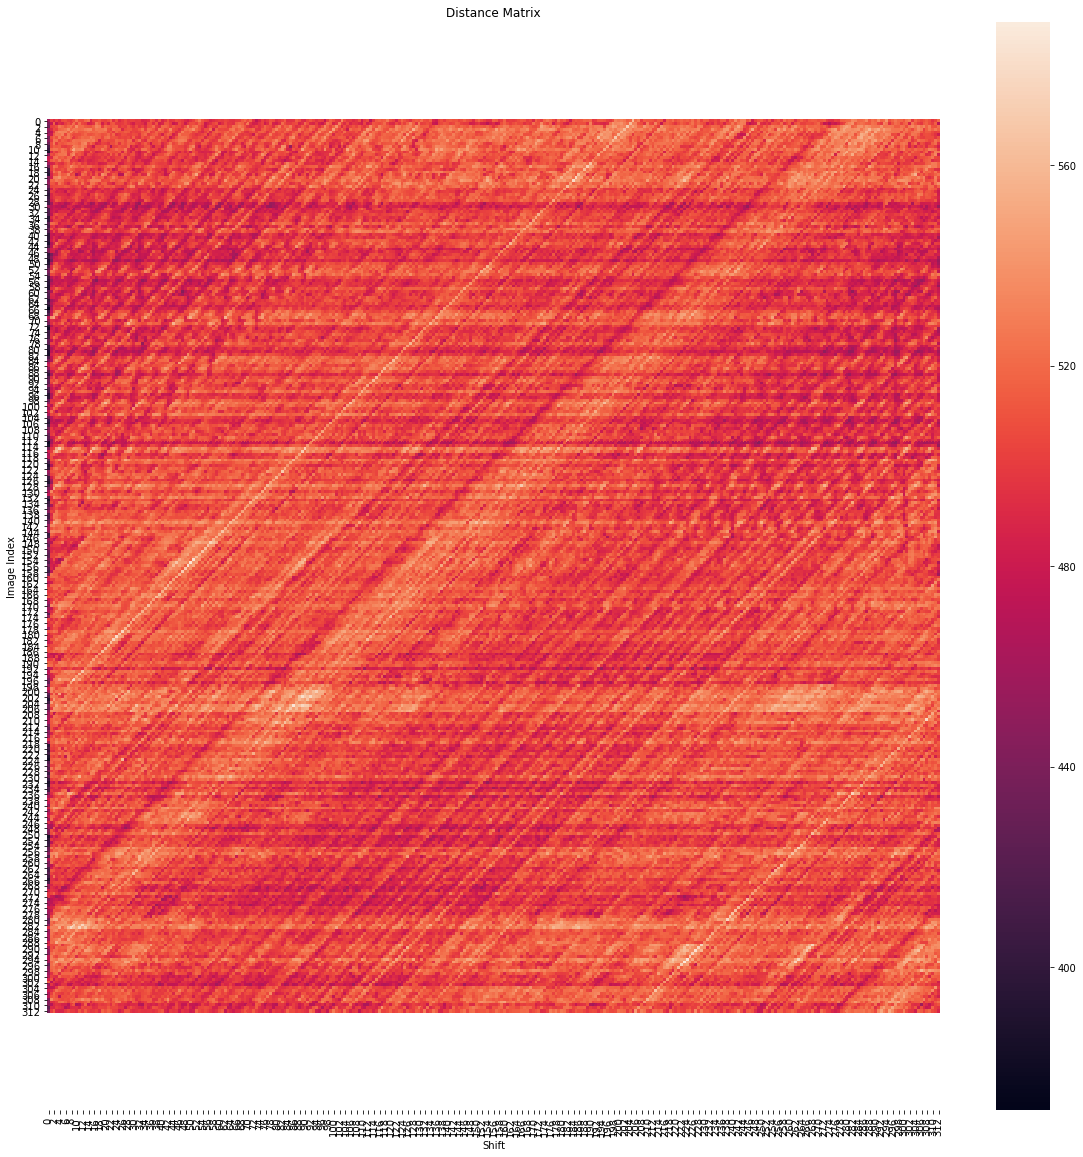

In [10]:
# visualize
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
fig_size = [20,20]
plt.rcParams["figure.figsize"] = fig_size
plt.axis('equal')
ax = sns.heatmap(dst,
                 xticklabels=2,
                 yticklabels=2)
ax.set_xlabel('Shift')
ax.set_ylabel('Image Index')
ax.set_title('Distance Matrix')
plt.show()

### 3. analyse the feature maps

In [7]:
print('Min, Max and Mean of Distances:')
print(np.min(dst), np.max(dst), np.average(dst))
lower, higher = np.min(dst), np.max(dst)

dst_t, dst_f = dst[:,0], dst[:,1:]
#print(dst_t.shape, dst_f.shape)
print('Min, Max and Mean of paired images:', np.min(dst_t), np.max(dst_t), np.mean(dst_t))
print('Min, Max and Mean of unpaired images:', np.min(dst_f), np.max(dst_f), np.mean(dst_f))

print('Sorted distance of paired images:')
print(np.sort(dst_t))

print('First n sorted distance of unpaired images:')
print(np.sort(dst_f.flatten())[:n])

Min, Max and Mean of Distances:
371.5809639535862 588.4696692352335 506.71553231586
Min, Max and Mean of paired images: 371.5809639535862 518.4513845464008 439.21840881939875
Min, Max and Mean of unpaired images: 438.06200805630755 588.4696692352335 506.93186925014345
Sorted distance of paired images:
[371.58096395 379.70398453 380.6952529  382.0110661  383.59213214
 385.27378923 386.07407751 387.69403476 388.41782435 388.66019641
 388.67706489 389.08194781 389.21835954 389.21964302 390.55471752
 391.13200158 391.45121919 391.46381504 392.13693159 392.55574413
 392.98775362 393.76730387 394.21376249 394.24566558 394.95943142
 395.07290342 395.11992903 395.70531913 396.15277824 396.51556736
 396.69763702 396.94963159 397.03504993 397.19529289 397.60914245
 397.64968081 397.8660133  398.09179367 398.3261031  398.38738432
 399.15692717 399.44862608 400.16831353 400.26814907 400.50632492
 401.43190958 402.18197617 402.3766213  402.54739099 403.66949676
 403.77391324 403.78664979 404.316840

In [ ]:
def predict(dst, threshold):
    return (dst <= threshold).astype(np.int)
def ground_truth(dst):
    n = dst.shape[0]
    gt = np.zeros((n,n)).astype(np.int)
    gt[:,0] = 1
    return gt
def confusion_matrix(pred, gt):
    n = gt.shape[0]
    TP = np.sum(gt[:,0] == pred[:,0])
    FN = np.sum(gt[:,0] != pred[:,0])
    TN = np.sum(gt[:,1:] == pred[:,1:])
    FP = np.sum(gt[:,1:] != pred[:,1:])
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision+recall)
    return TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1

threshold = 460
pred = predict(dst, threshold)
gt = ground_truth(dst)

print("TP, FP, TN, FN, TPR, FPR, Accuracy, Precision, Recall, F1:")
print(confusion_matrix(pred, gt))
#%matplotlib inline
plt.axis('equal')
ax = sns.heatmap(pred,
                 xticklabels=2,
                 yticklabels=2)
ax.set_xlabel('Shift')
ax.set_ylabel('Image Index')
ax.set_title('Prediction Matrix')
plt.show()

In [ ]:
# Draw ROC curve
np.seterr(divide='ignore',invalid='ignore')
ROC_x, ROC_y = [0], [0]
for threshold in range(int(lower),int(higher)+1):
    pred = predict(dst, threshold)
    gt = ground_truth(dst)
    conf_mat = confusion_matrix(pred, gt)
    x, y = conf_mat[5], conf_mat[4] # x: FPR, y: TPR
    ROC_x.append(x)
    ROC_y.append(y)
ROC_x.append(1)
ROC_y.append(1)
#%matplotlib inline
plt.plot(ROC_x, ROC_y)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis('equal')
plt.show()